In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
sns.set(font_scale=1.6)

In [4]:
print (tf.__version__)

2.6.0


### Define PINN neural network

In [5]:
def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(1))
    
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    
    model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))
    
    return model

In [6]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, model):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = model
        
        self.iter = 0
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1+loss_2+loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1:]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])

### Generate training data

In [7]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 5000                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([60000.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [8]:
N = 80000

### Train PINN without PCGrad

In [9]:
PINN_solver = PINN(x_u, y_u, x_r, init_model())
initial_weights = PINN_solver.model.get_weights()

In [10]:
optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 00000: loss = 0.3108814,5.3529483e-09
Iteration 00005: loss = 0.1549211,4.6981725e-09
Iteration 00010: loss = 0.054250892,5.035244e-09
Iteration 00015: loss = 0.016276916,5.9040635e-09
Iteration 00020: loss = 0.005566288,6.743946e-09
Iteration 00025: loss = 0.0024359932,7.359234e-09
Iteration 00030: loss = 0.0013419633,7.7722255e-09
Iteration 00035: loss = 0.0008823997,8.043897e-09
Iteration 00040: loss = 0.0006581627,8.223413e-09
Iteration 00045: loss = 0.0005352322,8.344002e-09
Iteration 00050: loss = 0.0004612557,8.427121e-09
Iteration 00055: loss = 0.00041304846,8.4864595e-09
Iteration 00060: loss = 0.0003792852,8.530727e-09
Iteration 00065: loss = 0.0003540154,8.565456e-09
Iteration 00070: loss = 0.00033394035,8.594148e-09
Iteration 00075: loss = 0.00031716845,8.619022e-09
Iteration 00080: loss = 0.00030257608,8.641474e-09
Iteration 00085: loss = 0.00028949775,8.662376e-09
Iteration 00090: loss = 0.00027752787,8.682267e-09
Iteration 00095: loss = 0.0002664063,8.701488e-0

Iteration 00820: loss = 1.3889749e-05,1.0072461e-08
Iteration 00825: loss = 1.3734698e-05,1.0077462e-08
Iteration 00830: loss = 1.3582084e-05,1.0082438e-08
Iteration 00835: loss = 1.3431665e-05,1.0087387e-08
Iteration 00840: loss = 1.3283837e-05,1.009231e-08
Iteration 00845: loss = 1.31377465e-05,1.0097203e-08
Iteration 00850: loss = 1.2994979e-05,1.0102073e-08
Iteration 00855: loss = 1.28536785e-05,1.0106918e-08
Iteration 00860: loss = 1.2714638e-05,1.0111737e-08
Iteration 00865: loss = 1.2578011e-05,1.011653e-08
Iteration 00870: loss = 1.2443175e-05,1.0121299e-08
Iteration 00875: loss = 1.2310891e-05,1.0126044e-08
Iteration 00880: loss = 1.2179941e-05,1.0130764e-08
Iteration 00885: loss = 1.2051697e-05,1.0135459e-08
Iteration 00890: loss = 1.1925126e-05,1.0140132e-08
Iteration 00895: loss = 1.1800602e-05,1.0144781e-08
Iteration 00900: loss = 1.167753e-05,1.0149405e-08
Iteration 00905: loss = 1.1556641e-05,1.0154007e-08
Iteration 00910: loss = 1.1437524e-05,1.0158587e-08
Iteration 009

Iteration 01620: loss = 3.6459007e-06,1.0651493e-08
Iteration 01625: loss = 3.6225267e-06,1.0654205e-08
Iteration 01630: loss = 3.5993783e-06,1.0656908e-08
Iteration 01635: loss = 3.576238e-06,1.0659605e-08
Iteration 01640: loss = 3.5534304e-06,1.0662294e-08
Iteration 01645: loss = 3.5307373e-06,1.0664975e-08
Iteration 01650: loss = 3.5085802e-06,1.0667652e-08
Iteration 01655: loss = 3.4862196e-06,1.0670318e-08
Iteration 01660: loss = 3.4642835e-06,1.0672981e-08
Iteration 01665: loss = 3.4424627e-06,1.0675632e-08
Iteration 01670: loss = 3.4206416e-06,1.0678278e-08
Iteration 01675: loss = 3.3992399e-06,1.0680916e-08
Iteration 01680: loss = 3.3781519e-06,1.0683549e-08
Iteration 01685: loss = 3.3569634e-06,1.0686177e-08
Iteration 01690: loss = 3.335984e-06,1.0688793e-08
Iteration 01695: loss = 3.3154138e-06,1.0691407e-08
Iteration 01700: loss = 3.294742e-06,1.069401e-08
Iteration 01705: loss = 3.2742712e-06,1.0696608e-08
Iteration 01710: loss = 3.2542055e-06,1.06992e-08
Iteration 01715: l

Iteration 02415: loss = 1.5214627e-06,1.1012237e-08
Iteration 02420: loss = 1.514332e-06,1.1014167e-08
Iteration 02425: loss = 1.5071596e-06,1.1016093e-08
Iteration 02430: loss = 1.5000815e-06,1.1018016e-08
Iteration 02435: loss = 1.4928936e-06,1.1019934e-08
Iteration 02440: loss = 1.4857302e-06,1.1021849e-08
Iteration 02445: loss = 1.4787967e-06,1.1023764e-08
Iteration 02450: loss = 1.4718235e-06,1.1025672e-08
Iteration 02455: loss = 1.4650082e-06,1.1027578e-08
Iteration 02460: loss = 1.4580854e-06,1.1029481e-08
Iteration 02465: loss = 1.4511862e-06,1.1031383e-08
Iteration 02470: loss = 1.4443776e-06,1.1033281e-08
Iteration 02475: loss = 1.4377969e-06,1.1035174e-08
Iteration 02480: loss = 1.430972e-06,1.1037065e-08
Iteration 02485: loss = 1.4241714e-06,1.1038955e-08
Iteration 02490: loss = 1.4177289e-06,1.1040838e-08
Iteration 02495: loss = 1.4109743e-06,1.10427205e-08
Iteration 02500: loss = 1.4045135e-06,1.1044599e-08
Iteration 02505: loss = 1.3980734e-06,1.1046474e-08
Iteration 025

Iteration 03215: loss = 7.633292e-07,1.1287474e-08
Iteration 03220: loss = 7.6041056e-07,1.1289021e-08
Iteration 03225: loss = 7.573549e-07,1.12905685e-08
Iteration 03230: loss = 7.544047e-07,1.1292114e-08
Iteration 03235: loss = 7.515598e-07,1.1293658e-08
Iteration 03240: loss = 7.4853e-07,1.1295198e-08
Iteration 03245: loss = 7.456065e-07,1.1296739e-08
Iteration 03250: loss = 7.4269036e-07,1.1298275e-08
Iteration 03255: loss = 7.396875e-07,1.12998135e-08
Iteration 03260: loss = 7.368842e-07,1.1301347e-08
Iteration 03265: loss = 7.3399514e-07,1.130288e-08
Iteration 03270: loss = 7.3116115e-07,1.1304413e-08
Iteration 03275: loss = 7.2838384e-07,1.1305941e-08
Iteration 03280: loss = 7.255185e-07,1.130747e-08
Iteration 03285: loss = 7.227568e-07,1.1308996e-08
Iteration 03290: loss = 7.1990803e-07,1.13105205e-08
Iteration 03295: loss = 7.170684e-07,1.1312045e-08
Iteration 03300: loss = 7.1433027e-07,1.1313567e-08
Iteration 03305: loss = 7.115068e-07,1.1315087e-08
Iteration 03310: loss = 7

Iteration 04010: loss = 4.246361e-07,1.1515262e-08
Iteration 04015: loss = 4.2311777e-07,1.1516595e-08
Iteration 04020: loss = 4.2167702e-07,1.1517928e-08
Iteration 04025: loss = 4.2016623e-07,1.15192575e-08
Iteration 04030: loss = 4.1873264e-07,1.1520587e-08
Iteration 04035: loss = 4.1730232e-07,1.1521916e-08
Iteration 04040: loss = 4.158758e-07,1.1523243e-08
Iteration 04045: loss = 4.1438045e-07,1.1524568e-08
Iteration 04050: loss = 4.1296107e-07,1.1525895e-08
Iteration 04055: loss = 4.1147322e-07,1.1527218e-08
Iteration 04060: loss = 4.1013251e-07,1.1528543e-08
Iteration 04065: loss = 4.0872374e-07,1.1529865e-08
Iteration 04070: loss = 4.0724674e-07,1.1531188e-08
Iteration 04075: loss = 4.05917e-07,1.1532506e-08
Iteration 04080: loss = 4.0451883e-07,1.1533828e-08
Iteration 04085: loss = 4.0308836e-07,1.1535144e-08
Iteration 04090: loss = 4.016973e-07,1.1536464e-08
Iteration 04095: loss = 4.0038046e-07,1.15377805e-08
Iteration 04100: loss = 3.9899612e-07,1.1539094e-08
Iteration 04105

Iteration 04820: loss = 2.4786672e-07,1.1719256e-08
Iteration 04825: loss = 2.47099e-07,1.17204495e-08
Iteration 04830: loss = 2.4627758e-07,1.1721645e-08
Iteration 04835: loss = 2.4551358e-07,1.1722838e-08
Iteration 04840: loss = 2.447514e-07,1.172403e-08
Iteration 04845: loss = 2.4399083e-07,1.172522e-08
Iteration 04850: loss = 2.431765e-07,1.1726414e-08
Iteration 04855: loss = 2.4241965e-07,1.1727602e-08
Iteration 04860: loss = 2.4166425e-07,1.1728792e-08
Iteration 04865: loss = 2.4091057e-07,1.1729979e-08
Iteration 04870: loss = 2.4015858e-07,1.1731168e-08
Iteration 04875: loss = 2.3935362e-07,1.1732354e-08
Iteration 04880: loss = 2.386051e-07,1.1733539e-08
Iteration 04885: loss = 2.3785856e-07,1.1734723e-08
Iteration 04890: loss = 2.371133e-07,1.173591e-08
Iteration 04895: loss = 2.3637006e-07,1.1737095e-08
Iteration 04900: loss = 2.3562815e-07,1.173828e-08
Iteration 04905: loss = 2.3488805e-07,1.1739462e-08
Iteration 04910: loss = 2.3414971e-07,1.1740646e-08
Iteration 04915: loss

Iteration 05615: loss = 1.5168916e-07,1.1901323e-08
Iteration 05620: loss = 1.512309e-07,1.1902423e-08
Iteration 05625: loss = 1.5072969e-07,1.19035235e-08
Iteration 05630: loss = 1.5031681e-07,1.1904625e-08
Iteration 05635: loss = 1.4986126e-07,1.1905723e-08
Iteration 05640: loss = 1.4940663e-07,1.1906821e-08
Iteration 05645: loss = 1.4895298e-07,1.190792e-08
Iteration 05650: loss = 1.4850018e-07,1.19090195e-08
Iteration 05655: loss = 1.4804849e-07,1.1910116e-08
Iteration 05660: loss = 1.4759794e-07,1.1911214e-08
Iteration 05665: loss = 1.4719114e-07,1.1912309e-08
Iteration 05670: loss = 1.4674204e-07,1.19134045e-08
Iteration 05675: loss = 1.4629411e-07,1.1914501e-08
Iteration 05680: loss = 1.4584727e-07,1.19155965e-08
Iteration 05685: loss = 1.4540119e-07,1.1916692e-08
Iteration 05690: loss = 1.450414e-07,1.1917784e-08
Iteration 05695: loss = 1.4459711e-07,1.1918879e-08
Iteration 05700: loss = 1.4415387e-07,1.191997e-08
Iteration 05705: loss = 1.4371143e-07,1.19210615e-08
Iteration 0

Iteration 06410: loss = 9.5099615e-08,1.20705845e-08
Iteration 06415: loss = 9.486964e-08,1.2071618e-08
Iteration 06420: loss = 9.460545e-08,1.2072649e-08
Iteration 06425: loss = 9.430746e-08,1.2073675e-08
Iteration 06430: loss = 9.404431e-08,1.20747075e-08
Iteration 06435: loss = 9.378187e-08,1.2075738e-08
Iteration 06440: loss = 9.348556e-08,1.2076766e-08
Iteration 06445: loss = 9.3224095e-08,1.2077793e-08
Iteration 06450: loss = 9.296317e-08,1.2078824e-08
Iteration 06455: loss = 9.270273e-08,1.2079852e-08
Iteration 06460: loss = 9.240876e-08,1.2080877e-08
Iteration 06465: loss = 9.214935e-08,1.2081907e-08
Iteration 06470: loss = 9.192456e-08,1.2082934e-08
Iteration 06475: loss = 9.163216e-08,1.2083961e-08
Iteration 06480: loss = 9.137444e-08,1.2084986e-08
Iteration 06485: loss = 9.111708e-08,1.208601e-08
Iteration 06490: loss = 9.0860254e-08,1.2087036e-08
Iteration 06495: loss = 9.057012e-08,1.208806e-08
Iteration 06500: loss = 9.031453e-08,1.2089086e-08
Iteration 06505: loss = 9.00

Iteration 07210: loss = 6.0510416e-08,1.2230929e-08
Iteration 07215: loss = 6.0343645e-08,1.22319035e-08
Iteration 07220: loss = 6.020464e-08,1.223288e-08
Iteration 07225: loss = 6.003849e-08,1.2233853e-08
Iteration 07230: loss = 5.984517e-08,1.2234829e-08
Iteration 07235: loss = 5.967963e-08,1.2235802e-08
Iteration 07240: loss = 5.95145e-08,1.2236773e-08
Iteration 07245: loss = 5.937692e-08,1.2237746e-08
Iteration 07250: loss = 5.91851e-08,1.2238719e-08
Iteration 07255: loss = 5.9020824e-08,1.2239691e-08
Iteration 07260: loss = 5.885693e-08,1.2240665e-08
Iteration 07265: loss = 5.8720403e-08,1.2241635e-08
Iteration 07270: loss = 5.855711e-08,1.2242606e-08
Iteration 07275: loss = 5.836698e-08,1.2243577e-08
Iteration 07280: loss = 5.8204293e-08,1.2244546e-08
Iteration 07285: loss = 5.806895e-08,1.2245517e-08
Iteration 07290: loss = 5.790686e-08,1.22464865e-08
Iteration 07295: loss = 5.7745055e-08,1.2247456e-08
Iteration 07300: loss = 5.7556694e-08,1.2248424e-08
Iteration 07305: loss = 5

Iteration 08020: loss = 3.881335e-08,1.2384743e-08
Iteration 08025: loss = 3.8711804e-08,1.2385668e-08
Iteration 08030: loss = 3.8588365e-08,1.2386594e-08
Iteration 08035: loss = 3.8509253e-08,1.2387516e-08
Iteration 08040: loss = 3.840826e-08,1.23884405e-08
Iteration 08045: loss = 3.8285524e-08,1.2389361e-08
Iteration 08050: loss = 3.818497e-08,1.2390286e-08
Iteration 08055: loss = 3.8084508e-08,1.239121e-08
Iteration 08060: loss = 3.798431e-08,1.239213e-08
Iteration 08065: loss = 3.7884316e-08,1.2393055e-08
Iteration 08070: loss = 3.776265e-08,1.2393977e-08
Iteration 08075: loss = 3.7684742e-08,1.23948976e-08
Iteration 08080: loss = 3.756357e-08,1.239582e-08
Iteration 08085: loss = 3.7464293e-08,1.2396742e-08
Iteration 08090: loss = 3.736518e-08,1.2397662e-08
Iteration 08095: loss = 3.7266272e-08,1.2398582e-08
Iteration 08100: loss = 3.7167567e-08,1.2399503e-08
Iteration 08105: loss = 3.7069018e-08,1.2400424e-08
Iteration 08110: loss = 3.6970636e-08,1.2401344e-08
Iteration 08115: los

Iteration 08825: loss = 2.5205635e-08,1.2529759e-08
Iteration 08830: loss = 2.514763e-08,1.2530634e-08
Iteration 08835: loss = 2.5071968e-08,1.253151e-08
Iteration 08840: loss = 2.5014124e-08,1.2532385e-08
Iteration 08845: loss = 2.4956464e-08,1.25332615e-08
Iteration 08850: loss = 2.4863466e-08,1.2534136e-08
Iteration 08855: loss = 2.4806026e-08,1.253501e-08
Iteration 08860: loss = 2.4748658e-08,1.2535885e-08
Iteration 08865: loss = 2.467378e-08,1.2536758e-08
Iteration 08870: loss = 2.461664e-08,1.2537633e-08
Iteration 08875: loss = 2.4559602e-08,1.2538506e-08
Iteration 08880: loss = 2.4485098e-08,1.253938e-08
Iteration 08885: loss = 2.442826e-08,1.2540253e-08
Iteration 08890: loss = 2.4354017e-08,1.25411255e-08
Iteration 08895: loss = 2.4297384e-08,1.25419986e-08
Iteration 08900: loss = 2.4240885e-08,1.2542869e-08
Iteration 08905: loss = 2.414958e-08,1.2543742e-08
Iteration 08910: loss = 2.4093316e-08,1.25446125e-08
Iteration 08915: loss = 2.4037108e-08,1.2545484e-08
Iteration 08920:

Iteration 09620: loss = 1.660625e-08,1.2665109e-08
Iteration 09625: loss = 1.6562854e-08,1.2665933e-08
Iteration 09630: loss = 1.6519584e-08,1.2666759e-08
Iteration 09635: loss = 1.6476385e-08,1.2667584e-08
Iteration 09640: loss = 1.6433232e-08,1.2668409e-08
Iteration 09645: loss = 1.6404542e-08,1.2669233e-08
Iteration 09650: loss = 1.6361522e-08,1.2670056e-08
Iteration 09655: loss = 1.6318609e-08,1.26708795e-08
Iteration 09660: loss = 1.6261465e-08,1.2671703e-08
Iteration 09665: loss = 1.6218694e-08,1.2672526e-08
Iteration 09670: loss = 1.6176028e-08,1.2673348e-08
Iteration 09675: loss = 1.6133434e-08,1.2674169e-08
Iteration 09680: loss = 1.6090898e-08,1.267499e-08
Iteration 09685: loss = 1.606265e-08,1.267581e-08
Iteration 09690: loss = 1.602026e-08,1.2676633e-08
Iteration 09695: loss = 1.597794e-08,1.2677455e-08
Iteration 09700: loss = 1.5935703e-08,1.2678273e-08
Iteration 09705: loss = 1.5893542e-08,1.2679092e-08
Iteration 09710: loss = 1.5851429e-08,1.2679913e-08
Iteration 09715: 

Iteration 10420: loss = 1.09944365e-08,1.2792679e-08
Iteration 10425: loss = 1.0985034e-08,1.2793445e-08
Iteration 10430: loss = 1.095215e-08,1.2794211e-08
Iteration 10435: loss = 1.091933e-08,1.27949775e-08
Iteration 10440: loss = 1.0898295e-08,1.2795743e-08
Iteration 10445: loss = 1.0865588e-08,1.2796505e-08
Iteration 10450: loss = 1.0832945e-08,1.2797271e-08
Iteration 10455: loss = 1.0812028e-08,1.2798034e-08
Iteration 10460: loss = 1.0791138e-08,1.27988e-08
Iteration 10465: loss = 1.0758634e-08,1.2799561e-08
Iteration 10470: loss = 1.0726204e-08,1.2800326e-08
Iteration 10475: loss = 1.0705437e-08,1.2801087e-08
Iteration 10480: loss = 1.0673105e-08,1.280185e-08
Iteration 10485: loss = 1.0640842e-08,1.2802611e-08
Iteration 10490: loss = 1.0620216e-08,1.2803374e-08
Iteration 10495: loss = 1.0599588e-08,1.2804134e-08
Iteration 10500: loss = 1.0567465e-08,1.2804896e-08
Iteration 10505: loss = 1.0535417e-08,1.2805653e-08
Iteration 10510: loss = 1.0514921e-08,1.2806412e-08
Iteration 10515

Iteration 11225: loss = 7.3270816e-09,1.29105135e-08
Iteration 11230: loss = 7.3209385e-09,1.2911209e-08
Iteration 11235: loss = 7.295652e-09,1.2911901e-08
Iteration 11240: loss = 7.279974e-09,1.2912592e-08
Iteration 11245: loss = 7.25478e-09,1.29132856e-08
Iteration 11250: loss = 7.239168e-09,1.2913977e-08
Iteration 11255: loss = 7.2235795e-09,1.2914667e-08
Iteration 11260: loss = 7.198503e-09,1.2915359e-08
Iteration 11265: loss = 7.19248e-09,1.2916049e-08
Iteration 11270: loss = 7.1674715e-09,1.2916737e-08
Iteration 11275: loss = 7.1519928e-09,1.2917427e-08
Iteration 11280: loss = 7.1365522e-09,1.2918116e-08
Iteration 11285: loss = 7.121122e-09,1.2918805e-08
Iteration 11290: loss = 7.0962662e-09,1.2919491e-08
Iteration 11295: loss = 7.08091e-09,1.2920177e-08
Iteration 11300: loss = 7.065566e-09,1.2920864e-08
Iteration 11305: loss = 7.040835e-09,1.2921549e-08
Iteration 11310: loss = 7.034965e-09,1.2922234e-08
Iteration 11315: loss = 7.010312e-09,1.292292e-08
Iteration 11320: loss = 6.

Iteration 12025: loss = 4.943401e-09,1.3014472e-08
Iteration 12030: loss = 4.931494e-09,1.3015073e-08
Iteration 12035: loss = 4.919609e-09,1.3015675e-08
Iteration 12040: loss = 4.907742e-09,1.3016274e-08
Iteration 12045: loss = 4.895897e-09,1.3016873e-08
Iteration 12050: loss = 4.884071e-09,1.3017472e-08
Iteration 12055: loss = 4.8722657e-09,1.3018069e-08
Iteration 12060: loss = 4.860476e-09,1.3018666e-08
Iteration 12065: loss = 4.848712e-09,1.3019266e-08
Iteration 12070: loss = 4.8369677e-09,1.3019858e-08
Iteration 12075: loss = 4.8252375e-09,1.3020454e-08
Iteration 12080: loss = 4.8135296e-09,1.3021048e-08
Iteration 12085: loss = 4.8018376e-09,1.3021642e-08
Iteration 12090: loss = 4.7901705e-09,1.30222375e-08
Iteration 12095: loss = 4.778523e-09,1.3022827e-08
Iteration 12100: loss = 4.7668935e-09,1.302342e-08
Iteration 12105: loss = 4.7552846e-09,1.302401e-08
Iteration 12110: loss = 4.7436877e-09,1.3024602e-08
Iteration 12115: loss = 4.732125e-09,1.3025191e-08
Iteration 12120: loss =

Iteration 12825: loss = 3.372036e-09,1.3101536e-08
Iteration 12830: loss = 3.3628735e-09,1.3102016e-08
Iteration 12835: loss = 3.353722e-09,1.3102497e-08
Iteration 12840: loss = 3.344595e-09,1.3102976e-08
Iteration 12845: loss = 3.3354792e-09,1.3103454e-08
Iteration 12850: loss = 3.3328424e-09,1.3103934e-08
Iteration 12855: loss = 3.3172964e-09,1.3104409e-08
Iteration 12860: loss = 3.3146768e-09,1.3104885e-08
Iteration 12865: loss = 3.312066e-09,1.3105358e-08
Iteration 12870: loss = 3.2965783e-09,1.3105833e-08
Iteration 12875: loss = 3.293979e-09,1.3106307e-08
Iteration 12880: loss = 3.2785374e-09,1.310678e-08
Iteration 12885: loss = 3.2759522e-09,1.310725e-08
Iteration 12890: loss = 3.2669671e-09,1.3107721e-08
Iteration 12895: loss = 3.257995e-09,1.3108192e-08
Iteration 12900: loss = 3.2554288e-09,1.3108661e-08
Iteration 12905: loss = 3.2464798e-09,1.310913e-08
Iteration 12910: loss = 3.2375438e-09,1.3109597e-08
Iteration 12915: loss = 3.2286325e-09,1.3110063e-08
Iteration 12920: loss

Iteration 13625: loss = 2.3261502e-09,1.3166602e-08
Iteration 13630: loss = 2.324387e-09,1.3166925e-08
Iteration 13635: loss = 2.3172306e-09,1.3167249e-08
Iteration 13640: loss = 2.3100941e-09,1.3167572e-08
Iteration 13645: loss = 2.308343e-09,1.31678926e-08
Iteration 13650: loss = 2.3066002e-09,1.3168211e-08
Iteration 13655: loss = 2.2941131e-09,1.3168531e-08
Iteration 13660: loss = 2.2923783e-09,1.3168849e-08
Iteration 13665: loss = 2.290646e-09,1.3169164e-08
Iteration 13670: loss = 2.278212e-09,1.3169483e-08
Iteration 13675: loss = 2.276489e-09,1.3169796e-08
Iteration 13680: loss = 2.2747695e-09,1.317011e-08
Iteration 13685: loss = 2.262391e-09,1.3170422e-08
Iteration 13690: loss = 2.2606792e-09,1.3170734e-08
Iteration 13695: loss = 2.2589763e-09,1.3171046e-08
Iteration 13700: loss = 2.2519544e-09,1.3171352e-08
Iteration 13705: loss = 2.2449498e-09,1.3171661e-08
Iteration 13710: loss = 2.2432571e-09,1.3171967e-08
Iteration 13715: loss = 2.2362692e-09,1.3172273e-08
Iteration 13720: l

Iteration 14425: loss = 1.6376505e-09,1.3203158e-08
Iteration 14430: loss = 1.6319531e-09,1.3203279e-08
Iteration 14435: loss = 1.6262715e-09,1.32034e-08
Iteration 14440: loss = 1.6251055e-09,1.3203522e-08
Iteration 14445: loss = 1.6239428e-09,1.3203638e-08
Iteration 14450: loss = 1.6182781e-09,1.3203756e-08
Iteration 14455: loss = 1.6126283e-09,1.3203872e-08
Iteration 14460: loss = 1.6114736e-09,1.3203986e-08
Iteration 14465: loss = 1.610324e-09,1.3204099e-08
Iteration 14470: loss = 1.6046878e-09,1.320421e-08
Iteration 14475: loss = 1.5990685e-09,1.3204321e-08
Iteration 14480: loss = 1.5979255e-09,1.320443e-08
Iteration 14485: loss = 1.5967867e-09,1.3204535e-08
Iteration 14490: loss = 1.5867263e-09,1.3204642e-08
Iteration 14495: loss = 1.5855921e-09,1.3204747e-08
Iteration 14500: loss = 1.5844632e-09,1.3204849e-08
Iteration 14505: loss = 1.5833347e-09,1.320495e-08
Iteration 14510: loss = 1.5733246e-09,1.32050495e-08
Iteration 14515: loss = 1.5722028e-09,1.3205149e-08
Iteration 14520: 

Iteration 15225: loss = 1.1743734e-09,1.3203389e-08
Iteration 15230: loss = 1.1697707e-09,1.3203257e-08
Iteration 15235: loss = 1.1689938e-09,1.3203126e-08
Iteration 15240: loss = 1.1682199e-09,1.3202988e-08
Iteration 15245: loss = 1.1674461e-09,1.3202851e-08
Iteration 15250: loss = 1.1628623e-09,1.3202713e-08
Iteration 15255: loss = 1.1582891e-09,1.3202576e-08
Iteration 15260: loss = 1.1575231e-09,1.3202432e-08
Iteration 15265: loss = 1.156757e-09,1.3202287e-08
Iteration 15270: loss = 1.1559936e-09,1.3202144e-08
Iteration 15275: loss = 1.1514377e-09,1.3201999e-08
Iteration 15280: loss = 1.1468937e-09,1.32018485e-08
Iteration 15285: loss = 1.1461371e-09,1.32017e-08
Iteration 15290: loss = 1.1453818e-09,1.32015465e-08
Iteration 15295: loss = 1.1446272e-09,1.3201394e-08
Iteration 15300: loss = 1.1400987e-09,1.3201237e-08
Iteration 15305: loss = 1.1355837e-09,1.32010785e-08
Iteration 15310: loss = 1.134836e-09,1.32009195e-08
Iteration 15315: loss = 1.134091e-09,1.3200757e-08
Iteration 153

Iteration 16025: loss = 8.659713e-10,1.3158367e-08
Iteration 16030: loss = 8.654561e-10,1.3157924e-08
Iteration 16035: loss = 8.6166757e-10,1.3157475e-08
Iteration 16040: loss = 8.611549e-10,1.315703e-08
Iteration 16045: loss = 8.6064195e-10,1.3156578e-08
Iteration 16050: loss = 8.5686797e-10,1.3156127e-08
Iteration 16055: loss = 8.5635654e-10,1.3155671e-08
Iteration 16060: loss = 8.558502e-10,1.3155216e-08
Iteration 16065: loss = 8.520887e-10,1.3154757e-08
Iteration 16070: loss = 8.5158386e-10,1.3154295e-08
Iteration 16075: loss = 8.510798e-10,1.3153833e-08
Iteration 16080: loss = 8.505771e-10,1.3153366e-08
Iteration 16085: loss = 8.468312e-10,1.3152898e-08
Iteration 16090: loss = 8.4632995e-10,1.315243e-08
Iteration 16095: loss = 8.4259555e-10,1.3151958e-08
Iteration 16100: loss = 8.420988e-10,1.3151482e-08
Iteration 16105: loss = 8.416023e-10,1.3151006e-08
Iteration 16110: loss = 8.4110785e-10,1.3150527e-08
Iteration 16115: loss = 8.40614e-10,1.3150046e-08
Iteration 16120: loss = 8.

Iteration 16825: loss = 6.605254e-10,1.3058261e-08
Iteration 16830: loss = 6.6018746e-10,1.3057439e-08
Iteration 16835: loss = 6.5700306e-10,1.3056616e-08
Iteration 16840: loss = 6.566679e-10,1.305579e-08
Iteration 16845: loss = 6.563328e-10,1.3054958e-08
Iteration 16850: loss = 6.5599887e-10,1.3054127e-08
Iteration 16855: loss = 6.5566547e-10,1.3053292e-08
Iteration 16860: loss = 6.5533395e-10,1.3052455e-08
Iteration 16865: loss = 6.550003e-10,1.3051615e-08
Iteration 16870: loss = 6.51832e-10,1.3050776e-08
Iteration 16875: loss = 6.4867306e-10,1.3049931e-08
Iteration 16880: loss = 6.483449e-10,1.30490845e-08
Iteration 16885: loss = 6.4801636e-10,1.30482345e-08
Iteration 16890: loss = 6.47691e-10,1.3047379e-08
Iteration 16895: loss = 6.4736433e-10,1.3046524e-08
Iteration 16900: loss = 6.470379e-10,1.3045667e-08
Iteration 16905: loss = 6.467134e-10,1.3044808e-08
Iteration 16910: loss = 6.4357036e-10,1.3043946e-08
Iteration 16915: loss = 6.404379e-10,1.304308e-08
Iteration 16920: loss = 

Iteration 17640: loss = 5.246641e-10,1.2888116e-08
Iteration 17645: loss = 5.2445076e-10,1.2886832e-08
Iteration 17650: loss = 5.217138e-10,1.2885549e-08
Iteration 17655: loss = 5.215025e-10,1.2884258e-08
Iteration 17660: loss = 5.2128996e-10,1.2882966e-08
Iteration 17665: loss = 5.2107835e-10,1.2881673e-08
Iteration 17670: loss = 5.18352e-10,1.2880371e-08
Iteration 17675: loss = 5.18143e-10,1.287907e-08
Iteration 17680: loss = 5.1793453e-10,1.28777655e-08
Iteration 17685: loss = 5.1772614e-10,1.2876456e-08
Iteration 17690: loss = 5.1751886e-10,1.2875144e-08
Iteration 17695: loss = 5.1731136e-10,1.2873829e-08
Iteration 17700: loss = 5.17105e-10,1.2872515e-08
Iteration 17705: loss = 5.1689836e-10,1.2871195e-08
Iteration 17710: loss = 5.166911e-10,1.2869872e-08
Iteration 17715: loss = 5.139792e-10,1.286855e-08
Iteration 17720: loss = 5.112785e-10,1.2867219e-08
Iteration 17725: loss = 5.1107535e-10,1.2865886e-08
Iteration 17730: loss = 5.108731e-10,1.2864549e-08
Iteration 17735: loss = 5.

Iteration 18445: loss = 4.3733053e-10,1.26390525e-08
Iteration 18450: loss = 4.372053e-10,1.263722e-08
Iteration 18455: loss = 4.370795e-10,1.2635384e-08
Iteration 18460: loss = 4.369535e-10,1.2633546e-08
Iteration 18465: loss = 4.368288e-10,1.2631701e-08
Iteration 18470: loss = 4.3441584e-10,1.26298545e-08
Iteration 18475: loss = 4.3429152e-10,1.2628005e-08
Iteration 18480: loss = 4.3416792e-10,1.2626151e-08
Iteration 18485: loss = 4.3404472e-10,1.2624291e-08
Iteration 18490: loss = 4.339217e-10,1.2622431e-08
Iteration 18495: loss = 4.3379852e-10,1.2620566e-08
Iteration 18500: loss = 4.336758e-10,1.2618698e-08
Iteration 18505: loss = 4.3355267e-10,1.26168285e-08
Iteration 18510: loss = 4.3342965e-10,1.2614955e-08
Iteration 18515: loss = 4.333068e-10,1.26130795e-08
Iteration 18520: loss = 4.3318468e-10,1.2611204e-08
Iteration 18525: loss = 4.3306292e-10,1.2609317e-08
Iteration 18530: loss = 4.306624e-10,1.2607429e-08
Iteration 18535: loss = 4.2827356e-10,1.2605535e-08
Iteration 18540: 

Iteration 19250: loss = 3.846267e-10,1.2293495e-08
Iteration 19255: loss = 3.8456605e-10,1.2291008e-08
Iteration 19260: loss = 3.8450507e-10,1.2288515e-08
Iteration 19265: loss = 3.8444414e-10,1.2286018e-08
Iteration 19270: loss = 3.843835e-10,1.228352e-08
Iteration 19275: loss = 3.843228e-10,1.2281017e-08
Iteration 19280: loss = 3.8426184e-10,1.2278513e-08
Iteration 19285: loss = 3.8420114e-10,1.22760015e-08
Iteration 19290: loss = 3.8414064e-10,1.2273487e-08
Iteration 19295: loss = 3.8408024e-10,1.227097e-08
Iteration 19300: loss = 3.8401934e-10,1.22684485e-08
Iteration 19305: loss = 3.8395773e-10,1.2265925e-08
Iteration 19310: loss = 3.838975e-10,1.22633965e-08
Iteration 19315: loss = 3.817103e-10,1.2260866e-08
Iteration 19320: loss = 3.8165135e-10,1.2258324e-08
Iteration 19325: loss = 3.815933e-10,1.225578e-08
Iteration 19330: loss = 3.8153616e-10,1.225323e-08
Iteration 19335: loss = 3.8147885e-10,1.2250674e-08
Iteration 19340: loss = 3.8142234e-10,1.22481145e-08
Iteration 19345: l

Iteration 20050: loss = 3.597378e-10,1.1838845e-08
Iteration 20055: loss = 3.5972333e-10,1.1835633e-08
Iteration 20060: loss = 3.5970904e-10,1.1832415e-08
Iteration 20065: loss = 3.5969464e-10,1.182919e-08
Iteration 20070: loss = 3.5968026e-10,1.1825966e-08
Iteration 20075: loss = 3.5966596e-10,1.1822734e-08
Iteration 20080: loss = 3.596514e-10,1.1819498e-08
Iteration 20085: loss = 3.5963696e-10,1.1816262e-08
Iteration 20090: loss = 3.596228e-10,1.18130155e-08
Iteration 20095: loss = 3.5960893e-10,1.1809771e-08
Iteration 20100: loss = 3.5755277e-10,1.1806518e-08
Iteration 20105: loss = 3.5754041e-10,1.1803261e-08
Iteration 20110: loss = 3.5752848e-10,1.1799995e-08
Iteration 20115: loss = 3.5751746e-10,1.1796722e-08
Iteration 20120: loss = 3.5750622e-10,1.1793446e-08
Iteration 20125: loss = 3.5953665e-10,1.179017e-08
Iteration 20130: loss = 3.595232e-10,1.178689e-08
Iteration 20135: loss = 3.5951006e-10,1.1783611e-08
Iteration 20140: loss = 3.5949588e-10,1.1780327e-08
Iteration 20145: l

Iteration 20850: loss = 3.515842e-10,1.126764e-08
Iteration 20855: loss = 3.5160239e-10,1.1263704e-08
Iteration 20860: loss = 3.516206e-10,1.12597665e-08
Iteration 20865: loss = 3.5163852e-10,1.1255826e-08
Iteration 20870: loss = 3.5165668e-10,1.1251879e-08
Iteration 20875: loss = 3.516737e-10,1.12479315e-08
Iteration 20880: loss = 3.516908e-10,1.1243983e-08
Iteration 20885: loss = 3.517079e-10,1.12400285e-08
Iteration 20890: loss = 3.517244e-10,1.12360725e-08
Iteration 20895: loss = 3.5174105e-10,1.1232109e-08
Iteration 20900: loss = 3.5175704e-10,1.12281455e-08
Iteration 20905: loss = 3.5177336e-10,1.1224178e-08
Iteration 20910: loss = 3.5178996e-10,1.1220204e-08
Iteration 20915: loss = 3.5180736e-10,1.121623e-08
Iteration 20920: loss = 3.5182354e-10,1.1212248e-08
Iteration 20925: loss = 3.5183978e-10,1.12082645e-08
Iteration 20930: loss = 3.518568e-10,1.1204278e-08
Iteration 20935: loss = 3.518734e-10,1.1200287e-08
Iteration 20940: loss = 3.5390338e-10,1.1196291e-08
Iteration 20945:

Iteration 21650: loss = 3.5466552e-10,1.0592843e-08
Iteration 21655: loss = 3.5468795e-10,1.0588362e-08
Iteration 21660: loss = 3.547109e-10,1.0583878e-08
Iteration 21665: loss = 3.5473288e-10,1.0579395e-08
Iteration 21670: loss = 3.5475298e-10,1.0574912e-08
Iteration 21675: loss = 3.5477318e-10,1.05704245e-08
Iteration 21680: loss = 3.547936e-10,1.05659375e-08
Iteration 21685: loss = 3.548136e-10,1.0561449e-08
Iteration 21690: loss = 3.5483305e-10,1.05569535e-08
Iteration 21695: loss = 3.5485312e-10,1.0552458e-08
Iteration 21700: loss = 3.548729e-10,1.0547962e-08
Iteration 21705: loss = 3.5489334e-10,1.05434586e-08
Iteration 21710: loss = 3.5491268e-10,1.0538956e-08
Iteration 21715: loss = 3.5493297e-10,1.0534449e-08
Iteration 21720: loss = 3.5495343e-10,1.0529939e-08
Iteration 21725: loss = 3.5497347e-10,1.0525429e-08
Iteration 21730: loss = 3.5299041e-10,1.0520912e-08
Iteration 21735: loss = 3.5301342e-10,1.0516383e-08
Iteration 21740: loss = 3.5304004e-10,1.0511849e-08
Iteration 21

Iteration 22450: loss = 3.5714776e-10,9.850225e-09
Iteration 22455: loss = 3.571569e-10,9.84546e-09
Iteration 22460: loss = 3.5716533e-10,9.840697e-09
Iteration 22465: loss = 3.571743e-10,9.835932e-09
Iteration 22470: loss = 3.5718326e-10,9.831165e-09
Iteration 22475: loss = 3.571918e-10,9.826399e-09
Iteration 22480: loss = 3.5720113e-10,9.8216315e-09
Iteration 22485: loss = 3.5720918e-10,9.816862e-09
Iteration 22490: loss = 3.5721834e-10,9.812092e-09
Iteration 22495: loss = 3.572267e-10,9.807321e-09
Iteration 22500: loss = 3.5723538e-10,9.802549e-09
Iteration 22505: loss = 3.5724387e-10,9.797776e-09
Iteration 22510: loss = 3.5725264e-10,9.793003e-09
Iteration 22515: loss = 3.572609e-10,9.788229e-09
Iteration 22520: loss = 3.5726885e-10,9.783453e-09
Iteration 22525: loss = 3.5727696e-10,9.7786765e-09
Iteration 22530: loss = 3.5728528e-10,9.773899e-09
Iteration 22535: loss = 3.5729372e-10,9.769122e-09
Iteration 22540: loss = 3.5730138e-10,9.764343e-09
Iteration 22545: loss = 3.57309e-10

Iteration 23270: loss = 3.5730188e-10,9.0647e-09
Iteration 23275: loss = 3.5729184e-10,9.0599395e-09
Iteration 23280: loss = 3.5728212e-10,9.055178e-09
Iteration 23285: loss = 3.5727268e-10,9.05042e-09
Iteration 23290: loss = 3.5726186e-10,9.04566e-09
Iteration 23295: loss = 3.5725115e-10,9.040903e-09
Iteration 23300: loss = 3.572407e-10,9.036148e-09
Iteration 23305: loss = 3.572306e-10,9.031391e-09
Iteration 23310: loss = 3.5721923e-10,9.026637e-09
Iteration 23315: loss = 3.5720837e-10,9.021885e-09
Iteration 23320: loss = 3.5719705e-10,9.01713e-09
Iteration 23325: loss = 3.5718603e-10,9.01238e-09
Iteration 23330: loss = 3.571745e-10,9.00763e-09
Iteration 23335: loss = 3.57163e-10,9.002881e-09
Iteration 23340: loss = 3.571521e-10,8.998132e-09
Iteration 23345: loss = 3.5713912e-10,8.9933865e-09
Iteration 23350: loss = 3.5712722e-10,8.988641e-09
Iteration 23355: loss = 3.5711564e-10,8.983898e-09
Iteration 23360: loss = 3.57103e-10,8.979153e-09
Iteration 23365: loss = 3.5709014e-10,8.9744

Iteration 24090: loss = 3.5653747e-10,8.303054e-09
Iteration 24095: loss = 3.5649386e-10,8.298629e-09
Iteration 24100: loss = 3.5644973e-10,8.294205e-09
Iteration 24105: loss = 3.5640568e-10,8.289785e-09
Iteration 24110: loss = 3.563617e-10,8.285367e-09
Iteration 24115: loss = 3.563172e-10,8.280951e-09
Iteration 24120: loss = 3.5627354e-10,8.276539e-09
Iteration 24125: loss = 3.5622974e-10,8.272126e-09
Iteration 24130: loss = 3.5619e-10,8.267707e-09
Iteration 24135: loss = 3.5414008e-10,8.263285e-09
Iteration 24140: loss = 3.5411307e-10,8.258839e-09
Iteration 24145: loss = 3.540955e-10,8.2543705e-09
Iteration 24150: loss = 3.5408418e-10,8.2498905e-09
Iteration 24155: loss = 3.5407588e-10,8.245405e-09
Iteration 24160: loss = 3.540702e-10,8.240917e-09
Iteration 24165: loss = 3.5406514e-10,8.236429e-09
Iteration 24170: loss = 3.540599e-10,8.231945e-09
Iteration 24175: loss = 3.5405467e-10,8.227462e-09
Iteration 24180: loss = 3.5404957e-10,8.222982e-09
Iteration 24185: loss = 3.5404368e-10

Iteration 24910: loss = 3.5206696e-10,7.610338e-09
Iteration 24915: loss = 3.520215e-10,7.60645e-09
Iteration 24920: loss = 3.519753e-10,7.602568e-09
Iteration 24925: loss = 3.519284e-10,7.598691e-09
Iteration 24930: loss = 3.51882e-10,7.594818e-09
Iteration 24935: loss = 3.498218e-10,7.59095e-09
Iteration 24940: loss = 3.4978673e-10,7.5870545e-09
Iteration 24945: loss = 3.4976969e-10,7.583119e-09
Iteration 24950: loss = 3.4976247e-10,7.5791595e-09
Iteration 24955: loss = 3.497612e-10,7.575193e-09
Iteration 24960: loss = 3.4976286e-10,7.571221e-09
Iteration 24965: loss = 3.4976558e-10,7.567247e-09
Iteration 24970: loss = 3.4976813e-10,7.5632824e-09
Iteration 24975: loss = 3.4977118e-10,7.5593185e-09
Iteration 24980: loss = 3.4977254e-10,7.555361e-09
Iteration 24985: loss = 3.4977288e-10,7.551412e-09
Iteration 24990: loss = 3.4977252e-10,7.547468e-09
Iteration 24995: loss = 3.4977135e-10,7.543532e-09
Iteration 25000: loss = 3.497687e-10,7.539604e-09
Iteration 25005: loss = 3.5177405e-10

Iteration 25725: loss = 3.4445957e-10,7.028682e-09
Iteration 25730: loss = 3.4443123e-10,7.025468e-09
Iteration 25735: loss = 3.4440617e-10,7.022251e-09
Iteration 25740: loss = 3.4438186e-10,7.019037e-09
Iteration 25745: loss = 3.443581e-10,7.0158257e-09
Iteration 25750: loss = 3.4433412e-10,7.012621e-09
Iteration 25755: loss = 3.4430883e-10,7.0094224e-09
Iteration 25760: loss = 3.4428305e-10,7.0062307e-09
Iteration 25765: loss = 3.4425554e-10,7.0030484e-09
Iteration 25770: loss = 3.4422684e-10,6.9998736e-09
Iteration 25775: loss = 3.4419725e-10,6.9967063e-09
Iteration 25780: loss = 3.441668e-10,6.993543e-09
Iteration 25785: loss = 3.441403e-10,6.9903767e-09
Iteration 25790: loss = 3.4411915e-10,6.987201e-09
Iteration 25795: loss = 3.440995e-10,6.9840267e-09
Iteration 25800: loss = 3.440794e-10,6.980856e-09
Iteration 25805: loss = 3.4406e-10,6.9776913e-09
Iteration 25810: loss = 3.4403913e-10,6.974531e-09
Iteration 25815: loss = 3.4401726e-10,6.971381e-09
Iteration 25820: loss = 3.4399

Iteration 26525: loss = 3.3668554e-10,6.576633e-09
Iteration 26530: loss = 3.3665057e-10,6.5741688e-09
Iteration 26535: loss = 3.366155e-10,6.571709e-09
Iteration 26540: loss = 3.3657968e-10,6.5692545e-09
Iteration 26545: loss = 3.3654246e-10,6.5668093e-09
Iteration 26550: loss = 3.3650394e-10,6.5643704e-09
Iteration 26555: loss = 3.364642e-10,6.5619394e-09
Iteration 26560: loss = 3.3642303e-10,6.559519e-09
Iteration 26565: loss = 3.363798e-10,6.557105e-09
Iteration 26570: loss = 3.36335e-10,6.5547017e-09
Iteration 26575: loss = 3.3628914e-10,6.552306e-09
Iteration 26580: loss = 3.3624104e-10,6.5499193e-09
Iteration 26585: loss = 3.3619227e-10,6.547539e-09
Iteration 26590: loss = 3.3614178e-10,6.5451684e-09
Iteration 26595: loss = 3.3608935e-10,6.5428054e-09
Iteration 26600: loss = 3.3404948e-10,6.5404304e-09
Iteration 26605: loss = 3.3403094e-10,6.537985e-09
Iteration 26610: loss = 3.3403236e-10,6.5354917e-09
Iteration 26615: loss = 3.3404468e-10,6.5329724e-09
Iteration 26620: loss = 

Iteration 27345: loss = 3.254825e-10,6.2254997e-09
Iteration 27350: loss = 3.2548805e-10,6.223568e-09
Iteration 27355: loss = 3.254905e-10,6.221649e-09
Iteration 27360: loss = 3.2548966e-10,6.219741e-09
Iteration 27365: loss = 3.2548578e-10,6.217845e-09
Iteration 27370: loss = 3.2547795e-10,6.2159637e-09
Iteration 27375: loss = 3.2546774e-10,6.214093e-09
Iteration 27380: loss = 3.254529e-10,6.212237e-09
Iteration 27385: loss = 3.2543587e-10,6.210392e-09
Iteration 27390: loss = 3.2541467e-10,6.20856e-09
Iteration 27395: loss = 3.2539105e-10,6.2067396e-09
Iteration 27400: loss = 3.2536426e-10,6.20493e-09
Iteration 27405: loss = 3.253341e-10,6.203133e-09
Iteration 27410: loss = 3.253016e-10,6.201347e-09
Iteration 27415: loss = 3.252665e-10,6.199571e-09
Iteration 27420: loss = 3.2522873e-10,6.1978054e-09
Iteration 27425: loss = 3.2518807e-10,6.196048e-09
Iteration 27430: loss = 3.2514658e-10,6.194304e-09
Iteration 27435: loss = 3.251014e-10,6.1925673e-09
Iteration 27440: loss = 3.250543e-1

Iteration 28165: loss = 3.1489666e-10,5.9664016e-09
Iteration 28170: loss = 3.1484745e-10,5.9651137e-09
Iteration 28175: loss = 3.1479633e-10,5.9638348e-09
Iteration 28180: loss = 3.1474323e-10,5.962564e-09
Iteration 28185: loss = 3.1468764e-10,5.9613012e-09
Iteration 28190: loss = 3.146312e-10,5.960046e-09
Iteration 28195: loss = 3.1457162e-10,5.9587983e-09
Iteration 28200: loss = 3.1451128e-10,5.9575584e-09
Iteration 28205: loss = 3.1444827e-10,5.956325e-09
Iteration 28210: loss = 3.1438419e-10,5.955099e-09
Iteration 28215: loss = 3.1431954e-10,5.953878e-09
Iteration 28220: loss = 3.1426364e-10,5.9526353e-09
Iteration 28225: loss = 3.1421576e-10,5.951373e-09
Iteration 28230: loss = 3.1417113e-10,5.950104e-09
Iteration 28235: loss = 3.141273e-10,5.9488334e-09
Iteration 28240: loss = 3.1408376e-10,5.9475687e-09
Iteration 28245: loss = 3.1211186e-10,5.94628e-09
Iteration 28250: loss = 3.1210626e-10,5.944913e-09
Iteration 28255: loss = 3.1211886e-10,5.9435017e-09
Iteration 28260: loss = 

Iteration 28970: loss = 3.0312622e-10,5.7787855e-09
Iteration 28975: loss = 3.031219e-10,5.7777325e-09
Iteration 28980: loss = 3.031165e-10,5.7766867e-09
Iteration 28985: loss = 3.0310834e-10,5.7756475e-09
Iteration 28990: loss = 3.0309713e-10,5.77462e-09
Iteration 28995: loss = 3.0308275e-10,5.7736034e-09
Iteration 29000: loss = 3.030645e-10,5.7725975e-09
Iteration 29005: loss = 3.0304315e-10,5.7716036e-09
Iteration 29010: loss = 3.0301844e-10,5.77062e-09
Iteration 29015: loss = 3.0298958e-10,5.7696483e-09
Iteration 29020: loss = 3.0295857e-10,5.768687e-09
Iteration 29025: loss = 3.0292388e-10,5.7677347e-09
Iteration 29030: loss = 3.028866e-10,5.7667933e-09
Iteration 29035: loss = 3.028468e-10,5.7658607e-09
Iteration 29040: loss = 3.0280398e-10,5.764937e-09
Iteration 29045: loss = 3.0275912e-10,5.764023e-09
Iteration 29050: loss = 3.0271138e-10,5.7631167e-09
Iteration 29055: loss = 3.026636e-10,5.7622094e-09
Iteration 29060: loss = 3.026274e-10,5.761277e-09
Iteration 29065: loss = 3.0

Iteration 29770: loss = 2.9397654e-10,5.63958e-09
Iteration 29775: loss = 2.9209457e-10,5.6388036e-09
Iteration 29780: loss = 2.93969e-10,5.6379887e-09
Iteration 29785: loss = 2.9396605e-10,5.637192e-09
Iteration 29790: loss = 2.9209124e-10,5.636401e-09
Iteration 29795: loss = 2.939618e-10,5.635599e-09
Iteration 29800: loss = 2.9396008e-10,5.634804e-09
Iteration 29805: loss = 2.920841e-10,5.6340186e-09
Iteration 29810: loss = 2.9208094e-10,5.63323e-09
Iteration 29815: loss = 2.9207994e-10,5.632436e-09
Iteration 29820: loss = 2.939505e-10,5.631643e-09
Iteration 29825: loss = 2.9207384e-10,5.6308638e-09
Iteration 29830: loss = 2.920727e-10,5.6300755e-09
Iteration 29835: loss = 2.920676e-10,5.629297e-09
Iteration 29840: loss = 2.9206584e-10,5.628513e-09
Iteration 29845: loss = 2.9206318e-10,5.627732e-09
Iteration 29850: loss = 2.920587e-10,5.626956e-09
Iteration 29855: loss = 2.9205172e-10,5.62619e-09
Iteration 29860: loss = 2.9204164e-10,5.6254335e-09
Iteration 29865: loss = 2.9202823e-1

Iteration 30590: loss = 2.849576e-10,5.5326925e-09
Iteration 30595: loss = 2.8495148e-10,5.5320903e-09
Iteration 30600: loss = 2.8310546e-10,5.53148e-09
Iteration 30605: loss = 2.8495054e-10,5.530854e-09
Iteration 30610: loss = 2.8310296e-10,5.530249e-09
Iteration 30615: loss = 2.830991e-10,5.5296434e-09
Iteration 30620: loss = 2.8310002e-10,5.529025e-09
Iteration 30625: loss = 2.8309763e-10,5.5284173e-09
Iteration 30630: loss = 2.8309638e-10,5.5278075e-09
Iteration 30635: loss = 2.8309194e-10,5.527207e-09
Iteration 30640: loss = 2.8309274e-10,5.5265916e-09
Iteration 30645: loss = 2.8308694e-10,5.525998e-09
Iteration 30650: loss = 2.8308358e-10,5.525396e-09
Iteration 30655: loss = 2.849331e-10,5.524768e-09
Iteration 30660: loss = 2.8308444e-10,5.524177e-09
Iteration 30665: loss = 2.8308497e-10,5.5235687e-09
Iteration 30670: loss = 2.8308242e-10,5.5229674e-09
Iteration 30675: loss = 2.8308075e-10,5.5223683e-09
Iteration 30680: loss = 2.8308003e-10,5.521765e-09
Iteration 30685: loss = 2.

Iteration 31405: loss = 2.7669614e-10,5.4502056e-09
Iteration 31410: loss = 2.7666544e-10,5.449798e-09
Iteration 31415: loss = 2.7663286e-10,5.449395e-09
Iteration 31420: loss = 2.765986e-10,5.4490004e-09
Iteration 31425: loss = 2.7656183e-10,5.4486105e-09
Iteration 31430: loss = 2.7652353e-10,5.448226e-09
Iteration 31435: loss = 2.764842e-10,5.4478457e-09
Iteration 31440: loss = 2.764424e-10,5.447472e-09
Iteration 31445: loss = 2.7639985e-10,5.4471014e-09
Iteration 31450: loss = 2.7635552e-10,5.4467364e-09
Iteration 31455: loss = 2.7631644e-10,5.446358e-09
Iteration 31460: loss = 2.762827e-10,5.4459655e-09
Iteration 31465: loss = 2.762523e-10,5.4455636e-09
Iteration 31470: loss = 2.7622152e-10,5.4451625e-09
Iteration 31475: loss = 2.7439143e-10,5.444725e-09
Iteration 31480: loss = 2.7622377e-10,5.444194e-09
Iteration 31485: loss = 2.7622357e-10,5.443712e-09
Iteration 31490: loss = 2.743942e-10,5.4432716e-09
Iteration 31495: loss = 2.7621877e-10,5.4427653e-09
Iteration 31500: loss = 2.

Iteration 32215: loss = 2.692262e-10,5.383858e-09
Iteration 32220: loss = 2.692066e-10,5.383508e-09
Iteration 32225: loss = 2.691847e-10,5.383166e-09
Iteration 32230: loss = 2.6916067e-10,5.3828297e-09
Iteration 32235: loss = 2.6913397e-10,5.382501e-09
Iteration 32240: loss = 2.6910593e-10,5.3821774e-09
Iteration 32245: loss = 2.6907523e-10,5.3818603e-09
Iteration 32250: loss = 2.6904318e-10,5.3815485e-09
Iteration 32255: loss = 2.6900973e-10,5.3812412e-09
Iteration 32260: loss = 2.6897407e-10,5.3809375e-09
Iteration 32265: loss = 2.689376e-10,5.380639e-09
Iteration 32270: loss = 2.688996e-10,5.3803455e-09
Iteration 32275: loss = 2.6886007e-10,5.380055e-09
Iteration 32280: loss = 2.688196e-10,5.3797677e-09
Iteration 32285: loss = 2.6878513e-10,5.379465e-09
Iteration 32290: loss = 2.6876554e-10,5.379124e-09
Iteration 32295: loss = 2.6875485e-10,5.3787574e-09
Iteration 32300: loss = 2.6874858e-10,5.3783786e-09
Iteration 32305: loss = 2.6874422e-10,5.377998e-09
Iteration 32310: loss = 2.6

Iteration 33025: loss = 2.630249e-10,5.331149e-09
Iteration 33030: loss = 2.6301616e-10,5.3308327e-09
Iteration 33035: loss = 2.6300762e-10,5.330514e-09
Iteration 33040: loss = 2.6300825e-10,5.330173e-09
Iteration 33045: loss = 2.6300045e-10,5.3298557e-09
Iteration 33050: loss = 2.629891e-10,5.329547e-09
Iteration 33055: loss = 2.629845e-10,5.3292197e-09
Iteration 33060: loss = 2.6298258e-10,5.328886e-09
Iteration 33065: loss = 2.6298097e-10,5.328552e-09
Iteration 33070: loss = 2.6296929e-10,5.3282445e-09
Iteration 33075: loss = 2.6295774e-10,5.3279394e-09
Iteration 33080: loss = 2.629472e-10,5.3276312e-09
Iteration 33085: loss = 2.629361e-10,5.327323e-09
Iteration 33090: loss = 2.629244e-10,5.327018e-09
Iteration 33095: loss = 2.6291055e-10,5.3267177e-09
Iteration 33100: loss = 2.6289548e-10,5.3264237e-09
Iteration 33105: loss = 2.628782e-10,5.3261355e-09
Iteration 33110: loss = 2.6109442e-10,5.325846e-09
Iteration 33115: loss = 2.628764e-10,5.325468e-09
Iteration 33120: loss = 2.6287

Iteration 33840: loss = 2.576867e-10,5.284211e-09
Iteration 33845: loss = 2.5767088e-10,5.2839555e-09
Iteration 33850: loss = 2.576573e-10,5.283695e-09
Iteration 33855: loss = 2.576441e-10,5.2834324e-09
Iteration 33860: loss = 2.576309e-10,5.283171e-09
Iteration 33865: loss = 2.5761615e-10,5.2829146e-09
Iteration 33870: loss = 2.5759964e-10,5.2826614e-09
Iteration 33875: loss = 2.5758168e-10,5.2824127e-09
Iteration 33880: loss = 2.5756272e-10,5.282168e-09
Iteration 33885: loss = 2.5754143e-10,5.28193e-09
Iteration 33890: loss = 2.575191e-10,5.281694e-09
Iteration 33895: loss = 2.5749505e-10,5.281464e-09
Iteration 33900: loss = 2.5746902e-10,5.281239e-09
Iteration 33905: loss = 2.5744204e-10,5.2810165e-09
Iteration 33910: loss = 2.5741403e-10,5.2807962e-09
Iteration 33915: loss = 2.57385e-10,5.28058e-09
Iteration 33920: loss = 2.573544e-10,5.2803686e-09
Iteration 33925: loss = 2.5732305e-10,5.28016e-09
Iteration 33930: loss = 2.5729097e-10,5.2799507e-09
Iteration 33935: loss = 2.572583e

Iteration 34640: loss = 2.5370453e-10,5.244991e-09
Iteration 34645: loss = 2.5367483e-10,5.244802e-09
Iteration 34650: loss = 2.519059e-10,5.2446163e-09
Iteration 34655: loss = 2.5364985e-10,5.244332e-09
Iteration 34660: loss = 2.5365907e-10,5.244038e-09
Iteration 34665: loss = 2.5191046e-10,5.243796e-09
Iteration 34670: loss = 2.5365493e-10,5.2435114e-09
Iteration 34675: loss = 2.5365418e-10,5.243244e-09
Iteration 34680: loss = 2.5365784e-10,5.242965e-09
Iteration 34685: loss = 2.5191635e-10,5.242705e-09
Iteration 34690: loss = 2.5366573e-10,5.242406e-09
Iteration 34695: loss = 2.5366167e-10,5.24215e-09
Iteration 34700: loss = 2.5192284e-10,5.241883e-09
Iteration 34705: loss = 2.536683e-10,5.2415965e-09
Iteration 34710: loss = 2.5192354e-10,5.241345e-09
Iteration 34715: loss = 2.5367167e-10,5.2410507e-09
Iteration 34720: loss = 2.5192826e-10,5.2407967e-09
Iteration 34725: loss = 2.536744e-10,5.2405076e-09
Iteration 34730: loss = 2.5192856e-10,5.240262e-09
Iteration 34735: loss = 2.536

Iteration 35460: loss = 2.489066e-10,5.206113e-09
Iteration 35465: loss = 2.488875e-10,5.2059153e-09
Iteration 35470: loss = 2.4886745e-10,5.2057194e-09
Iteration 35475: loss = 2.488465e-10,5.2055276e-09
Iteration 35480: loss = 2.4882404e-10,5.2053393e-09
Iteration 35485: loss = 2.4880026e-10,5.2051545e-09
Iteration 35490: loss = 2.487768e-10,5.2049702e-09
Iteration 35495: loss = 2.4876068e-10,5.2047637e-09
Iteration 35500: loss = 2.4875094e-10,5.2045404e-09
Iteration 35505: loss = 2.487442e-10,5.2043094e-09
Iteration 35510: loss = 2.487385e-10,5.2040763e-09
Iteration 35515: loss = 2.487321e-10,5.203846e-09
Iteration 35520: loss = 2.4872543e-10,5.2036153e-09
Iteration 35525: loss = 2.4871724e-10,5.2033893e-09
Iteration 35530: loss = 2.4870747e-10,5.203166e-09
Iteration 35535: loss = 2.4869634e-10,5.202948e-09
Iteration 35540: loss = 2.486832e-10,5.2027356e-09
Iteration 35545: loss = 2.4866942e-10,5.202526e-09
Iteration 35550: loss = 2.4865335e-10,5.20232e-09
Iteration 35555: loss = 2.4

Iteration 36260: loss = 2.4547955e-10,5.1718922e-09
Iteration 36265: loss = 2.4545666e-10,5.171718e-09
Iteration 36270: loss = 2.4543298e-10,5.1715454e-09
Iteration 36275: loss = 2.4540892e-10,5.1713744e-09
Iteration 36280: loss = 2.4538385e-10,5.1712057e-09
Iteration 36285: loss = 2.4535876e-10,5.1710387e-09
Iteration 36290: loss = 2.4533345e-10,5.170871e-09
Iteration 36295: loss = 2.453072e-10,5.1707056e-09
Iteration 36300: loss = 2.4528055e-10,5.1705413e-09
Iteration 36305: loss = 2.45253e-10,5.170382e-09
Iteration 36310: loss = 2.4523006e-10,5.1702074e-09
Iteration 36315: loss = 2.452159e-10,5.1700098e-09
Iteration 36320: loss = 2.452066e-10,5.1697997e-09
Iteration 36325: loss = 2.451994e-10,5.169583e-09
Iteration 36330: loss = 2.4519273e-10,5.1693654e-09
Iteration 36335: loss = 2.45186e-10,5.169148e-09
Iteration 36340: loss = 2.4517766e-10,5.1689337e-09
Iteration 36345: loss = 2.4516875e-10,5.168723e-09
Iteration 36350: loss = 2.4515756e-10,5.168517e-09
Iteration 36355: loss = 2.4

Iteration 37075: loss = 2.4031158e-10,5.1388156e-09
Iteration 37080: loss = 2.420187e-10,5.138568e-09
Iteration 37085: loss = 2.4031543e-10,5.138347e-09
Iteration 37090: loss = 2.4202168e-10,5.1381033e-09
Iteration 37095: loss = 2.4202426e-10,5.1378657e-09
Iteration 37100: loss = 2.4202415e-10,5.1376388e-09
Iteration 37105: loss = 2.420284e-10,5.137399e-09
Iteration 37110: loss = 2.403263e-10,5.137174e-09
Iteration 37115: loss = 2.4032942e-10,5.136937e-09
Iteration 37120: loss = 2.4203306e-10,5.1367017e-09
Iteration 37125: loss = 2.4203925e-10,5.1364553e-09
Iteration 37130: loss = 2.4033628e-10,5.1362328e-09
Iteration 37135: loss = 2.4204097e-10,5.1359934e-09
Iteration 37140: loss = 2.420448e-10,5.1357567e-09
Iteration 37145: loss = 2.4034372e-10,5.1355293e-09
Iteration 37150: loss = 2.4204685e-10,5.135295e-09
Iteration 37155: loss = 2.420499e-10,5.1350577e-09
Iteration 37160: loss = 2.4034916e-10,5.13483e-09
Iteration 37165: loss = 2.4205368e-10,5.1345914e-09
Iteration 37170: loss = 2

Iteration 37890: loss = 2.3749236e-10,5.1050866e-09
Iteration 37895: loss = 2.3917796e-10,5.104878e-09
Iteration 37900: loss = 2.374678e-10,5.1047064e-09
Iteration 37905: loss = 2.3915778e-10,5.1044857e-09
Iteration 37910: loss = 2.3913818e-10,5.104317e-09
Iteration 37915: loss = 2.3912813e-10,5.10412e-09
Iteration 37920: loss = 2.374217e-10,5.1039386e-09
Iteration 37925: loss = 2.3910304e-10,5.1037423e-09
Iteration 37930: loss = 2.3909202e-10,5.103548e-09
Iteration 37935: loss = 2.3908167e-10,5.1033533e-09
Iteration 37940: loss = 2.390683e-10,5.1031672e-09
Iteration 37945: loss = 2.3905491e-10,5.1029803e-09
Iteration 37950: loss = 2.3904573e-10,5.102781e-09
Iteration 37955: loss = 2.373369e-10,5.102608e-09
Iteration 37960: loss = 2.39021e-10,5.1024034e-09
Iteration 37965: loss = 2.3731453e-10,5.1022235e-09
Iteration 37970: loss = 2.3899646e-10,5.102025e-09
Iteration 37975: loss = 2.372908e-10,5.1018407e-09
Iteration 37980: loss = 2.3897234e-10,5.1016436e-09
Iteration 37985: loss = 2.3

Iteration 38690: loss = 2.3606536e-10,5.0734403e-09
Iteration 38695: loss = 2.3604466e-10,5.0732742e-09
Iteration 38700: loss = 2.3602367e-10,5.0731104e-09
Iteration 38705: loss = 2.3600183e-10,5.072949e-09
Iteration 38710: loss = 2.359806e-10,5.072789e-09
Iteration 38715: loss = 2.3595764e-10,5.07263e-09
Iteration 38720: loss = 2.359348e-10,5.0724713e-09
Iteration 38725: loss = 2.3591165e-10,5.0723137e-09
Iteration 38730: loss = 2.3588864e-10,5.072156e-09
Iteration 38735: loss = 2.3586552e-10,5.0719993e-09
Iteration 38740: loss = 2.3584198e-10,5.0718425e-09
Iteration 38745: loss = 2.3582325e-10,5.0716733e-09
Iteration 38750: loss = 2.358134e-10,5.0714783e-09
Iteration 38755: loss = 2.358092e-10,5.0712687e-09
Iteration 38760: loss = 2.3580674e-10,5.0710542e-09
Iteration 38765: loss = 2.3580507e-10,5.070837e-09
Iteration 38770: loss = 2.3580327e-10,5.0706213e-09
Iteration 38775: loss = 2.3580043e-10,5.0704085e-09
Iteration 38780: loss = 2.357966e-10,5.0701963e-09
Iteration 38785: loss =

Iteration 39505: loss = 2.33361e-10,5.040229e-09
Iteration 39510: loss = 2.333512e-10,5.0400355e-09
Iteration 39515: loss = 2.3333993e-10,5.0398454e-09
Iteration 39520: loss = 2.3332786e-10,5.039658e-09
Iteration 39525: loss = 2.3331467e-10,5.0394733e-09
Iteration 39530: loss = 2.3330093e-10,5.0392908e-09
Iteration 39535: loss = 2.3328608e-10,5.0391105e-09
Iteration 39540: loss = 2.332707e-10,5.0389315e-09
Iteration 39545: loss = 2.332549e-10,5.038755e-09
Iteration 39550: loss = 2.3323726e-10,5.0385816e-09
Iteration 39555: loss = 2.3321933e-10,5.0384106e-09
Iteration 39560: loss = 2.3320054e-10,5.0382414e-09
Iteration 39565: loss = 2.3318145e-10,5.038073e-09
Iteration 39570: loss = 2.3316205e-10,5.037906e-09
Iteration 39575: loss = 2.3314228e-10,5.03774e-09
Iteration 39580: loss = 2.3312172e-10,5.0375752e-09
Iteration 39585: loss = 2.3310118e-10,5.0374105e-09
Iteration 39590: loss = 2.3308042e-10,5.0372475e-09
Iteration 39595: loss = 2.3305968e-10,5.037084e-09
Iteration 39600: loss = 2

Iteration 40305: loss = 2.3033941e-10,5.008544e-09
Iteration 40310: loss = 2.3032372e-10,5.0083635e-09
Iteration 40315: loss = 2.3030772e-10,5.0081868e-09
Iteration 40320: loss = 2.3028988e-10,5.0080136e-09
Iteration 40325: loss = 2.3027215e-10,5.0078413e-09
Iteration 40330: loss = 2.3025447e-10,5.007669e-09
Iteration 40335: loss = 2.3023512e-10,5.0075e-09
Iteration 40340: loss = 2.3021567e-10,5.007333e-09
Iteration 40345: loss = 2.3019638e-10,5.0071636e-09
Iteration 40350: loss = 2.301766e-10,5.0069966e-09
Iteration 40355: loss = 2.3015632e-10,5.0068296e-09
Iteration 40360: loss = 2.301359e-10,5.0066644e-09
Iteration 40365: loss = 2.301156e-10,5.0064997e-09
Iteration 40370: loss = 2.3009468e-10,5.0063345e-09
Iteration 40375: loss = 2.300739e-10,5.0061697e-09
Iteration 40380: loss = 2.3005302e-10,5.0060063e-09
Iteration 40385: loss = 2.3003188e-10,5.0058437e-09
Iteration 40390: loss = 2.300115e-10,5.0056777e-09
Iteration 40395: loss = 2.3000134e-10,5.0054836e-09
Iteration 40400: loss =

Iteration 41115: loss = 2.2766487e-10,4.975208e-09
Iteration 41120: loss = 2.2764907e-10,4.975027e-09
Iteration 41125: loss = 2.276377e-10,4.9748348e-09
Iteration 41130: loss = 2.276369e-10,4.9746123e-09
Iteration 41135: loss = 2.2762624e-10,4.9744173e-09
Iteration 41140: loss = 2.2760684e-10,4.974247e-09
Iteration 41145: loss = 2.276017e-10,4.9740363e-09
Iteration 41150: loss = 2.2759039e-10,4.973843e-09
Iteration 41155: loss = 2.2757844e-10,4.9736526e-09
Iteration 41160: loss = 2.2756852e-10,4.9734554e-09
Iteration 41165: loss = 2.2755513e-10,4.9732676e-09
Iteration 41170: loss = 2.292101e-10,4.973066e-09
Iteration 41175: loss = 2.2919722e-10,4.9728763e-09
Iteration 41180: loss = 2.2751845e-10,4.9726965e-09
Iteration 41185: loss = 2.291749e-10,4.97249e-09
Iteration 41190: loss = 2.2748965e-10,4.9723283e-09
Iteration 41195: loss = 2.2747675e-10,4.9721387e-09
Iteration 41200: loss = 2.2747226e-10,4.971928e-09
Iteration 41205: loss = 2.2746251e-10,4.9717297e-09
Iteration 41210: loss = 2

Iteration 41930: loss = 2.2626019e-10,4.9422977e-09
Iteration 41935: loss = 2.2626025e-10,4.9420703e-09
Iteration 41940: loss = 2.2626495e-10,4.941829e-09
Iteration 41945: loss = 2.2461216e-10,4.9416e-09
Iteration 41950: loss = 2.2627182e-10,4.9413544e-09
Iteration 41955: loss = 2.2461259e-10,4.9411435e-09
Iteration 41960: loss = 2.2627693e-10,4.9408855e-09
Iteration 41965: loss = 2.2462116e-10,4.9406643e-09
Iteration 41970: loss = 2.2462543e-10,4.940424e-09
Iteration 41975: loss = 2.2628187e-10,4.940188e-09
Iteration 41980: loss = 2.246292e-10,4.9399587e-09
Iteration 41985: loss = 2.2463224e-10,4.939722e-09
Iteration 41990: loss = 2.2629322e-10,4.939472e-09
Iteration 41995: loss = 2.2463385e-10,4.939261e-09
Iteration 42000: loss = 2.2629602e-10,4.9390074e-09
Iteration 42005: loss = 2.2630099e-10,4.9387676e-09
Iteration 42010: loss = 2.2464573e-10,4.938544e-09
Iteration 42015: loss = 2.2464743e-10,4.9383115e-09
Iteration 42020: loss = 2.2465334e-10,4.938067e-09
Iteration 42025: loss = 

Iteration 42745: loss = 2.2202214e-10,4.907484e-09
Iteration 42750: loss = 2.2367423e-10,4.907228e-09
Iteration 42755: loss = 2.2202463e-10,4.9070135e-09
Iteration 42760: loss = 2.2367913e-10,4.9067506e-09
Iteration 42765: loss = 2.2203439e-10,4.906522e-09
Iteration 42770: loss = 2.2203793e-10,4.9062803e-09
Iteration 42775: loss = 2.220406e-10,4.906041e-09
Iteration 42780: loss = 2.2368928e-10,4.905795e-09
Iteration 42785: loss = 2.2204528e-10,4.905563e-09
Iteration 42790: loss = 2.220505e-10,4.905317e-09
Iteration 42795: loss = 2.2369767e-10,4.9050746e-09
Iteration 42800: loss = 2.2205104e-10,4.904851e-09
Iteration 42805: loss = 2.2370317e-10,4.904595e-09
Iteration 42810: loss = 2.220578e-10,4.904367e-09
Iteration 42815: loss = 2.2370934e-10,4.9041127e-09
Iteration 42820: loss = 2.220622e-10,4.9038906e-09
Iteration 42825: loss = 2.220678e-10,4.9036437e-09
Iteration 42830: loss = 2.2207215e-10,4.903399e-09
Iteration 42835: loss = 2.2206954e-10,4.903173e-09
Iteration 42840: loss = 2.220

Iteration 43545: loss = 2.2110362e-10,4.8725877e-09
Iteration 43550: loss = 2.1946317e-10,4.8723705e-09
Iteration 43555: loss = 2.2110995e-10,4.872098e-09
Iteration 43560: loss = 2.2110962e-10,4.8718616e-09
Iteration 43565: loss = 2.1947166e-10,4.871637e-09
Iteration 43570: loss = 2.2111363e-10,4.871377e-09
Iteration 43575: loss = 2.211144e-10,4.871138e-09
Iteration 43580: loss = 2.2112169e-10,4.8708815e-09
Iteration 43585: loss = 2.194835e-10,4.870656e-09
Iteration 43590: loss = 2.1948833e-10,4.870405e-09
Iteration 43595: loss = 2.1949047e-10,4.870163e-09
Iteration 43600: loss = 2.2113233e-10,4.869905e-09
Iteration 43605: loss = 2.2113307e-10,4.8696647e-09
Iteration 43610: loss = 2.2113474e-10,4.8694235e-09
Iteration 43615: loss = 2.195027e-10,4.8691806e-09
Iteration 43620: loss = 2.2114144e-10,4.86893e-09
Iteration 43625: loss = 2.2114406e-10,4.868686e-09
Iteration 43630: loss = 2.1951004e-10,4.868447e-09
Iteration 43635: loss = 2.2115053e-10,4.8681943e-09
Iteration 43640: loss = 2.2

Iteration 44345: loss = 2.1847364e-10,4.837108e-09
Iteration 44350: loss = 2.1846354e-10,4.836894e-09
Iteration 44355: loss = 2.1845255e-10,4.8366826e-09
Iteration 44360: loss = 2.1844103e-10,4.8364726e-09
Iteration 44365: loss = 2.1842926e-10,4.836265e-09
Iteration 44370: loss = 2.1841601e-10,4.836058e-09
Iteration 44375: loss = 2.1840225e-10,4.8358553e-09
Iteration 44380: loss = 2.1838718e-10,4.8356537e-09
Iteration 44385: loss = 2.1837222e-10,4.8354547e-09
Iteration 44390: loss = 2.1835667e-10,4.8352566e-09
Iteration 44395: loss = 2.1834069e-10,4.8350595e-09
Iteration 44400: loss = 2.1832484e-10,4.8348627e-09
Iteration 44405: loss = 2.1830947e-10,4.834663e-09
Iteration 44410: loss = 2.1830371e-10,4.8344364e-09
Iteration 44415: loss = 2.1830472e-10,4.834192e-09
Iteration 44420: loss = 2.1830804e-10,4.8339395e-09
Iteration 44425: loss = 2.1831272e-10,4.8336846e-09
Iteration 44430: loss = 2.183167e-10,4.8334305e-09
Iteration 44435: loss = 2.1832004e-10,4.833178e-09
Iteration 44440: los

Iteration 45160: loss = 2.1590107e-10,4.7998547e-09
Iteration 45165: loss = 2.158903e-10,4.7996376e-09
Iteration 45170: loss = 2.1587938e-10,4.7994195e-09
Iteration 45175: loss = 2.1586703e-10,4.7992064e-09
Iteration 45180: loss = 2.158546e-10,4.798995e-09
Iteration 45185: loss = 2.1584128e-10,4.7987827e-09
Iteration 45190: loss = 2.1582737e-10,4.7985735e-09
Iteration 45195: loss = 2.1581277e-10,4.7983657e-09
Iteration 45200: loss = 2.1579827e-10,4.7981583e-09
Iteration 45205: loss = 2.1578271e-10,4.797953e-09
Iteration 45210: loss = 2.157672e-10,4.7977484e-09
Iteration 45215: loss = 2.1575121e-10,4.7975446e-09
Iteration 45220: loss = 2.1573476e-10,4.797343e-09
Iteration 45225: loss = 2.1571826e-10,4.7971422e-09
Iteration 45230: loss = 2.1570123e-10,4.7969406e-09
Iteration 45235: loss = 2.1568408e-10,4.7967403e-09
Iteration 45240: loss = 2.1566611e-10,4.796541e-09
Iteration 45245: loss = 2.1564815e-10,4.7963438e-09
Iteration 45250: loss = 2.1562997e-10,4.796146e-09
Iteration 45255: los

Iteration 45965: loss = 2.1349796e-10,4.761643e-09
Iteration 45970: loss = 2.1350437e-10,4.761372e-09
Iteration 45975: loss = 2.1350181e-10,4.7611257e-09
Iteration 45980: loss = 2.135007e-10,4.760874e-09
Iteration 45985: loss = 2.1350248e-10,4.7606123e-09
Iteration 45990: loss = 2.135056e-10,4.7603503e-09
Iteration 45995: loss = 2.135081e-10,4.760089e-09
Iteration 46000: loss = 2.1351e-10,4.75983e-09
Iteration 46005: loss = 2.1351065e-10,4.7595727e-09
Iteration 46010: loss = 2.1350921e-10,4.7593227e-09
Iteration 46015: loss = 2.1350686e-10,4.759074e-09
Iteration 46020: loss = 2.1350353e-10,4.758828e-09
Iteration 46025: loss = 2.134991e-10,4.758586e-09
Iteration 46030: loss = 2.1349321e-10,4.758347e-09
Iteration 46035: loss = 2.1348646e-10,4.7581126e-09
Iteration 46040: loss = 2.1347822e-10,4.7578808e-09
Iteration 46045: loss = 2.1346876e-10,4.757652e-09
Iteration 46050: loss = 2.1345888e-10,4.757425e-09
Iteration 46055: loss = 2.1344766e-10,4.7572013e-09
Iteration 46060: loss = 2.13436

Iteration 46780: loss = 2.1207358e-10,4.723652e-09
Iteration 46785: loss = 2.1206421e-10,4.723417e-09
Iteration 46790: loss = 2.1044437e-10,4.723196e-09
Iteration 46795: loss = 2.1204134e-10,4.72296e-09
Iteration 46800: loss = 2.120309e-10,4.722728e-09
Iteration 46805: loss = 2.1201961e-10,4.722498e-09
Iteration 46810: loss = 2.1040193e-10,4.722271e-09
Iteration 46815: loss = 2.1200136e-10,4.722028e-09
Iteration 46820: loss = 2.1038109e-10,4.7218065e-09
Iteration 46825: loss = 2.119811e-10,4.721561e-09
Iteration 46830: loss = 2.1035908e-10,4.721345e-09
Iteration 46835: loss = 2.1195735e-10,4.7211044e-09
Iteration 46840: loss = 2.1194764e-10,4.72087e-09
Iteration 46845: loss = 2.1193725e-10,4.720639e-09
Iteration 46850: loss = 2.1031893e-10,4.720413e-09
Iteration 46855: loss = 2.1191705e-10,4.7201714e-09
Iteration 46860: loss = 2.1190621e-10,4.7199413e-09
Iteration 46865: loss = 2.1189667e-10,4.7197064e-09
Iteration 46870: loss = 2.1188527e-10,4.7194773e-09
Iteration 46875: loss = 2.102

Iteration 47580: loss = 2.0928659e-10,4.684637e-09
Iteration 47585: loss = 2.0927012e-10,4.6844155e-09
Iteration 47590: loss = 2.0925334e-10,4.6841953e-09
Iteration 47595: loss = 2.0923628e-10,4.6839745e-09
Iteration 47600: loss = 2.0921927e-10,4.683754e-09
Iteration 47605: loss = 2.0920234e-10,4.6835353e-09
Iteration 47610: loss = 2.0918452e-10,4.683317e-09
Iteration 47615: loss = 2.0916567e-10,4.6831015e-09
Iteration 47620: loss = 2.0914692e-10,4.682885e-09
Iteration 47625: loss = 2.0912821e-10,4.68267e-09
Iteration 47630: loss = 2.0910963e-10,4.6824553e-09
Iteration 47635: loss = 2.0909052e-10,4.6822404e-09
Iteration 47640: loss = 2.0907172e-10,4.6820254e-09
Iteration 47645: loss = 2.090527e-10,4.6818105e-09
Iteration 47650: loss = 2.0903407e-10,4.6815956e-09
Iteration 47655: loss = 2.0901554e-10,4.681378e-09
Iteration 47660: loss = 2.0900193e-10,4.681148e-09
Iteration 47665: loss = 2.0899694e-10,4.680892e-09
Iteration 47670: loss = 2.0899708e-10,4.680623e-09
Iteration 47675: loss =

Iteration 48395: loss = 2.0714232e-10,4.6418216e-09
Iteration 48400: loss = 2.0712937e-10,4.6415813e-09
Iteration 48405: loss = 2.071161e-10,4.6413433e-09
Iteration 48410: loss = 2.0710296e-10,4.641105e-09
Iteration 48415: loss = 2.0708936e-10,4.640867e-09
Iteration 48420: loss = 2.0707525e-10,4.6406314e-09
Iteration 48425: loss = 2.0705948e-10,4.640398e-09
Iteration 48430: loss = 2.070436e-10,4.6401665e-09
Iteration 48435: loss = 2.070275e-10,4.639936e-09
Iteration 48440: loss = 2.0701164e-10,4.6397046e-09
Iteration 48445: loss = 2.069954e-10,4.6394746e-09
Iteration 48450: loss = 2.0697932e-10,4.6392437e-09
Iteration 48455: loss = 2.0696234e-10,4.6390145e-09
Iteration 48460: loss = 2.0694568e-10,4.6387862e-09
Iteration 48465: loss = 2.069272e-10,4.6385606e-09
Iteration 48470: loss = 2.069092e-10,4.6383355e-09
Iteration 48475: loss = 2.068906e-10,4.6381103e-09
Iteration 48480: loss = 2.0687234e-10,4.6378847e-09
Iteration 48485: loss = 2.0685369e-10,4.637661e-09
Iteration 48490: loss = 

Iteration 49195: loss = 2.0440717e-10,4.6002953e-09
Iteration 49200: loss = 2.0440627e-10,4.600014e-09
Iteration 49205: loss = 2.0440834e-10,4.599725e-09
Iteration 49210: loss = 2.044107e-10,4.5994324e-09
Iteration 49215: loss = 2.0441339e-10,4.5991415e-09
Iteration 49220: loss = 2.0441582e-10,4.598851e-09
Iteration 49225: loss = 2.0441743e-10,4.5985624e-09
Iteration 49230: loss = 2.0441716e-10,4.598279e-09
Iteration 49235: loss = 2.0441566e-10,4.597999e-09
Iteration 49240: loss = 2.0441226e-10,4.5977244e-09
Iteration 49245: loss = 2.0440838e-10,4.5974518e-09
Iteration 49250: loss = 2.044035e-10,4.5971813e-09
Iteration 49255: loss = 2.0439672e-10,4.5969153e-09
Iteration 49260: loss = 2.0438941e-10,4.5966515e-09
Iteration 49265: loss = 2.0438122e-10,4.59639e-09
Iteration 49270: loss = 2.0437112e-10,4.596136e-09
Iteration 49275: loss = 2.0436018e-10,4.595881e-09
Iteration 49280: loss = 2.043493e-10,4.595628e-09
Iteration 49285: loss = 2.0433778e-10,4.5953756e-09
Iteration 49290: loss = 2

Iteration 50010: loss = 2.0307656e-10,4.5571436e-09
Iteration 50015: loss = 2.0149617e-10,4.5568607e-09
Iteration 50020: loss = 2.0308792e-10,4.556526e-09
Iteration 50025: loss = 2.0150336e-10,4.5562536e-09
Iteration 50030: loss = 2.0308823e-10,4.5559396e-09
Iteration 50035: loss = 2.030896e-10,4.5556434e-09
Iteration 50040: loss = 2.0309476e-10,4.555336e-09
Iteration 50045: loss = 2.0309653e-10,4.5550395e-09
Iteration 50050: loss = 2.030998e-10,4.554736e-09
Iteration 50055: loss = 2.0310499e-10,4.5544297e-09
Iteration 50060: loss = 2.0152431e-10,4.554147e-09
Iteration 50065: loss = 2.031086e-10,4.553834e-09
Iteration 50070: loss = 2.0311264e-10,4.553529e-09
Iteration 50075: loss = 2.0153233e-10,4.5532444e-09
Iteration 50080: loss = 2.031213e-10,4.552918e-09
Iteration 50085: loss = 2.0154116e-10,4.552633e-09
Iteration 50090: loss = 2.0154513e-10,4.5523283e-09
Iteration 50095: loss = 2.0312768e-10,4.5520214e-09
Iteration 50100: loss = 2.0313103e-10,4.551718e-09
Iteration 50105: loss = 2

Iteration 50815: loss = 2.0068229e-10,4.511757e-09
Iteration 50820: loss = 2.006851e-10,4.511447e-09
Iteration 50825: loss = 2.0068769e-10,4.511139e-09
Iteration 50830: loss = 2.0069156e-10,4.5108273e-09
Iteration 50835: loss = 2.0069535e-10,4.5105164e-09
Iteration 50840: loss = 1.9912781e-10,4.510213e-09
Iteration 50845: loss = 2.0070424e-10,4.509889e-09
Iteration 50850: loss = 1.9913254e-10,4.5095976e-09
Iteration 50855: loss = 2.0071178e-10,4.509264e-09
Iteration 50860: loss = 1.9914087e-10,4.508972e-09
Iteration 50865: loss = 1.9914524e-10,4.5086566e-09
Iteration 50870: loss = 2.0071726e-10,4.508345e-09
Iteration 50875: loss = 2.0072137e-10,4.5080313e-09
Iteration 50880: loss = 2.0072503e-10,4.50772e-09
Iteration 50885: loss = 1.9915619e-10,4.50742e-09
Iteration 50890: loss = 2.0073306e-10,4.507094e-09
Iteration 50895: loss = 2.007337e-10,4.5067905e-09
Iteration 50900: loss = 2.0073776e-10,4.5064774e-09
Iteration 50905: loss = 1.9916989e-10,4.506176e-09
Iteration 50910: loss = 2.00

Iteration 51615: loss = 1.9831482e-10,4.465249e-09
Iteration 51620: loss = 1.9675545e-10,4.4649426e-09
Iteration 51625: loss = 1.9832268e-10,4.4646082e-09
Iteration 51630: loss = 1.9676026e-10,4.4643107e-09
Iteration 51635: loss = 1.9832876e-10,4.4639723e-09
Iteration 51640: loss = 1.9676565e-10,4.4636757e-09
Iteration 51645: loss = 1.9677387e-10,4.4633426e-09
Iteration 51650: loss = 1.9677497e-10,4.463029e-09
Iteration 51655: loss = 1.9678005e-10,4.462705e-09
Iteration 51660: loss = 1.9678188e-10,4.46239e-09
Iteration 51665: loss = 1.983474e-10,4.4620596e-09
Iteration 51670: loss = 1.967882e-10,4.4617514e-09
Iteration 51675: loss = 1.9679382e-10,4.461426e-09
Iteration 51680: loss = 1.9679279e-10,4.461119e-09
Iteration 51685: loss = 1.9836222e-10,4.4607784e-09
Iteration 51690: loss = 1.9679834e-10,4.460483e-09
Iteration 51695: loss = 1.9680496e-10,4.460154e-09
Iteration 51700: loss = 1.9680756e-10,4.459837e-09
Iteration 51705: loss = 1.968144e-10,4.4595057e-09
Iteration 51710: loss = 1

Iteration 52415: loss = 1.9580704e-10,4.4177715e-09
Iteration 52420: loss = 1.9580519e-10,4.4174584e-09
Iteration 52425: loss = 1.9580194e-10,4.41715e-09
Iteration 52430: loss = 1.9579662e-10,4.416848e-09
Iteration 52435: loss = 1.9578988e-10,4.416549e-09
Iteration 52440: loss = 1.9578282e-10,4.4162505e-09
Iteration 52445: loss = 1.9577394e-10,4.415957e-09
Iteration 52450: loss = 1.957648e-10,4.4156647e-09
Iteration 52455: loss = 1.9575525e-10,4.4153734e-09
Iteration 52460: loss = 1.9574464e-10,4.415086e-09
Iteration 52465: loss = 1.9573299e-10,4.414801e-09
Iteration 52470: loss = 1.9572072e-10,4.4145168e-09
Iteration 52475: loss = 1.9570846e-10,4.414234e-09
Iteration 52480: loss = 1.956954e-10,4.413952e-09
Iteration 52485: loss = 1.956812e-10,4.413673e-09
Iteration 52490: loss = 1.9566698e-10,4.413396e-09
Iteration 52495: loss = 1.9565184e-10,4.413119e-09
Iteration 52500: loss = 1.9563696e-10,4.4128434e-09
Iteration 52505: loss = 1.9562174e-10,4.4125676e-09
Iteration 52510: loss = 1.9

Iteration 53215: loss = 1.9345751e-10,4.368426e-09
Iteration 53220: loss = 1.9344454e-10,4.3681356e-09
Iteration 53225: loss = 1.9343131e-10,4.367846e-09
Iteration 53230: loss = 1.9341774e-10,4.367558e-09
Iteration 53235: loss = 1.9340411e-10,4.367269e-09
Iteration 53240: loss = 1.9338946e-10,4.366984e-09
Iteration 53245: loss = 1.933737e-10,4.3667003e-09
Iteration 53250: loss = 1.9335822e-10,4.366418e-09
Iteration 53255: loss = 1.9334227e-10,4.3661355e-09
Iteration 53260: loss = 1.9332623e-10,4.3658543e-09
Iteration 53265: loss = 1.9330972e-10,4.365572e-09
Iteration 53270: loss = 1.9329328e-10,4.3652912e-09
Iteration 53275: loss = 1.9327666e-10,4.3650124e-09
Iteration 53280: loss = 1.9325853e-10,4.364735e-09
Iteration 53285: loss = 1.9324047e-10,4.364459e-09
Iteration 53290: loss = 1.9322192e-10,4.3641832e-09
Iteration 53295: loss = 1.9320351e-10,4.363907e-09
Iteration 53300: loss = 1.931853e-10,4.3636312e-09
Iteration 53305: loss = 1.9316694e-10,4.363356e-09
Iteration 53310: loss = 1

Iteration 54015: loss = 1.9101716e-10,4.317897e-09
Iteration 54020: loss = 1.9099959e-10,4.3176103e-09
Iteration 54025: loss = 1.9098212e-10,4.3173243e-09
Iteration 54030: loss = 1.9096469e-10,4.317037e-09
Iteration 54035: loss = 1.9094683e-10,4.316751e-09
Iteration 54040: loss = 1.9092915e-10,4.316465e-09
Iteration 54045: loss = 1.9091102e-10,4.3161794e-09
Iteration 54050: loss = 1.908929e-10,4.3158948e-09
Iteration 54055: loss = 1.9087339e-10,4.3156136e-09
Iteration 54060: loss = 1.9085389e-10,4.3153316e-09
Iteration 54065: loss = 1.9083442e-10,4.3150505e-09
Iteration 54070: loss = 1.9081464e-10,4.3147703e-09
Iteration 54075: loss = 1.9079947e-10,4.3144768e-09
Iteration 54080: loss = 1.9079348e-10,4.314156e-09
Iteration 54085: loss = 1.9079198e-10,4.313824e-09
Iteration 54090: loss = 1.9079167e-10,4.313487e-09
Iteration 54095: loss = 1.9079167e-10,4.313149e-09
Iteration 54100: loss = 1.9079238e-10,4.312811e-09
Iteration 54105: loss = 1.9079209e-10,4.3124744e-09
Iteration 54110: loss 

Iteration 54815: loss = 1.8847367e-10,4.266202e-09
Iteration 54820: loss = 1.8846302e-10,4.2658854e-09
Iteration 54825: loss = 1.8845243e-10,4.2655697e-09
Iteration 54830: loss = 1.8844247e-10,4.2652517e-09
Iteration 54835: loss = 1.8843303e-10,4.2649337e-09
Iteration 54840: loss = 1.8842307e-10,4.264615e-09
Iteration 54845: loss = 1.8841385e-10,4.2642965e-09
Iteration 54850: loss = 1.8840295e-10,4.2639816e-09
Iteration 54855: loss = 1.8839315e-10,4.2636623e-09
Iteration 54860: loss = 1.883847e-10,4.26334e-09
Iteration 54865: loss = 1.8837344e-10,4.2630264e-09
Iteration 54870: loss = 1.8836459e-10,4.2627044e-09
Iteration 54875: loss = 1.8835344e-10,4.26239e-09
Iteration 54880: loss = 1.8834334e-10,4.2620725e-09
Iteration 54885: loss = 1.8833302e-10,4.2617554e-09
Iteration 54890: loss = 1.8832481e-10,4.2614325e-09
Iteration 54895: loss = 1.8831282e-10,4.26112e-09
Iteration 54900: loss = 1.883052e-10,4.260795e-09
Iteration 54905: loss = 1.8829331e-10,4.2604817e-09
Iteration 54910: loss =

Iteration 55615: loss = 1.870578e-10,4.2141375e-09
Iteration 55620: loss = 1.8705992e-10,4.2137764e-09
Iteration 55625: loss = 1.855414e-10,4.213414e-09
Iteration 55630: loss = 1.8706846e-10,4.2130393e-09
Iteration 55635: loss = 1.8707168e-10,4.2126738e-09
Iteration 55640: loss = 1.8707463e-10,4.2123087e-09
Iteration 55645: loss = 1.87079e-10,4.21194e-09
Iteration 55650: loss = 1.8555933e-10,4.2115804e-09
Iteration 55655: loss = 1.8556477e-10,4.2112083e-09
Iteration 55660: loss = 1.8556799e-10,4.2108432e-09
Iteration 55665: loss = 1.85572e-10,4.210475e-09
Iteration 55670: loss = 1.8557643e-10,4.210106e-09
Iteration 55675: loss = 1.8557962e-10,4.2097392e-09
Iteration 55680: loss = 1.8710626e-10,4.2093644e-09
Iteration 55685: loss = 1.8558366e-10,4.2090145e-09
Iteration 55690: loss = 1.855911e-10,4.2086357e-09
Iteration 55695: loss = 1.8559378e-10,4.2082715e-09
Iteration 55700: loss = 1.8559909e-10,4.207899e-09
Iteration 55705: loss = 1.8559893e-10,4.2075428e-09
Iteration 55710: loss = 1

Iteration 56415: loss = 1.8333236e-10,4.1584336e-09
Iteration 56420: loss = 1.8333417e-10,4.1580623e-09
Iteration 56425: loss = 1.8485279e-10,4.1576738e-09
Iteration 56430: loss = 1.8334252e-10,4.1573065e-09
Iteration 56435: loss = 1.8334502e-10,4.1569335e-09
Iteration 56440: loss = 1.8335133e-10,4.156549e-09
Iteration 56445: loss = 1.8335573e-10,4.1561696e-09
Iteration 56450: loss = 1.8487195e-10,4.1557886e-09
Iteration 56455: loss = 1.8336464e-10,4.155412e-09
Iteration 56460: loss = 1.8336795e-10,4.155036e-09
Iteration 56465: loss = 1.8337139e-10,4.1546597e-09
Iteration 56470: loss = 1.8337591e-10,4.15428e-09
Iteration 56475: loss = 1.833801e-10,4.153903e-09
Iteration 56480: loss = 1.8338288e-10,4.1535286e-09
Iteration 56485: loss = 1.8338797e-10,4.1531476e-09
Iteration 56490: loss = 1.8339064e-10,4.1527723e-09
Iteration 56495: loss = 1.8339434e-10,4.152395e-09
Iteration 56500: loss = 1.849124e-10,4.152008e-09
Iteration 56505: loss = 1.8339996e-10,4.1516457e-09
Iteration 56510: loss 

Iteration 57215: loss = 1.8117012e-10,4.101057e-09
Iteration 57220: loss = 1.8117595e-10,4.100665e-09
Iteration 57225: loss = 1.811782e-10,4.1002823e-09
Iteration 57230: loss = 1.8118322e-10,4.099892e-09
Iteration 57235: loss = 1.811859e-10,4.0995083e-09
Iteration 57240: loss = 1.8118483e-10,4.0991366e-09
Iteration 57245: loss = 1.8118716e-10,4.098754e-09
Iteration 57250: loss = 1.8269146e-10,4.098371e-09
Iteration 57255: loss = 1.811704e-10,4.0980503e-09
Iteration 57260: loss = 1.8115513e-10,4.0977195e-09
Iteration 57265: loss = 1.8114744e-10,4.097365e-09
Iteration 57270: loss = 1.8114243e-10,4.097003e-09
Iteration 57275: loss = 1.8264108e-10,4.096637e-09
Iteration 57280: loss = 1.8112101e-10,4.0963144e-09
Iteration 57285: loss = 1.8110786e-10,4.0959747e-09
Iteration 57290: loss = 1.8109969e-10,4.0956216e-09
Iteration 57295: loss = 1.8109282e-10,4.0952655e-09
Iteration 57300: loss = 1.8258918e-10,4.0949035e-09
Iteration 57305: loss = 1.8107306e-10,4.094569e-09
Iteration 57310: loss = 

Iteration 58015: loss = 1.7968753e-10,4.044482e-09
Iteration 58020: loss = 1.7818437e-10,4.0441286e-09
Iteration 58025: loss = 1.7967004e-10,4.043762e-09
Iteration 58030: loss = 1.7965894e-10,4.043409e-09
Iteration 58035: loss = 1.7815462e-10,4.0430574e-09
Iteration 58040: loss = 1.7964398e-10,4.0426804e-09
Iteration 58045: loss = 1.7962927e-10,4.042337e-09
Iteration 58050: loss = 1.7962191e-10,4.0419725e-09
Iteration 58055: loss = 1.7961503e-10,4.041607e-09
Iteration 58060: loss = 1.7810675e-10,4.0412687e-09
Iteration 58065: loss = 1.7959213e-10,4.040901e-09
Iteration 58070: loss = 1.7958258e-10,4.040543e-09
Iteration 58075: loss = 1.7957334e-10,4.0401824e-09
Iteration 58080: loss = 1.7956249e-10,4.039828e-09
Iteration 58085: loss = 1.780599e-10,4.0394723e-09
Iteration 58090: loss = 1.7954481e-10,4.0391077e-09
Iteration 58095: loss = 1.795345e-10,4.038751e-09
Iteration 58100: loss = 1.7803058e-10,4.0383985e-09
Iteration 58105: loss = 1.795208e-10,4.038017e-09
Iteration 58110: loss = 1

Iteration 58820: loss = 1.756413e-10,3.9847055e-09
Iteration 58825: loss = 1.7564657e-10,3.9842942e-09
Iteration 58830: loss = 1.7565115e-10,3.9838843e-09
Iteration 58835: loss = 1.7565327e-10,3.9834815e-09
Iteration 58840: loss = 1.7714656e-10,3.9830557e-09
Iteration 58845: loss = 1.7565988e-10,3.9826697e-09
Iteration 58850: loss = 1.7715597e-10,3.982235e-09
Iteration 58855: loss = 1.7567085e-10,3.981846e-09
Iteration 58860: loss = 1.7716202e-10,3.981424e-09
Iteration 58865: loss = 1.7716491e-10,3.981019e-09
Iteration 58870: loss = 1.7568609e-10,3.9806123e-09
Iteration 58875: loss = 1.7568826e-10,3.9802086e-09
Iteration 58880: loss = 1.771795e-10,3.9797867e-09
Iteration 58885: loss = 1.756968e-10,3.9793906e-09
Iteration 58890: loss = 1.7718788e-10,3.9789683e-09
Iteration 58895: loss = 1.7570721e-10,3.978567e-09
Iteration 58900: loss = 1.757114e-10,3.978157e-09
Iteration 58905: loss = 1.7571633e-10,3.9777457e-09
Iteration 58910: loss = 1.7720449e-10,3.9773336e-09
Iteration 58915: loss 

Iteration 59620: loss = 1.7506463e-10,3.922243e-09
Iteration 59625: loss = 1.7359171e-10,3.921836e-09
Iteration 59630: loss = 1.7359779e-10,3.9214108e-09
Iteration 59635: loss = 1.7507669e-10,3.9209898e-09
Iteration 59640: loss = 1.736073e-10,3.920572e-09
Iteration 59645: loss = 1.7508682e-10,3.9201478e-09
Iteration 59650: loss = 1.736149e-10,3.919739e-09
Iteration 59655: loss = 1.7361867e-10,3.9193204e-09
Iteration 59660: loss = 1.736261e-10,3.918892e-09
Iteration 59665: loss = 1.7363043e-10,3.9184744e-09
Iteration 59670: loss = 1.7363357e-10,3.918057e-09
Iteration 59675: loss = 1.7363809e-10,3.9176373e-09
Iteration 59680: loss = 1.7511868e-10,3.91721e-09
Iteration 59685: loss = 1.7364159e-10,3.9168153e-09
Iteration 59690: loss = 1.7364095e-10,3.9164094e-09
Iteration 59695: loss = 1.736422e-10,3.915999e-09
Iteration 59700: loss = 1.7364331e-10,3.9155883e-09
Iteration 59705: loss = 1.7364442e-10,3.9151784e-09
Iteration 59710: loss = 1.7364528e-10,3.9147703e-09
Iteration 59715: loss = 1

Iteration 60435: loss = 1.7238783e-10,3.858747e-09
Iteration 60440: loss = 1.7090686e-10,3.8583803e-09
Iteration 60445: loss = 1.7236496e-10,3.8579793e-09
Iteration 60450: loss = 1.7088715e-10,3.8576053e-09
Iteration 60455: loss = 1.7234562e-10,3.8572043e-09
Iteration 60460: loss = 1.7086933e-10,3.8568246e-09
Iteration 60465: loss = 1.7232397e-10,3.8564343e-09
Iteration 60470: loss = 1.7231623e-10,3.8560404e-09
Iteration 60475: loss = 1.723045e-10,3.855658e-09
Iteration 60480: loss = 1.7229539e-10,3.855267e-09
Iteration 60485: loss = 1.7228645e-10,3.854877e-09
Iteration 60490: loss = 1.7081046e-10,3.8544963e-09
Iteration 60495: loss = 1.7080153e-10,3.8541046e-09
Iteration 60500: loss = 1.7079145e-10,3.8537173e-09
Iteration 60505: loss = 1.7224683e-10,3.8533243e-09
Iteration 60510: loss = 1.7077101e-10,3.8529424e-09
Iteration 60515: loss = 1.7076274e-10,3.85255e-09
Iteration 60520: loss = 1.7221737e-10,3.8521595e-09
Iteration 60525: loss = 1.7220853e-10,3.851767e-09
Iteration 60530: los

Iteration 61245: loss = 1.697904e-10,3.793773e-09
Iteration 61250: loss = 1.6833744e-10,3.793341e-09
Iteration 61255: loss = 1.6980284e-10,3.792882e-09
Iteration 61260: loss = 1.6834663e-10,3.79246e-09
Iteration 61265: loss = 1.6980894e-10,3.792009e-09
Iteration 61270: loss = 1.6981427e-10,3.7915666e-09
Iteration 61275: loss = 1.698184e-10,3.7911274e-09
Iteration 61280: loss = 1.6836793e-10,3.790689e-09
Iteration 61285: loss = 1.6837337e-10,3.7902463e-09
Iteration 61290: loss = 1.6983309e-10,3.789802e-09
Iteration 61295: loss = 1.6838188e-10,3.789365e-09
Iteration 61300: loss = 1.6838747e-10,3.7889216e-09
Iteration 61305: loss = 1.6984823e-10,3.7884758e-09
Iteration 61310: loss = 1.6985263e-10,3.7880343e-09
Iteration 61315: loss = 1.6840174e-10,3.787597e-09
Iteration 61320: loss = 1.6986447e-10,3.787144e-09
Iteration 61325: loss = 1.6840955e-10,3.786719e-09
Iteration 61330: loss = 1.6841813e-10,3.7862637e-09
Iteration 61335: loss = 1.6842283e-10,3.785823e-09
Iteration 61340: loss = 1.6

Iteration 62055: loss = 1.6641703e-10,3.7251888e-09
Iteration 62060: loss = 1.6641592e-10,3.7247554e-09
Iteration 62065: loss = 1.6641849e-10,3.724311e-09
Iteration 62070: loss = 1.664207e-10,3.723867e-09
Iteration 62075: loss = 1.6642064e-10,3.7234291e-09
Iteration 62080: loss = 1.6642003e-10,3.7229955e-09
Iteration 62085: loss = 1.6641855e-10,3.7225623e-09
Iteration 62090: loss = 1.6641515e-10,3.7221342e-09
Iteration 62095: loss = 1.6641151e-10,3.7217083e-09
Iteration 62100: loss = 1.6640639e-10,3.7212844e-09
Iteration 62105: loss = 1.6640046e-10,3.7208645e-09
Iteration 62110: loss = 1.6639379e-10,3.7204462e-09
Iteration 62115: loss = 1.6638564e-10,3.7200316e-09
Iteration 62120: loss = 1.6637718e-10,3.7196197e-09
Iteration 62125: loss = 1.6636813e-10,3.7192076e-09
Iteration 62130: loss = 1.6635648e-10,3.7188028e-09
Iteration 62135: loss = 1.663445e-10,3.7184018e-09
Iteration 62140: loss = 1.6633182e-10,3.7180012e-09
Iteration 62145: loss = 1.6631845e-10,3.7176018e-09
Iteration 62150:

Iteration 62855: loss = 1.650305e-10,3.6585202e-09
Iteration 62860: loss = 1.6358243e-10,3.6581103e-09
Iteration 62865: loss = 1.6357386e-10,3.6576886e-09
Iteration 62870: loss = 1.6500284e-10,3.6572594e-09
Iteration 62875: loss = 1.6499191e-10,3.6568433e-09
Iteration 62880: loss = 1.6498118e-10,3.6564276e-09
Iteration 62885: loss = 1.649733e-10,3.6560033e-09
Iteration 62890: loss = 1.6352468e-10,3.6555954e-09
Iteration 62895: loss = 1.6495437e-10,3.6551637e-09
Iteration 62900: loss = 1.6350632e-10,3.6547532e-09
Iteration 62905: loss = 1.6349622e-10,3.6543355e-09
Iteration 62910: loss = 1.6492407e-10,3.65391e-09
Iteration 62915: loss = 1.6491443e-10,3.65349e-09
Iteration 62920: loss = 1.6346707e-10,3.6530772e-09
Iteration 62925: loss = 1.6345829e-10,3.6526564e-09
Iteration 62930: loss = 1.6344766e-10,3.652239e-09
Iteration 62935: loss = 1.6487628e-10,3.6518104e-09
Iteration 62940: loss = 1.6342562e-10,3.6514072e-09
Iteration 62945: loss = 1.6485836e-10,3.6509662e-09
Iteration 62950: lo

Iteration 63650: loss = 1.6140334e-10,3.5888594e-09
Iteration 63655: loss = 1.6284002e-10,3.5883703e-09
Iteration 63660: loss = 1.6141172e-10,3.5879204e-09
Iteration 63665: loss = 1.6141817e-10,3.5874441e-09
Iteration 63670: loss = 1.6142909e-10,3.5869538e-09
Iteration 63675: loss = 1.6143376e-10,3.586483e-09
Iteration 63680: loss = 1.6144057e-10,3.5860053e-09
Iteration 63685: loss = 1.6144326e-10,3.5855399e-09
Iteration 63690: loss = 1.6144562e-10,3.5850751e-09
Iteration 63695: loss = 1.614502e-10,3.5846035e-09
Iteration 63700: loss = 1.6145617e-10,3.5841292e-09
Iteration 63705: loss = 1.6146129e-10,3.5836554e-09
Iteration 63710: loss = 1.6146655e-10,3.5831833e-09
Iteration 63715: loss = 1.6147018e-10,3.582715e-09
Iteration 63720: loss = 1.6147285e-10,3.5822492e-09
Iteration 63725: loss = 1.6147395e-10,3.5817869e-09
Iteration 63730: loss = 1.6147426e-10,3.5813281e-09
Iteration 63735: loss = 1.6147317e-10,3.5808734e-09
Iteration 63740: loss = 1.6147078e-10,3.5804213e-09
Iteration 63745

Iteration 64450: loss = 1.5928375e-10,3.517013e-09
Iteration 64455: loss = 1.5927643e-10,3.5165688e-09
Iteration 64460: loss = 1.5926445e-10,3.5161367e-09
Iteration 64465: loss = 1.5925276e-10,3.515704e-09
Iteration 64470: loss = 1.5924384e-10,3.5152636e-09
Iteration 64475: loss = 1.5923522e-10,3.5148207e-09
Iteration 64480: loss = 1.5922724e-10,3.5143777e-09
Iteration 64485: loss = 1.5921381e-10,3.5139502e-09
Iteration 64490: loss = 1.59199e-10,3.5135266e-09
Iteration 64495: loss = 1.591941e-10,3.5130747e-09
Iteration 64500: loss = 1.5918755e-10,3.512626e-09
Iteration 64505: loss = 1.5917719e-10,3.5121885e-09
Iteration 64510: loss = 1.5916819e-10,3.511748e-09
Iteration 64515: loss = 1.5915859e-10,3.511309e-09
Iteration 64520: loss = 1.6056582e-10,3.5108678e-09
Iteration 64525: loss = 1.6055567e-10,3.5104308e-09
Iteration 64530: loss = 1.5912904e-10,3.5099923e-09
Iteration 64535: loss = 1.5911512e-10,3.5095664e-09
Iteration 64540: loss = 1.5910591e-10,3.5091259e-09
Iteration 64545: los

Iteration 65250: loss = 1.5658881e-10,3.4453815e-09
Iteration 65255: loss = 1.5659292e-10,3.4448924e-09
Iteration 65260: loss = 1.5659733e-10,3.4444023e-09
Iteration 65265: loss = 1.5660191e-10,3.4439127e-09
Iteration 65270: loss = 1.5660621e-10,3.4434242e-09
Iteration 65275: loss = 1.5660977e-10,3.442937e-09
Iteration 65280: loss = 1.5661146e-10,3.4424548e-09
Iteration 65285: loss = 1.5661143e-10,3.4419785e-09
Iteration 65290: loss = 1.5660945e-10,3.4415077e-09
Iteration 65295: loss = 1.5660696e-10,3.4410386e-09
Iteration 65300: loss = 1.5660291e-10,3.4405745e-09
Iteration 65305: loss = 1.5659835e-10,3.4401109e-09
Iteration 65310: loss = 1.5659268e-10,3.4396512e-09
Iteration 65315: loss = 1.565859e-10,3.4391947e-09
Iteration 65320: loss = 1.5657971e-10,3.4387362e-09
Iteration 65325: loss = 1.5658046e-10,3.4382568e-09
Iteration 65330: loss = 1.565862e-10,3.4377634e-09
Iteration 65335: loss = 1.5659346e-10,3.4372647e-09
Iteration 65340: loss = 1.5660061e-10,3.4367658e-09
Iteration 65345

Iteration 66060: loss = 1.5456954e-10,3.3693937e-09
Iteration 66065: loss = 1.5457086e-10,3.3689058e-09
Iteration 66070: loss = 1.5457119e-10,3.3684209e-09
Iteration 66075: loss = 1.5457004e-10,3.3679386e-09
Iteration 66080: loss = 1.5456818e-10,3.3674592e-09
Iteration 66085: loss = 1.5456363e-10,3.3669882e-09
Iteration 66090: loss = 1.5455899e-10,3.366519e-09
Iteration 66095: loss = 1.5455232e-10,3.3660537e-09
Iteration 66100: loss = 1.545452e-10,3.3655896e-09
Iteration 66105: loss = 1.545372e-10,3.3651282e-09
Iteration 66110: loss = 1.5452796e-10,3.3646699e-09
Iteration 66115: loss = 1.5451866e-10,3.3642125e-09
Iteration 66120: loss = 1.545087e-10,3.3637568e-09
Iteration 66125: loss = 1.5449728e-10,3.363306e-09
Iteration 66130: loss = 1.5448577e-10,3.3628544e-09
Iteration 66135: loss = 1.5447364e-10,3.3624037e-09
Iteration 66140: loss = 1.544611e-10,3.3619565e-09
Iteration 66145: loss = 1.5444632e-10,3.3615155e-09
Iteration 66150: loss = 1.5443123e-10,3.3610745e-09
Iteration 66155: l

Iteration 66860: loss = 1.5198769e-10,3.2948184e-09
Iteration 66865: loss = 1.5059493e-10,3.2943686e-09
Iteration 66870: loss = 1.519868e-10,3.2938368e-09
Iteration 66875: loss = 1.5338343e-10,3.2933187e-09
Iteration 66880: loss = 1.5198541e-10,3.292856e-09
Iteration 66885: loss = 1.5199236e-10,3.2923437e-09
Iteration 66890: loss = 1.5199732e-10,3.2918372e-09
Iteration 66895: loss = 1.5199915e-10,3.291339e-09
Iteration 66900: loss = 1.5199986e-10,3.2908454e-09
Iteration 66905: loss = 1.5199915e-10,3.290356e-09
Iteration 66910: loss = 1.5199747e-10,3.2898688e-09
Iteration 66915: loss = 1.519941e-10,3.2893857e-09
Iteration 66920: loss = 1.5199027e-10,3.2889051e-09
Iteration 66925: loss = 1.519836e-10,3.2884329e-09
Iteration 66930: loss = 1.5197625e-10,3.2879623e-09
Iteration 66935: loss = 1.519677e-10,3.287496e-09
Iteration 66940: loss = 1.5195835e-10,3.2870309e-09
Iteration 66945: loss = 1.5194888e-10,3.286568e-09
Iteration 66950: loss = 1.5193798e-10,3.286106e-09
Iteration 66955: loss 

Iteration 67660: loss = 1.4988961e-10,3.2178242e-09
Iteration 67665: loss = 1.498778e-10,3.2173622e-09
Iteration 67670: loss = 1.4986615e-10,3.216901e-09
Iteration 67675: loss = 1.4985398e-10,3.2164402e-09
Iteration 67680: loss = 1.4984124e-10,3.21598e-09
Iteration 67685: loss = 1.4982764e-10,3.215523e-09
Iteration 67690: loss = 1.4981366e-10,3.2150669e-09
Iteration 67695: loss = 1.4979855e-10,3.2146152e-09
Iteration 67700: loss = 1.4978303e-10,3.214165e-09
Iteration 67705: loss = 1.4976721e-10,3.213715e-09
Iteration 67710: loss = 1.4975117e-10,3.2132657e-09
Iteration 67715: loss = 1.4973417e-10,3.2128207e-09
Iteration 67720: loss = 1.4971678e-10,3.2123746e-09
Iteration 67725: loss = 1.4969952e-10,3.2119287e-09
Iteration 67730: loss = 1.496822e-10,3.2114829e-09
Iteration 67735: loss = 1.4966507e-10,3.2110377e-09
Iteration 67740: loss = 1.4964754e-10,3.2105922e-09
Iteration 67745: loss = 1.496301e-10,3.2101468e-09
Iteration 67750: loss = 1.4961284e-10,3.2097016e-09
Iteration 67755: loss

Iteration 68460: loss = 1.4747668e-10,3.1411818e-09
Iteration 68465: loss = 1.4748379e-10,3.140662e-09
Iteration 68470: loss = 1.4749017e-10,3.1401417e-09
Iteration 68475: loss = 1.4749818e-10,3.1396192e-09
Iteration 68480: loss = 1.4750488e-10,3.1390996e-09
Iteration 68485: loss = 1.4615059e-10,3.1385838e-09
Iteration 68490: loss = 1.4615548e-10,3.1380702e-09
Iteration 68495: loss = 1.4752465e-10,3.1375422e-09
Iteration 68500: loss = 1.4753056e-10,3.1370249e-09
Iteration 68505: loss = 1.4753741e-10,3.1365053e-09
Iteration 68510: loss = 1.4618436e-10,3.1359866e-09
Iteration 68515: loss = 1.4755122e-10,3.1354654e-09
Iteration 68520: loss = 1.4755766e-10,3.1349463e-09
Iteration 68525: loss = 1.4756456e-10,3.1344254e-09
Iteration 68530: loss = 1.462105e-10,3.13391e-09
Iteration 68535: loss = 1.4621572e-10,3.1333958e-09
Iteration 68540: loss = 1.4758532e-10,3.1328669e-09
Iteration 68545: loss = 1.4623046e-10,3.132353e-09
Iteration 68550: loss = 1.4623729e-10,3.1318326e-09
Iteration 68555: 

Iteration 69270: loss = 1.4517561e-10,3.0631915e-09
Iteration 69275: loss = 1.4516027e-10,3.0627396e-09
Iteration 69280: loss = 1.4514467e-10,3.0622895e-09
Iteration 69285: loss = 1.451292e-10,3.0618392e-09
Iteration 69290: loss = 1.4511331e-10,3.0613896e-09
Iteration 69295: loss = 1.4509646e-10,3.0609428e-09
Iteration 69300: loss = 1.4507902e-10,3.0604976e-09
Iteration 69305: loss = 1.4506225e-10,3.060051e-09
Iteration 69310: loss = 1.4504462e-10,3.0596057e-09
Iteration 69315: loss = 1.450276e-10,3.0591598e-09
Iteration 69320: loss = 1.4501025e-10,3.0587153e-09
Iteration 69325: loss = 1.4499293e-10,3.05827e-09
Iteration 69330: loss = 1.4497557e-10,3.0578255e-09
Iteration 69335: loss = 1.4495824e-10,3.057381e-09
Iteration 69340: loss = 1.4494052e-10,3.0569365e-09
Iteration 69345: loss = 1.4492331e-10,3.0564922e-09
Iteration 69350: loss = 1.4491387e-10,3.0560223e-09
Iteration 69355: loss = 1.4490702e-10,3.0555467e-09
Iteration 69360: loss = 1.448953e-10,3.0550846e-09
Iteration 69365: lo

Iteration 70070: loss = 1.4305768e-10,2.986488e-09
Iteration 70075: loss = 1.4172281e-10,2.9859821e-09
Iteration 70080: loss = 1.4172853e-10,2.9854763e-09
Iteration 70085: loss = 1.4173483e-10,2.984969e-09
Iteration 70090: loss = 1.4308416e-10,2.9844545e-09
Iteration 70095: loss = 1.4174927e-10,2.983949e-09
Iteration 70100: loss = 1.4175362e-10,2.9834475e-09
Iteration 70105: loss = 1.4176259e-10,2.9829308e-09
Iteration 70110: loss = 1.4176904e-10,2.982425e-09
Iteration 70115: loss = 1.4177538e-10,2.981917e-09
Iteration 70120: loss = 1.4178142e-10,2.9814111e-09
Iteration 70125: loss = 1.4313069e-10,2.9808978e-09
Iteration 70130: loss = 1.4179015e-10,2.9804097e-09
Iteration 70135: loss = 1.4179814e-10,2.979898e-09
Iteration 70140: loss = 1.4315059e-10,2.9793747e-09
Iteration 70145: loss = 1.4180943e-10,2.978889e-09
Iteration 70150: loss = 1.4181366e-10,2.9783893e-09
Iteration 70155: loss = 1.4182139e-10,2.977878e-09
Iteration 70160: loss = 1.4183099e-10,2.9773615e-09
Iteration 70165: los

Iteration 70870: loss = 1.4121986e-10,2.9110052e-09
Iteration 70875: loss = 1.3987789e-10,2.910566e-09
Iteration 70880: loss = 1.4120599e-10,2.9101042e-09
Iteration 70885: loss = 1.3986128e-10,2.9096727e-09
Iteration 70890: loss = 1.3985467e-10,2.9092213e-09
Iteration 70895: loss = 1.4118408e-10,2.9087557e-09
Iteration 70900: loss = 1.3983953e-10,2.9083258e-09
Iteration 70905: loss = 1.3983133e-10,2.9078793e-09
Iteration 70910: loss = 1.3982826e-10,2.9074174e-09
Iteration 70915: loss = 1.3982161e-10,2.906967e-09
Iteration 70920: loss = 1.3980793e-10,2.9065372e-09
Iteration 70925: loss = 1.3979996e-10,2.9060916e-09
Iteration 70930: loss = 1.3979588e-10,2.9056337e-09
Iteration 70935: loss = 1.3979261e-10,2.9051732e-09
Iteration 70940: loss = 1.3978671e-10,2.904721e-09
Iteration 70945: loss = 1.3977774e-10,2.9042786e-09
Iteration 70950: loss = 1.3977051e-10,2.9038318e-09
Iteration 70955: loss = 1.3976369e-10,2.903383e-09
Iteration 70960: loss = 1.3975777e-10,2.9029317e-09
Iteration 70965:

Iteration 71670: loss = 1.3748351e-10,2.8408584e-09
Iteration 71675: loss = 1.374804e-10,2.840423e-09
Iteration 71680: loss = 1.3747174e-10,2.840006e-09
Iteration 71685: loss = 1.374668e-10,2.8395772e-09
Iteration 71690: loss = 1.3745886e-10,2.8391574e-09
Iteration 71695: loss = 1.3745106e-10,2.8387386e-09
Iteration 71700: loss = 1.3744927e-10,2.8383007e-09
Iteration 71705: loss = 1.3743928e-10,2.8378886e-09
Iteration 71710: loss = 1.374315e-10,2.8374691e-09
Iteration 71715: loss = 1.3875501e-10,2.8370222e-09
Iteration 71720: loss = 1.374227e-10,2.8366138e-09
Iteration 71725: loss = 1.387409e-10,2.8361824e-09
Iteration 71730: loss = 1.3740857e-10,2.8357734e-09
Iteration 71735: loss = 1.3872896e-10,2.8353364e-09
Iteration 71740: loss = 1.3872227e-10,2.8349163e-09
Iteration 71745: loss = 1.3739267e-10,2.8344997e-09
Iteration 71750: loss = 1.3738621e-10,2.8340776e-09
Iteration 71755: loss = 1.373787e-10,2.83366e-09
Iteration 71760: loss = 1.3869904e-10,2.8332248e-09
Iteration 71765: loss 

Iteration 72475: loss = 1.3530561e-10,2.774978e-09
Iteration 72480: loss = 1.3529892e-10,2.774592e-09
Iteration 72485: loss = 1.3529163e-10,2.774209e-09
Iteration 72490: loss = 1.3528309e-10,2.7738303e-09
Iteration 72495: loss = 1.352744e-10,2.7734526e-09
Iteration 72500: loss = 1.3526505e-10,2.7730758e-09
Iteration 72505: loss = 1.3525424e-10,2.772705e-09
Iteration 72510: loss = 1.3524297e-10,2.7723353e-09
Iteration 72515: loss = 1.3523695e-10,2.7719502e-09
Iteration 72520: loss = 1.3523362e-10,2.7715565e-09
Iteration 72525: loss = 1.339228e-10,2.7711784e-09
Iteration 72530: loss = 1.3522503e-10,2.770777e-09
Iteration 72535: loss = 1.3521874e-10,2.770395e-09
Iteration 72540: loss = 1.339087e-10,2.770015e-09
Iteration 72545: loss = 1.3521297e-10,2.769608e-09
Iteration 72550: loss = 1.3521483e-10,2.7692013e-09
Iteration 72555: loss = 1.3521627e-10,2.768795e-09
Iteration 72560: loss = 1.3521771e-10,2.768391e-09
Iteration 72565: loss = 1.352183e-10,2.7679885e-09
Iteration 72570: loss = 1.

Iteration 73270: loss = 1.3201278e-10,2.716083e-09
Iteration 73275: loss = 1.3201053e-10,2.7157285e-09
Iteration 73280: loss = 1.3200742e-10,2.7153773e-09
Iteration 73285: loss = 1.3329933e-10,2.7150202e-09
Iteration 73290: loss = 1.3200051e-10,2.7146758e-09
Iteration 73295: loss = 1.3199662e-10,2.7143277e-09
Iteration 73300: loss = 1.332895e-10,2.7139686e-09
Iteration 73305: loss = 1.3199047e-10,2.713627e-09
Iteration 73310: loss = 1.319876e-10,2.7132754e-09
Iteration 73315: loss = 1.319826e-10,2.7129312e-09
Iteration 73320: loss = 1.3198163e-10,2.712576e-09
Iteration 73325: loss = 1.3197726e-10,2.7122309e-09
Iteration 73330: loss = 1.3197506e-10,2.7118792e-09
Iteration 73335: loss = 1.3196995e-10,2.7115354e-09
Iteration 73340: loss = 1.3196842e-10,2.7111833e-09
Iteration 73345: loss = 1.3325903e-10,2.7108333e-09
Iteration 73350: loss = 1.3196035e-10,2.7104934e-09
Iteration 73355: loss = 1.3325327e-10,2.7101368e-09
Iteration 73360: loss = 1.3195502e-10,2.709796e-09
Iteration 73365: lo

Iteration 74065: loss = 1.2972166e-10,2.6649958e-09
Iteration 74070: loss = 1.297052e-10,2.6647253e-09
Iteration 74075: loss = 1.2968872e-10,2.6644553e-09
Iteration 74080: loss = 1.2967173e-10,2.6641862e-09
Iteration 74085: loss = 1.2965377e-10,2.6639206e-09
Iteration 74090: loss = 1.2963561e-10,2.663656e-09
Iteration 74095: loss = 1.2962026e-10,2.663383e-09
Iteration 74100: loss = 1.2961292e-10,2.6630869e-09
Iteration 74105: loss = 1.2961103e-10,2.6627736e-09
Iteration 74110: loss = 1.2961142e-10,2.662454e-09
Iteration 74115: loss = 1.2961197e-10,2.6621352e-09
Iteration 74120: loss = 1.2961197e-10,2.6618165e-09
Iteration 74125: loss = 1.2961186e-10,2.6615e-09
Iteration 74130: loss = 1.2961084e-10,2.661185e-09
Iteration 74135: loss = 1.2960932e-10,2.660873e-09
Iteration 74140: loss = 1.2960522e-10,2.660568e-09
Iteration 74145: loss = 1.2959998e-10,2.6602682e-09
Iteration 74150: loss = 1.2959377e-10,2.65997e-09
Iteration 74155: loss = 1.295861e-10,2.659677e-09
Iteration 74160: loss = 1.

Iteration 74865: loss = 1.2757381e-10,2.6191462e-09
Iteration 74870: loss = 1.2630742e-10,2.6188633e-09
Iteration 74875: loss = 1.275747e-10,2.6185691e-09
Iteration 74880: loss = 1.2757574e-10,2.61828e-09
Iteration 74885: loss = 1.2757707e-10,2.6179894e-09
Iteration 74890: loss = 1.2757594e-10,2.6177063e-09
Iteration 74895: loss = 1.2757533e-10,2.6174223e-09
Iteration 74900: loss = 1.2757641e-10,2.6171323e-09
Iteration 74905: loss = 1.2630809e-10,2.6168574e-09
Iteration 74910: loss = 1.2757628e-10,2.6165614e-09
Iteration 74915: loss = 1.2757641e-10,2.6162759e-09
Iteration 74920: loss = 1.2630885e-10,2.6159985e-09
Iteration 74925: loss = 1.2757607e-10,2.6157063e-09
Iteration 74930: loss = 1.27577e-10,2.6154185e-09
Iteration 74935: loss = 1.2757671e-10,2.6151348e-09
Iteration 74940: loss = 1.2757688e-10,2.6148488e-09
Iteration 74945: loss = 1.2631164e-10,2.6145657e-09
Iteration 74950: loss = 1.2631034e-10,2.6142861e-09
Iteration 74955: loss = 1.2631163e-10,2.6139975e-09
Iteration 74960: 

Iteration 75665: loss = 1.2510624e-10,2.5788207e-09
Iteration 75670: loss = 1.2384695e-10,2.5785694e-09
Iteration 75675: loss = 1.2510534e-10,2.5782967e-09
Iteration 75680: loss = 1.2510504e-10,2.5780333e-09
Iteration 75685: loss = 1.2510552e-10,2.5777696e-09
Iteration 75690: loss = 1.238495e-10,2.5775084e-09
Iteration 75695: loss = 1.2510665e-10,2.5772406e-09
Iteration 75700: loss = 1.2510779e-10,2.5769744e-09
Iteration 75705: loss = 1.238515e-10,2.5767148e-09
Iteration 75710: loss = 1.2385103e-10,2.5764526e-09
Iteration 75715: loss = 1.2385214e-10,2.576188e-09
Iteration 75720: loss = 1.2385336e-10,2.5759221e-09
Iteration 75725: loss = 1.2385397e-10,2.5756588e-09
Iteration 75730: loss = 1.2385439e-10,2.5753946e-09
Iteration 75735: loss = 1.2385475e-10,2.575132e-09
Iteration 75740: loss = 1.2385502e-10,2.5748694e-09
Iteration 75745: loss = 1.2385624e-10,2.5746056e-09
Iteration 75750: loss = 1.2385508e-10,2.5743463e-09
Iteration 75755: loss = 1.238575e-10,2.5740783e-09
Iteration 75760: 

Iteration 76465: loss = 1.2220258e-10,2.5393798e-09
Iteration 76470: loss = 1.221881e-10,2.5391782e-09
Iteration 76475: loss = 1.2217279e-10,2.5389781e-09
Iteration 76480: loss = 1.2215773e-10,2.5387779e-09
Iteration 76485: loss = 1.2214255e-10,2.5385785e-09
Iteration 76490: loss = 1.2212734e-10,2.5383793e-09
Iteration 76495: loss = 1.2211214e-10,2.5381794e-09
Iteration 76500: loss = 1.2209639e-10,2.5379805e-09
Iteration 76505: loss = 1.2208116e-10,2.537782e-09
Iteration 76510: loss = 1.220657e-10,2.5375833e-09
Iteration 76515: loss = 1.2205033e-10,2.5373845e-09
Iteration 76520: loss = 1.2203465e-10,2.5371865e-09
Iteration 76525: loss = 1.2201813e-10,2.536992e-09
Iteration 76530: loss = 1.2200145e-10,2.5367977e-09
Iteration 76535: loss = 1.2198474e-10,2.5366045e-09
Iteration 76540: loss = 1.2196803e-10,2.5364117e-09
Iteration 76545: loss = 1.2195092e-10,2.536218e-09
Iteration 76550: loss = 1.2193395e-10,2.5360252e-09
Iteration 76555: loss = 1.2191724e-10,2.5358322e-09
Iteration 76560: 

Iteration 77265: loss = 1.2017524e-10,2.503667e-09
Iteration 77270: loss = 1.2016145e-10,2.503477e-09
Iteration 77275: loss = 1.2014773e-10,2.5032874e-09
Iteration 77280: loss = 1.2013386e-10,2.5030977e-09
Iteration 77285: loss = 1.2011975e-10,2.5029097e-09
Iteration 77290: loss = 1.2010594e-10,2.5027187e-09
Iteration 77295: loss = 1.2009212e-10,2.5025302e-09
Iteration 77300: loss = 1.2007828e-10,2.5023414e-09
Iteration 77305: loss = 1.2006385e-10,2.5021545e-09
Iteration 77310: loss = 1.2004846e-10,2.5019693e-09
Iteration 77315: loss = 1.2003228e-10,2.5017879e-09
Iteration 77320: loss = 1.20016e-10,2.5016065e-09
Iteration 77325: loss = 1.1999986e-10,2.5014253e-09
Iteration 77330: loss = 1.1998388e-10,2.501244e-09
Iteration 77335: loss = 1.1996751e-10,2.5010625e-09
Iteration 77340: loss = 1.1995174e-10,2.5008808e-09
Iteration 77345: loss = 1.1993545e-10,2.5006996e-09
Iteration 77350: loss = 1.1991931e-10,2.5005185e-09
Iteration 77355: loss = 1.199034e-10,2.5003368e-09
Iteration 77360: l

Iteration 78065: loss = 1.1821509e-10,2.469922e-09
Iteration 78070: loss = 1.1821101e-10,2.4697149e-09
Iteration 78075: loss = 1.182066e-10,2.4695095e-09
Iteration 78080: loss = 1.1820132e-10,2.4693068e-09
Iteration 78085: loss = 1.1819422e-10,2.4691111e-09
Iteration 78090: loss = 1.1818647e-10,2.4689153e-09
Iteration 78095: loss = 1.1817866e-10,2.468721e-09
Iteration 78100: loss = 1.1816982e-10,2.4685298e-09
Iteration 78105: loss = 1.1816063e-10,2.4683395e-09
Iteration 78110: loss = 1.181512e-10,2.4681497e-09
Iteration 78115: loss = 1.1814154e-10,2.4679607e-09
Iteration 78120: loss = 1.1813198e-10,2.4677718e-09
Iteration 78125: loss = 1.181212e-10,2.4675866e-09
Iteration 78130: loss = 1.168938e-10,2.4673985e-09
Iteration 78135: loss = 1.1811893e-10,2.467158e-09
Iteration 78140: loss = 1.1812067e-10,2.466935e-09
Iteration 78145: loss = 1.1689787e-10,2.4667342e-09
Iteration 78150: loss = 1.181203e-10,2.4665021e-09
Iteration 78155: loss = 1.1690103e-10,2.46629e-09
Iteration 78160: loss =

Iteration 78870: loss = 1.16000015e-10,2.4386617e-09
Iteration 78875: loss = 1.15996185e-10,2.4384654e-09
Iteration 78880: loss = 1.1599741e-10,2.438255e-09
Iteration 78885: loss = 1.16001674e-10,2.4380344e-09
Iteration 78890: loss = 1.1600535e-10,2.437816e-09
Iteration 78895: loss = 1.16002145e-10,2.437618e-09
Iteration 78900: loss = 1.1599908e-10,2.4374223e-09
Iteration 78905: loss = 1.159988e-10,2.437215e-09
Iteration 78910: loss = 1.1599912e-10,2.4370068e-09
Iteration 78915: loss = 1.15999245e-10,2.436799e-09
Iteration 78920: loss = 1.1599896e-10,2.4365923e-09
Iteration 78925: loss = 1.1599748e-10,2.4363909e-09
Iteration 78930: loss = 1.159953e-10,2.4361904e-09
Iteration 78935: loss = 1.15992604e-10,2.4359914e-09
Iteration 78940: loss = 1.15989884e-10,2.4357938e-09
Iteration 78945: loss = 1.1598411e-10,2.4356042e-09
Iteration 78950: loss = 1.15978345e-10,2.4354159e-09
Iteration 78955: loss = 1.1597207e-10,2.4352271e-09
Iteration 78960: loss = 1.1596562e-10,2.4350402e-09
Iteration 7

Iteration 79660: loss = 1.1458631e-10,2.4073223e-09
Iteration 79665: loss = 1.1458631e-10,2.4071252e-09
Iteration 79670: loss = 1.1338239e-10,2.4069444e-09
Iteration 79675: loss = 1.14586333e-10,2.40673e-09
Iteration 79680: loss = 1.13382005e-10,2.4065514e-09
Iteration 79685: loss = 1.1458468e-10,2.4063416e-09
Iteration 79690: loss = 1.13384295e-10,2.4061506e-09
Iteration 79695: loss = 1.1458375e-10,2.4059505e-09
Iteration 79700: loss = 1.14584425e-10,2.4057514e-09
Iteration 79705: loss = 1.1338278e-10,2.4055637e-09
Iteration 79710: loss = 1.1338156e-10,2.4053721e-09
Iteration 79715: loss = 1.14584085e-10,2.4051634e-09
Iteration 79720: loss = 1.13378786e-10,2.4049864e-09
Iteration 79725: loss = 1.1458298e-10,2.4047742e-09
Iteration 79730: loss = 1.13381755e-10,2.4045854e-09
Iteration 79735: loss = 1.13381686e-10,2.4043898e-09
Iteration 79740: loss = 1.1338003e-10,2.404199e-09
Iteration 79745: loss = 1.13379674e-10,2.404003e-09
Iteration 79750: loss = 1.13380305e-10,2.4038056e-09
Iterat

### Train PINN with PCGrad

In [11]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r, init_model())
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [12]:
optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 00000: loss = 0.3108814,5.3529483e-09
Iteration 00005: loss = 0.1549211,4.6981725e-09
Iteration 00010: loss = 0.054999113,4.924053e-09
Iteration 00015: loss = 0.018032636,5.3990554e-09
Iteration 00020: loss = 0.0071039572,5.789751e-09
Iteration 00025: loss = 0.0035785048,6.0522094e-09
Iteration 00030: loss = 0.0022172686,6.2188983e-09
Iteration 00035: loss = 0.0015978423,6.322259e-09
Iteration 00040: loss = 0.001277594,6.384872e-09
Iteration 00045: loss = 0.0010950386,6.421491e-09
Iteration 00050: loss = 0.0009824234,6.4416175e-09
Iteration 00055: loss = 0.0009079206,6.4513404e-09
Iteration 00060: loss = 0.0008552521,6.4545227e-09
Iteration 00065: loss = 0.0008155463,6.4536145e-09
Iteration 00070: loss = 0.00078375934,6.450141e-09
Iteration 00075: loss = 0.00075693865,6.445058e-09
Iteration 00080: loss = 0.0007333306,6.4389574e-09
Iteration 00085: loss = 0.0007118671,6.432201e-09
Iteration 00090: loss = 0.0006919173,6.425009e-09
Iteration 00095: loss = 0.00067308196,6.417519e

Iteration 00810: loss = 9.028099e-05,4.48978e-09
Iteration 00815: loss = 8.970177e-05,4.476372e-09
Iteration 00820: loss = 8.913069e-05,4.4630126e-09
Iteration 00825: loss = 8.856816e-05,4.4497e-09
Iteration 00830: loss = 8.801302e-05,4.436438e-09
Iteration 00835: loss = 8.746429e-05,4.4232245e-09
Iteration 00840: loss = 8.692381e-05,4.4100594e-09
Iteration 00845: loss = 8.6390464e-05,4.3969446e-09
Iteration 00850: loss = 8.586224e-05,4.383879e-09
Iteration 00855: loss = 8.534254e-05,4.370862e-09
Iteration 00860: loss = 8.483037e-05,4.3578976e-09
Iteration 00865: loss = 8.4324536e-05,4.3449813e-09
Iteration 00870: loss = 8.382349e-05,4.3321164e-09
Iteration 00875: loss = 8.332967e-05,4.3193022e-09
Iteration 00880: loss = 8.2843115e-05,4.3065387e-09
Iteration 00885: loss = 8.236259e-05,4.2938253e-09
Iteration 00890: loss = 8.188915e-05,4.2811648e-09
Iteration 00895: loss = 8.1420214e-05,4.2685535e-09
Iteration 00900: loss = 8.095714e-05,4.2559947e-09
Iteration 00905: loss = 8.049997e-05

Iteration 01620: loss = 5.1917083e-05,2.956959e-09
Iteration 01625: loss = 5.1884435e-05,2.9508942e-09
Iteration 01630: loss = 5.185376e-05,2.9448586e-09
Iteration 01635: loss = 5.1825267e-05,2.9388532e-09
Iteration 01640: loss = 5.1797193e-05,2.932878e-09
Iteration 01645: loss = 5.1771232e-05,2.926932e-09
Iteration 01650: loss = 5.1746476e-05,2.9210157e-09
Iteration 01655: loss = 5.1723775e-05,2.9151277e-09
Iteration 01660: loss = 5.170275e-05,2.9092693e-09
Iteration 01665: loss = 5.168343e-05,2.9034386e-09
Iteration 01670: loss = 5.1663665e-05,2.8976357e-09
Iteration 01675: loss = 5.1647516e-05,2.8918627e-09
Iteration 01680: loss = 5.1631418e-05,2.8861156e-09
Iteration 01685: loss = 5.161774e-05,2.8803981e-09
Iteration 01690: loss = 5.1604864e-05,2.8747063e-09
Iteration 01695: loss = 5.159357e-05,2.869043e-09
Iteration 01700: loss = 5.158391e-05,2.863405e-09
Iteration 01705: loss = 5.157458e-05,2.8577944e-09
Iteration 01710: loss = 5.1568466e-05,2.85221e-09
Iteration 01715: loss = 5.

Iteration 02420: loss = 5.4992648e-05,2.1978126e-09
Iteration 02425: loss = 5.509199e-05,2.193349e-09
Iteration 02430: loss = 5.5196302e-05,2.1888797e-09
Iteration 02435: loss = 5.5305587e-05,2.1844033e-09
Iteration 02440: loss = 5.541819e-05,2.1799214e-09
Iteration 02445: loss = 5.553795e-05,2.1754332e-09
Iteration 02450: loss = 5.5662327e-05,2.1709385e-09
Iteration 02455: loss = 5.5792338e-05,2.1664366e-09
Iteration 02460: loss = 5.5927e-05,2.1619293e-09
Iteration 02465: loss = 5.606853e-05,2.157416e-09
Iteration 02470: loss = 5.6215213e-05,2.1528956e-09
Iteration 02475: loss = 5.636721e-05,2.148368e-09
Iteration 02480: loss = 5.6525747e-05,2.1438336e-09
Iteration 02485: loss = 5.6689973e-05,2.139293e-09
Iteration 02490: loss = 5.6860375e-05,2.1347468e-09
Iteration 02495: loss = 5.7035602e-05,2.1301945e-09
Iteration 02500: loss = 5.7217938e-05,2.1256354e-09
Iteration 02505: loss = 5.7405672e-05,2.1210693e-09
Iteration 02510: loss = 5.7600497e-05,2.1164979e-09
Iteration 02515: loss = 

Iteration 03220: loss = 0.00012559,1.4866687e-09
Iteration 03225: loss = 0.00012531893,1.4837983e-09
Iteration 03230: loss = 0.00012501341,1.4809827e-09
Iteration 03235: loss = 0.00012467394,1.4782234e-09
Iteration 03240: loss = 0.00012429859,1.4755183e-09
Iteration 03245: loss = 0.00012388967,1.4728693e-09
Iteration 03250: loss = 0.00012344573,1.4702755e-09
Iteration 03255: loss = 0.00012296932,1.4677382e-09
Iteration 03260: loss = 0.00012245832,1.4652555e-09
Iteration 03265: loss = 0.00012191485,1.4628294e-09
Iteration 03270: loss = 0.00012133942,1.4604568e-09
Iteration 03275: loss = 0.00012073229,1.4581394e-09
Iteration 03280: loss = 0.00012009385,1.455875e-09
Iteration 03285: loss = 0.00011942845,1.4536626e-09
Iteration 03290: loss = 0.00011873058,1.4515045e-09
Iteration 03295: loss = 0.00011800532,1.4493977e-09
Iteration 03300: loss = 0.0001172531,1.4473411e-09
Iteration 03305: loss = 0.00011647298,1.4453371e-09
Iteration 03310: loss = 0.00011566814,1.4433815e-09
Iteration 03315: 

Iteration 04020: loss = 2.095759e-05,1.3035851e-09
Iteration 04025: loss = 2.0742862e-05,1.3026707e-09
Iteration 04030: loss = 2.0531237e-05,1.3017563e-09
Iteration 04035: loss = 2.0322828e-05,1.3008425e-09
Iteration 04040: loss = 2.0117663e-05,1.2999286e-09
Iteration 04045: loss = 1.9914673e-05,1.2990147e-09
Iteration 04050: loss = 1.9715084e-05,1.2981017e-09
Iteration 04055: loss = 1.9518324e-05,1.2971892e-09
Iteration 04060: loss = 1.9324656e-05,1.2962763e-09
Iteration 04065: loss = 1.9132834e-05,1.2953627e-09
Iteration 04070: loss = 1.8944736e-05,1.2944505e-09
Iteration 04075: loss = 1.8758823e-05,1.2935389e-09
Iteration 04080: loss = 1.8575383e-05,1.2926281e-09
Iteration 04085: loss = 1.839434e-05,1.2917176e-09
Iteration 04090: loss = 1.8216175e-05,1.2908077e-09
Iteration 04095: loss = 1.804035e-05,1.2898994e-09
Iteration 04100: loss = 1.786687e-05,1.2889906e-09
Iteration 04105: loss = 1.7696186e-05,1.2880814e-09
Iteration 04110: loss = 1.752727e-05,1.2871741e-09
Iteration 04115: 

Iteration 04820: loss = 6.1309215e-06,1.1691206e-09
Iteration 04825: loss = 6.0956504e-06,1.1683752e-09
Iteration 04830: loss = 6.0605394e-06,1.1676308e-09
Iteration 04835: loss = 6.025601e-06,1.1668879e-09
Iteration 04840: loss = 5.9911067e-06,1.166146e-09
Iteration 04845: loss = 5.9569134e-06,1.1654049e-09
Iteration 04850: loss = 5.9230165e-06,1.1646651e-09
Iteration 04855: loss = 5.889278e-06,1.1639265e-09
Iteration 04860: loss = 5.8562455e-06,1.1631888e-09
Iteration 04865: loss = 5.8228284e-06,1.1624522e-09
Iteration 04870: loss = 5.7901034e-06,1.1617168e-09
Iteration 04875: loss = 5.7575285e-06,1.1609829e-09
Iteration 04880: loss = 5.7256516e-06,1.1602493e-09
Iteration 04885: loss = 5.6935096e-06,1.159518e-09
Iteration 04890: loss = 5.66193e-06,1.1587866e-09
Iteration 04895: loss = 5.6304907e-06,1.1580569e-09
Iteration 04900: loss = 5.599191e-06,1.1573285e-09
Iteration 04905: loss = 5.568308e-06,1.1566005e-09
Iteration 04910: loss = 5.537831e-06,1.1558741e-09
Iteration 04915: loss

Iteration 05620: loss = 2.8513775e-06,1.0623132e-09
Iteration 05625: loss = 2.8401003e-06,1.0617108e-09
Iteration 05630: loss = 2.8287648e-06,1.0611092e-09
Iteration 05635: loss = 2.8176494e-06,1.0605091e-09
Iteration 05640: loss = 2.8064787e-06,1.0599092e-09
Iteration 05645: loss = 2.7952503e-06,1.0593096e-09
Iteration 05650: loss = 2.7844392e-06,1.0587103e-09
Iteration 05655: loss = 2.7733774e-06,1.0581122e-09
Iteration 05660: loss = 2.7624467e-06,1.0575151e-09
Iteration 05665: loss = 2.7516442e-06,1.0569183e-09
Iteration 05670: loss = 2.740783e-06,1.056322e-09
Iteration 05675: loss = 2.7301412e-06,1.055727e-09
Iteration 05680: loss = 2.7194374e-06,1.0551326e-09
Iteration 05685: loss = 2.70887e-06,1.0545386e-09
Iteration 05690: loss = 2.6983328e-06,1.0539449e-09
Iteration 05695: loss = 2.6879218e-06,1.0533515e-09
Iteration 05700: loss = 2.6774514e-06,1.0527592e-09
Iteration 05705: loss = 2.667013e-06,1.0521679e-09
Iteration 05710: loss = 2.6567043e-06,1.0515764e-09
Iteration 05715: l

Iteration 06420: loss = 1.6328019e-06,9.72763e-10
Iteration 06425: loss = 1.6279843e-06,9.722374e-10
Iteration 06430: loss = 1.623111e-06,9.717107e-10
Iteration 06435: loss = 1.6180314e-06,9.711855e-10
Iteration 06440: loss = 1.6132549e-06,9.706601e-10
Iteration 06445: loss = 1.608203e-06,9.701346e-10
Iteration 06450: loss = 1.6034497e-06,9.696095e-10
Iteration 06455: loss = 1.5985657e-06,9.690854e-10
Iteration 06460: loss = 1.5939095e-06,9.685601e-10
Iteration 06465: loss = 1.5891895e-06,9.680365e-10
Iteration 06470: loss = 1.5841989e-06,9.675133e-10
Iteration 06475: loss = 1.5795072e-06,9.66989e-10
Iteration 06480: loss = 1.5748193e-06,9.66467e-10
Iteration 06485: loss = 1.5700107e-06,9.65944e-10
Iteration 06490: loss = 1.5653491e-06,9.654222e-10
Iteration 06495: loss = 1.5607733e-06,9.648993e-10
Iteration 06500: loss = 1.5561321e-06,9.643782e-10
Iteration 06505: loss = 1.5515134e-06,9.638557e-10
Iteration 06510: loss = 1.5468986e-06,9.633345e-10
Iteration 06515: loss = 1.542436e-06,

Iteration 07230: loss = 1.0540919e-06,8.902646e-10
Iteration 07235: loss = 1.0516409e-06,8.897642e-10
Iteration 07240: loss = 1.0490846e-06,8.8926283e-10
Iteration 07245: loss = 1.0466434e-06,8.887627e-10
Iteration 07250: loss = 1.0440903e-06,8.882642e-10
Iteration 07255: loss = 1.0416553e-06,8.8776675e-10
Iteration 07260: loss = 1.0392324e-06,8.8726615e-10
Iteration 07265: loss = 1.0368121e-06,8.8676694e-10
Iteration 07270: loss = 1.034393e-06,8.8626867e-10
Iteration 07275: loss = 1.0319814e-06,8.857696e-10
Iteration 07280: loss = 1.0294596e-06,8.8527113e-10
Iteration 07285: loss = 1.0271185e-06,8.847706e-10
Iteration 07290: loss = 1.0247248e-06,8.8427055e-10
Iteration 07295: loss = 1.0224477e-06,8.8377144e-10
Iteration 07300: loss = 1.0199459e-06,8.832738e-10
Iteration 07305: loss = 1.0175605e-06,8.8277663e-10
Iteration 07310: loss = 1.0151867e-06,8.822767e-10
Iteration 07315: loss = 1.0129326e-06,8.817758e-10
Iteration 07320: loss = 1.0105679e-06,8.8127594e-10
Iteration 07325: loss 

Iteration 08040: loss = 7.5242434e-07,8.087331e-10
Iteration 08045: loss = 7.5110023e-07,8.082193e-10
Iteration 08050: loss = 7.4977805e-07,8.077055e-10
Iteration 08055: loss = 7.4845957e-07,8.0719065e-10
Iteration 08060: loss = 7.470458e-07,8.0667517e-10
Iteration 08065: loss = 7.4573404e-07,8.061597e-10
Iteration 08070: loss = 7.4452345e-07,8.056428e-10
Iteration 08075: loss = 7.4321764e-07,8.051257e-10
Iteration 08080: loss = 7.419081e-07,8.046118e-10
Iteration 08085: loss = 7.4060296e-07,8.040969e-10
Iteration 08090: loss = 7.3929783e-07,8.0358237e-10
Iteration 08095: loss = 7.380006e-07,8.0306595e-10
Iteration 08100: loss = 7.367028e-07,8.0254947e-10
Iteration 08105: loss = 7.35507e-07,8.020321e-10
Iteration 08110: loss = 7.34215e-07,8.0151535e-10
Iteration 08115: loss = 7.32931e-07,8.0099577e-10
Iteration 08120: loss = 7.316412e-07,8.004796e-10
Iteration 08125: loss = 7.303527e-07,7.9996415e-10
Iteration 08130: loss = 7.2921466e-07,7.994463e-10
Iteration 08135: loss = 7.279364e-0

Iteration 08850: loss = 5.960507e-07,7.213237e-10
Iteration 08855: loss = 5.954957e-07,7.207482e-10
Iteration 08860: loss = 5.9485166e-07,7.2017414e-10
Iteration 08865: loss = 5.9421353e-07,7.1959716e-10
Iteration 08870: loss = 5.9357103e-07,7.190222e-10
Iteration 08875: loss = 5.9301954e-07,7.1844486e-10
Iteration 08880: loss = 5.923858e-07,7.178668e-10
Iteration 08885: loss = 5.917493e-07,7.172898e-10
Iteration 08890: loss = 5.912036e-07,7.167106e-10
Iteration 08895: loss = 5.9057044e-07,7.161321e-10
Iteration 08900: loss = 5.8994044e-07,7.155519e-10
Iteration 08905: loss = 5.8939673e-07,7.1497236e-10
Iteration 08910: loss = 5.887709e-07,7.143908e-10
Iteration 08915: loss = 5.8822997e-07,7.138103e-10
Iteration 08920: loss = 5.8760656e-07,7.132276e-10
Iteration 08925: loss = 5.870711e-07,7.126438e-10
Iteration 08930: loss = 5.864478e-07,7.1206185e-10
Iteration 08935: loss = 5.8591564e-07,7.1147715e-10
Iteration 08940: loss = 5.853843e-07,7.108929e-10
Iteration 08945: loss = 5.8476934e

Iteration 09660: loss = 5.484942e-07,6.184384e-10
Iteration 09665: loss = 5.486125e-07,6.1772104e-10
Iteration 09670: loss = 5.4864773e-07,6.170033e-10
Iteration 09675: loss = 5.488533e-07,6.1628314e-10
Iteration 09680: loss = 5.488941e-07,6.1556193e-10
Iteration 09685: loss = 5.491043e-07,6.1483907e-10
Iteration 09690: loss = 5.4914796e-07,6.1411587e-10
Iteration 09695: loss = 5.4936396e-07,6.133894e-10
Iteration 09700: loss = 5.4949663e-07,6.126636e-10
Iteration 09705: loss = 5.496316e-07,6.1193495e-10
Iteration 09710: loss = 5.4985213e-07,6.112052e-10
Iteration 09715: loss = 5.499924e-07,6.1047445e-10
Iteration 09720: loss = 5.501336e-07,6.097421e-10
Iteration 09725: loss = 5.503603e-07,6.0900884e-10
Iteration 09730: loss = 5.5059115e-07,6.082734e-10
Iteration 09735: loss = 5.5073855e-07,6.075367e-10
Iteration 09740: loss = 5.508883e-07,6.067992e-10
Iteration 09745: loss = 5.510833e-07,6.060593e-10
Iteration 09750: loss = 5.5132335e-07,6.0531746e-10
Iteration 09755: loss = 5.515655e

Iteration 10470: loss = 7.0995026e-07,4.7625665e-10
Iteration 10475: loss = 7.1266663e-07,4.751324e-10
Iteration 10480: loss = 7.1549715e-07,4.7400284e-10
Iteration 10485: loss = 7.183467e-07,4.7286886e-10
Iteration 10490: loss = 7.212129e-07,4.717305e-10
Iteration 10495: loss = 7.2419374e-07,4.7058685e-10
Iteration 10500: loss = 7.271003e-07,4.6943865e-10
Iteration 10505: loss = 7.300771e-07,4.682848e-10
Iteration 10510: loss = 7.331162e-07,4.671263e-10
Iteration 10515: loss = 7.3627547e-07,4.659635e-10
Iteration 10520: loss = 7.3955357e-07,4.6479462e-10
Iteration 10525: loss = 7.4265716e-07,4.6362128e-10
Iteration 10530: loss = 7.4598034e-07,4.6244214e-10
Iteration 10535: loss = 7.4922656e-07,4.612583e-10
Iteration 10540: loss = 7.52691e-07,4.6006848e-10
Iteration 10545: loss = 7.5608494e-07,4.5887333e-10
Iteration 10550: loss = 7.596506e-07,4.5767218e-10
Iteration 10555: loss = 7.631884e-07,4.5646642e-10
Iteration 10560: loss = 7.6685245e-07,4.5525406e-10
Iteration 10565: loss = 7.7

Iteration 11270: loss = 5.4598836e-06,1.7452587e-10
Iteration 11275: loss = 5.602244e-06,1.7166732e-10
Iteration 11280: loss = 5.7457564e-06,1.6883112e-10
Iteration 11285: loss = 5.891318e-06,1.660201e-10
Iteration 11290: loss = 6.0379425e-06,1.6323745e-10
Iteration 11295: loss = 6.1859264e-06,1.604842e-10
Iteration 11300: loss = 6.3345356e-06,1.5776364e-10
Iteration 11305: loss = 6.4839023e-06,1.5507817e-10
Iteration 11310: loss = 6.6330226e-06,1.5243079e-10
Iteration 11315: loss = 6.782282e-06,1.4982467e-10
Iteration 11320: loss = 6.9302077e-06,1.4726487e-10
Iteration 11325: loss = 7.077077e-06,1.4475027e-10
Iteration 11330: loss = 7.2223997e-06,1.422824e-10
Iteration 11335: loss = 7.3659903e-06,1.3986419e-10
Iteration 11340: loss = 7.5078365e-06,1.3749615e-10
Iteration 11345: loss = 7.647128e-06,1.3518081e-10
Iteration 11350: loss = 7.784364e-06,1.3291641e-10
Iteration 11355: loss = 7.918471e-06,1.307052e-10
Iteration 11360: loss = 8.0491955e-06,1.2854989e-10
Iteration 11365: loss =

Iteration 12070: loss = 1.1469366e-06,1.1432578e-10
Iteration 12075: loss = 1.1352172e-06,1.1445393e-10
Iteration 12080: loss = 1.1236285e-06,1.1457999e-10
Iteration 12085: loss = 1.1124254e-06,1.14705315e-10
Iteration 12090: loss = 1.1012494e-06,1.14831186e-10
Iteration 12095: loss = 1.0903049e-06,1.149547e-10
Iteration 12100: loss = 1.0794868e-06,1.15078974e-10
Iteration 12105: loss = 1.0688519e-06,1.15200516e-10
Iteration 12110: loss = 1.0584054e-06,1.15322044e-10
Iteration 12115: loss = 1.0481185e-06,1.1544222e-10
Iteration 12120: loss = 1.0382098e-06,1.15560776e-10
Iteration 12125: loss = 1.0282829e-06,1.1567752e-10
Iteration 12130: loss = 1.0186044e-06,1.1579421e-10
Iteration 12135: loss = 1.0088265e-06,1.15910254e-10
Iteration 12140: loss = 9.994718e-07,1.1602533e-10
Iteration 12145: loss = 9.901374e-07,1.1613923e-10
Iteration 12150: loss = 9.80942e-07,1.1625244e-10
Iteration 12155: loss = 9.719228e-07,1.16364966e-10
Iteration 12160: loss = 9.6303e-07,1.1647681e-10
Iteration 121

Iteration 12870: loss = 3.7184233e-07,1.267236e-10
Iteration 12875: loss = 3.6990681e-07,1.267713e-10
Iteration 12880: loss = 3.6797505e-07,1.268189e-10
Iteration 12885: loss = 3.66192e-07,1.268659e-10
Iteration 12890: loss = 3.6427568e-07,1.2691365e-10
Iteration 12895: loss = 3.6243748e-07,1.2696096e-10
Iteration 12900: loss = 3.6053544e-07,1.2700832e-10
Iteration 12905: loss = 3.5878443e-07,1.2705438e-10
Iteration 12910: loss = 3.5696806e-07,1.2710097e-10
Iteration 12915: loss = 3.551609e-07,1.2714743e-10
Iteration 12920: loss = 3.533537e-07,1.2719452e-10
Iteration 12925: loss = 3.5156253e-07,1.2724051e-10
Iteration 12930: loss = 3.497778e-07,1.2728614e-10
Iteration 12935: loss = 3.4806496e-07,1.2733195e-10
Iteration 12940: loss = 3.4629102e-07,1.2737805e-10
Iteration 12945: loss = 3.445922e-07,1.2742354e-10
Iteration 12950: loss = 3.429061e-07,1.2746815e-10
Iteration 12955: loss = 3.4125364e-07,1.2751306e-10
Iteration 12960: loss = 3.3951008e-07,1.2755831e-10
Iteration 12965: loss =

Iteration 13670: loss = 1.8391673e-07,1.325471e-10
Iteration 13675: loss = 1.8324751e-07,1.325753e-10
Iteration 13680: loss = 1.8253688e-07,1.3260129e-10
Iteration 13685: loss = 1.8182119e-07,1.3262974e-10
Iteration 13690: loss = 1.8111005e-07,1.3265795e-10
Iteration 13695: loss = 1.8045121e-07,1.326846e-10
Iteration 13700: loss = 1.7974696e-07,1.3271136e-10
Iteration 13705: loss = 1.7903686e-07,1.3274082e-10
Iteration 13710: loss = 1.7838447e-07,1.3276724e-10
Iteration 13715: loss = 1.7773168e-07,1.3279466e-10
Iteration 13720: loss = 1.7703393e-07,1.3282168e-10
Iteration 13725: loss = 1.7637986e-07,1.3285041e-10
Iteration 13730: loss = 1.7569134e-07,1.3287586e-10
Iteration 13735: loss = 1.7504549e-07,1.329027e-10
Iteration 13740: loss = 1.7435218e-07,1.3293078e-10
Iteration 13745: loss = 1.7370998e-07,1.3295788e-10
Iteration 13750: loss = 1.7307188e-07,1.3298425e-10
Iteration 13755: loss = 1.7238783e-07,1.3301085e-10
Iteration 13760: loss = 1.7174717e-07,1.3304002e-10
Iteration 13765:

Iteration 14470: loss = 1.0427922e-07,1.3629796e-10
Iteration 14475: loss = 1.0391068e-07,1.3631762e-10
Iteration 14480: loss = 1.03579794e-07,1.363368e-10
Iteration 14485: loss = 1.0324993e-07,1.3635575e-10
Iteration 14490: loss = 1.0288486e-07,1.3637458e-10
Iteration 14495: loss = 1.025552e-07,1.3639435e-10
Iteration 14500: loss = 1.022232e-07,1.3641624e-10
Iteration 14505: loss = 1.0185726e-07,1.3643706e-10
Iteration 14510: loss = 1.0153471e-07,1.3645407e-10
Iteration 14515: loss = 1.0121113e-07,1.3647158e-10
Iteration 14520: loss = 1.0084884e-07,1.3649194e-10
Iteration 14525: loss = 1.0052369e-07,1.3651158e-10
Iteration 14530: loss = 1.0019985e-07,1.3653147e-10
Iteration 14535: loss = 9.987628e-08,1.3655106e-10
Iteration 14540: loss = 9.951575e-08,1.3657221e-10
Iteration 14545: loss = 9.923156e-08,1.365908e-10
Iteration 14550: loss = 9.891276e-08,1.3660865e-10
Iteration 14555: loss = 9.859517e-08,1.366264e-10
Iteration 14560: loss = 9.82405e-08,1.3664558e-10
Iteration 14565: loss =

Iteration 15280: loss = 6.2398385e-08,1.3913619e-10
Iteration 15285: loss = 6.2221865e-08,1.391519e-10
Iteration 15290: loss = 6.201921e-08,1.3916719e-10
Iteration 15295: loss = 6.1843686e-08,1.3918339e-10
Iteration 15300: loss = 6.1667436e-08,1.392012e-10
Iteration 15305: loss = 6.146364e-08,1.3921879e-10
Iteration 15310: loss = 6.1260316e-08,1.3923647e-10
Iteration 15315: loss = 6.10608e-08,1.3925006e-10
Iteration 15320: loss = 6.0889725e-08,1.3926385e-10
Iteration 15325: loss = 6.07187e-08,1.3927774e-10
Iteration 15330: loss = 6.05204e-08,1.3929141e-10
Iteration 15335: loss = 6.034821e-08,1.393071e-10
Iteration 15340: loss = 6.0176355e-08,1.3932261e-10
Iteration 15345: loss = 5.997834e-08,1.3933871e-10
Iteration 15350: loss = 5.980632e-08,1.3935528e-10
Iteration 15355: loss = 5.963522e-08,1.3937129e-10
Iteration 15360: loss = 5.9436985e-08,1.3938735e-10
Iteration 15365: loss = 5.9266526e-08,1.3940363e-10
Iteration 15370: loss = 5.906631e-08,1.3942249e-10
Iteration 15375: loss = 5.88

Iteration 16080: loss = 3.86627e-08,1.415134e-10
Iteration 16085: loss = 3.8581845e-08,1.4152568e-10
Iteration 16090: loss = 3.8457205e-08,1.415381e-10
Iteration 16095: loss = 3.835407e-08,1.4155044e-10
Iteration 16100: loss = 3.8230365e-08,1.4156204e-10
Iteration 16105: loss = 3.8150684e-08,1.4157378e-10
Iteration 16110: loss = 3.8027167e-08,1.4158585e-10
Iteration 16115: loss = 3.7925844e-08,1.4159751e-10
Iteration 16120: loss = 3.782277e-08,1.4161136e-10
Iteration 16125: loss = 3.7696875e-08,1.4162817e-10
Iteration 16130: loss = 3.759295e-08,1.416449e-10
Iteration 16135: loss = 3.7467828e-08,1.4166127e-10
Iteration 16140: loss = 3.734227e-08,1.4167763e-10
Iteration 16145: loss = 3.723863e-08,1.4169514e-10
Iteration 16150: loss = 3.71136e-08,1.4171257e-10
Iteration 16155: loss = 3.7012786e-08,1.4172562e-10
Iteration 16160: loss = 3.6912734e-08,1.4173845e-10
Iteration 16165: loss = 3.679111e-08,1.4175111e-10
Iteration 16170: loss = 3.66914e-08,1.4176368e-10
Iteration 16175: loss = 3.6

Iteration 16880: loss = 2.4301395e-08,1.4370191e-10
Iteration 16885: loss = 2.424261e-08,1.4371573e-10
Iteration 16890: loss = 2.4166994e-08,1.437294e-10
Iteration 16895: loss = 2.4108994e-08,1.437427e-10
Iteration 16900: loss = 2.4016229e-08,1.4375658e-10
Iteration 16905: loss = 2.3957824e-08,1.4377041e-10
Iteration 16910: loss = 2.3899993e-08,1.437844e-10
Iteration 16915: loss = 2.3824816e-08,1.4379854e-10
Iteration 16920: loss = 2.3749978e-08,1.4381221e-10
Iteration 16925: loss = 2.3675163e-08,1.4382553e-10
Iteration 16930: loss = 2.3618023e-08,1.4383883e-10
Iteration 16935: loss = 2.3560917e-08,1.4385232e-10
Iteration 16940: loss = 2.3469534e-08,1.438661e-10
Iteration 16945: loss = 2.3412284e-08,1.4387969e-10
Iteration 16950: loss = 2.3354994e-08,1.4389415e-10
Iteration 16955: loss = 2.328103e-08,1.4390823e-10
Iteration 16960: loss = 2.320848e-08,1.439188e-10
Iteration 16965: loss = 2.3153467e-08,1.4392859e-10
Iteration 16970: loss = 2.3079236e-08,1.4394412e-10
Iteration 16975: los

Iteration 17680: loss = 1.5358829e-08,1.4587584e-10
Iteration 17685: loss = 1.531586e-08,1.4589116e-10
Iteration 17690: loss = 1.527325e-08,1.4590607e-10
Iteration 17695: loss = 1.5230503e-08,1.4592111e-10
Iteration 17700: loss = 1.5187952e-08,1.4593562e-10
Iteration 17705: loss = 1.5145853e-08,1.4595e-10
Iteration 17710: loss = 1.5103621e-08,1.4596406e-10
Iteration 17715: loss = 1.5047767e-08,1.4597884e-10
Iteration 17720: loss = 1.5005346e-08,1.459941e-10
Iteration 17725: loss = 1.4963021e-08,1.460093e-10
Iteration 17730: loss = 1.4921254e-08,1.4602373e-10
Iteration 17735: loss = 1.488629e-08,1.4603806e-10
Iteration 17740: loss = 1.4844716e-08,1.4605239e-10
Iteration 17745: loss = 1.4802981e-08,1.4606646e-10
Iteration 17750: loss = 1.4762705e-08,1.4607655e-10
Iteration 17755: loss = 1.47222385e-08,1.4608648e-10
Iteration 17760: loss = 1.4682061e-08,1.4609675e-10
Iteration 17765: loss = 1.4655474e-08,1.4610686e-10
Iteration 17770: loss = 1.4615235e-08,1.4611683e-10
Iteration 17775: lo

Iteration 18480: loss = 9.846869e-09,1.4792224e-10
Iteration 18485: loss = 9.815465e-09,1.479356e-10
Iteration 18490: loss = 9.783959e-09,1.4794997e-10
Iteration 18495: loss = 9.76363e-09,1.4796397e-10
Iteration 18500: loss = 9.731839e-09,1.479793e-10
Iteration 18505: loss = 9.700236e-09,1.4799505e-10
Iteration 18510: loss = 9.668672e-09,1.4801067e-10
Iteration 18515: loss = 9.637037e-09,1.4802647e-10
Iteration 18520: loss = 9.627668e-09,1.4804209e-10
Iteration 18525: loss = 9.59639e-09,1.4805737e-10
Iteration 18530: loss = 9.565189e-09,1.4807135e-10
Iteration 18535: loss = 9.534356e-09,1.480844e-10
Iteration 18540: loss = 9.503907e-09,1.4809567e-10
Iteration 18545: loss = 9.48451e-09,1.481069e-10
Iteration 18550: loss = 9.465114e-09,1.4811817e-10
Iteration 18555: loss = 9.4348325e-09,1.4812937e-10
Iteration 18560: loss = 9.415785e-09,1.4814006e-10
Iteration 18565: loss = 9.3856904e-09,1.4815084e-10
Iteration 18570: loss = 9.35569e-09,1.4816134e-10
Iteration 18575: loss = 9.336579e-09,

Iteration 19290: loss = 6.334952e-09,1.4992137e-10
Iteration 19295: loss = 6.320376e-09,1.4993316e-10
Iteration 19300: loss = 6.2967946e-09,1.4994575e-10
Iteration 19305: loss = 6.2913035e-09,1.4995662e-10
Iteration 19310: loss = 6.2680336e-09,1.4996754e-10
Iteration 19315: loss = 6.244829e-09,1.4997838e-10
Iteration 19320: loss = 6.2393646e-09,1.4998941e-10
Iteration 19325: loss = 6.2162813e-09,1.4999967e-10
Iteration 19330: loss = 6.2021233e-09,1.500097e-10
Iteration 19335: loss = 6.187945e-09,1.5002011e-10
Iteration 19340: loss = 6.1737633e-09,1.50031e-10
Iteration 19345: loss = 6.1507723e-09,1.5004162e-10
Iteration 19350: loss = 6.1365415e-09,1.5005289e-10
Iteration 19355: loss = 6.122375e-09,1.5006413e-10
Iteration 19360: loss = 6.1082113e-09,1.5007535e-10
Iteration 19365: loss = 6.094107e-09,1.5008651e-10
Iteration 19370: loss = 6.0712586e-09,1.5009738e-10
Iteration 19375: loss = 6.0659673e-09,1.5010859e-10
Iteration 19380: loss = 6.04328e-09,1.5011875e-10
Iteration 19385: loss =

Iteration 20090: loss = 4.1811283e-09,1.5168841e-10
Iteration 20095: loss = 4.170366e-09,1.5169774e-10
Iteration 20100: loss = 4.1596597e-09,1.5170748e-10
Iteration 20105: loss = 4.148984e-09,1.5171739e-10
Iteration 20110: loss = 4.1382293e-09,1.5172746e-10
Iteration 20115: loss = 4.127531e-09,1.5173766e-10
Iteration 20120: loss = 4.1167603e-09,1.5174823e-10
Iteration 20125: loss = 4.1057966e-09,1.5176249e-10
Iteration 20130: loss = 4.0947667e-09,1.5177747e-10
Iteration 20135: loss = 4.0839043e-09,1.5179016e-10
Iteration 20140: loss = 4.073229e-09,1.5180107e-10
Iteration 20145: loss = 4.0626023e-09,1.5181198e-10
Iteration 20150: loss = 4.0519943e-09,1.5182278e-10
Iteration 20155: loss = 4.041405e-09,1.518333e-10
Iteration 20160: loss = 4.030877e-09,1.5184362e-10
Iteration 20165: loss = 4.020357e-09,1.5185386e-10
Iteration 20170: loss = 4.0169796e-09,1.5186401e-10
Iteration 20175: loss = 3.999343e-09,1.5187479e-10
Iteration 20180: loss = 3.9958885e-09,1.5188614e-10
Iteration 20185: loss

Iteration 20890: loss = 2.821074e-09,1.5320323e-10
Iteration 20895: loss = 2.8128673e-09,1.5321253e-10
Iteration 20900: loss = 2.804608e-09,1.5322213e-10
Iteration 20905: loss = 2.8023086e-09,1.5323168e-10
Iteration 20910: loss = 2.794138e-09,1.5324086e-10
Iteration 20915: loss = 2.7859564e-09,1.5324984e-10
Iteration 20920: loss = 2.777801e-09,1.5325856e-10
Iteration 20925: loss = 2.769659e-09,1.5326719e-10
Iteration 20930: loss = 2.7676463e-09,1.5327306e-10
Iteration 20935: loss = 2.7596878e-09,1.5327953e-10
Iteration 20940: loss = 2.7516498e-09,1.5328727e-10
Iteration 20945: loss = 2.7496052e-09,1.5329356e-10
Iteration 20950: loss = 2.7415197e-09,1.5330232e-10
Iteration 20955: loss = 2.7335647e-09,1.5330935e-10
Iteration 20960: loss = 2.7315228e-09,1.5331511e-10
Iteration 20965: loss = 2.7236462e-09,1.5332169e-10
Iteration 20970: loss = 2.7158082e-09,1.5332734e-10
Iteration 20975: loss = 2.7137814e-09,1.5333333e-10
Iteration 20980: loss = 2.6999984e-09,1.5334091e-10
Iteration 20985: 

Iteration 21690: loss = 1.973673e-09,1.542686e-10
Iteration 21695: loss = 1.9673627e-09,1.5427239e-10
Iteration 21700: loss = 1.9660156e-09,1.542761e-10
Iteration 21705: loss = 1.9597346e-09,1.5427959e-10
Iteration 21710: loss = 1.9534625e-09,1.54283e-10
Iteration 21715: loss = 1.952113e-09,1.542871e-10
Iteration 21720: loss = 1.9507809e-09,1.5429133e-10
Iteration 21725: loss = 1.9444448e-09,1.5429591e-10
Iteration 21730: loss = 1.938171e-09,1.5430003e-10
Iteration 21735: loss = 1.9368611e-09,1.5430399e-10
Iteration 21740: loss = 1.9355315e-09,1.5430793e-10
Iteration 21745: loss = 1.9244009e-09,1.5431079e-10
Iteration 21750: loss = 1.923057e-09,1.5431491e-10
Iteration 21755: loss = 1.9217223e-09,1.5431964e-10
Iteration 21760: loss = 1.9204167e-09,1.5432405e-10
Iteration 21765: loss = 1.909232e-09,1.5432874e-10
Iteration 21770: loss = 1.9077389e-09,1.5433747e-10
Iteration 21775: loss = 1.9062247e-09,1.543462e-10
Iteration 21780: loss = 1.899868e-09,1.5435442e-10
Iteration 21785: loss = 

Iteration 22490: loss = 1.4203123e-09,1.5497958e-10
Iteration 22495: loss = 1.4193712e-09,1.5498361e-10
Iteration 22500: loss = 1.4142044e-09,1.549871e-10
Iteration 22505: loss = 1.4090425e-09,1.5499035e-10
Iteration 22510: loss = 1.4081275e-09,1.549935e-10
Iteration 22515: loss = 1.4072216e-09,1.5499672e-10
Iteration 22520: loss = 1.4063325e-09,1.5499914e-10
Iteration 22525: loss = 1.3969693e-09,1.5500408e-10
Iteration 22530: loss = 1.3960699e-09,1.5500692e-10
Iteration 22535: loss = 1.3951001e-09,1.550116e-10
Iteration 22540: loss = 1.3941817e-09,1.5501511e-10
Iteration 22545: loss = 1.3932969e-09,1.550176e-10
Iteration 22550: loss = 1.3840499e-09,1.5502011e-10
Iteration 22555: loss = 1.3831795e-09,1.550228e-10
Iteration 22560: loss = 1.3823566e-09,1.5502342e-10
Iteration 22565: loss = 1.3815143e-09,1.5502533e-10
Iteration 22570: loss = 1.3806103e-09,1.5502905e-10
Iteration 22575: loss = 1.3713649e-09,1.5503195e-10
Iteration 22580: loss = 1.3704561e-09,1.5503591e-10
Iteration 22585: 

Iteration 23290: loss = 1.063086e-09,1.5526219e-10
Iteration 23295: loss = 1.0551856e-09,1.55262e-10
Iteration 23300: loss = 1.0546038e-09,1.5526125e-10
Iteration 23305: loss = 1.0540354e-09,1.5525983e-10
Iteration 23310: loss = 1.0534863e-09,1.5525867e-10
Iteration 23315: loss = 1.052927e-09,1.5525725e-10
Iteration 23320: loss = 1.052344e-09,1.552567e-10
Iteration 23325: loss = 1.0481064e-09,1.5525678e-10
Iteration 23330: loss = 1.0439145e-09,1.5525625e-10
Iteration 23335: loss = 1.0433612e-09,1.5525478e-10
Iteration 23340: loss = 1.0428058e-09,1.5525323e-10
Iteration 23345: loss = 1.0422758e-09,1.5525155e-10
Iteration 23350: loss = 1.0417341e-09,1.552495e-10
Iteration 23355: loss = 1.0374986e-09,1.5525095e-10
Iteration 23360: loss = 1.0333073e-09,1.5525027e-10
Iteration 23365: loss = 1.0327649e-09,1.5524856e-10
Iteration 23370: loss = 1.0322326e-09,1.5524744e-10
Iteration 23375: loss = 1.0316829e-09,1.5524573e-10
Iteration 23380: loss = 1.0311437e-09,1.5524387e-10
Iteration 23385: lo

Iteration 24090: loss = 8.2112467e-10,1.5514548e-10
Iteration 24095: loss = 8.175111e-10,1.5514261e-10
Iteration 24100: loss = 8.171253e-10,1.5513979e-10
Iteration 24105: loss = 8.1673335e-10,1.5513693e-10
Iteration 24110: loss = 8.163617e-10,1.551337e-10
Iteration 24115: loss = 8.12775e-10,1.5512983e-10
Iteration 24120: loss = 8.1240475e-10,1.5512626e-10
Iteration 24125: loss = 8.1202933e-10,1.5512358e-10
Iteration 24130: loss = 8.116337e-10,1.5512061e-10
Iteration 24135: loss = 8.0806156e-10,1.5511759e-10
Iteration 24140: loss = 8.076575e-10,1.5511512e-10
Iteration 24145: loss = 8.071899e-10,1.5511728e-10
Iteration 24150: loss = 8.0672297e-10,1.5511833e-10
Iteration 24155: loss = 8.0309154e-10,1.5511886e-10
Iteration 24160: loss = 8.0262336e-10,1.5512025e-10
Iteration 24165: loss = 8.021594e-10,1.5512196e-10
Iteration 24170: loss = 7.9856327e-10,1.5512142e-10
Iteration 24175: loss = 7.981536e-10,1.5512007e-10
Iteration 24180: loss = 7.977534e-10,1.5511861e-10
Iteration 24185: loss = 

Iteration 24900: loss = 6.489171e-10,1.5477473e-10
Iteration 24905: loss = 6.4860944e-10,1.547727e-10
Iteration 24910: loss = 6.4831296e-10,1.547702e-10
Iteration 24915: loss = 6.4801103e-10,1.5476773e-10
Iteration 24920: loss = 6.477219e-10,1.5476513e-10
Iteration 24925: loss = 6.4742767e-10,1.5476209e-10
Iteration 24930: loss = 6.442941e-10,1.5475854e-10
Iteration 24935: loss = 6.4400746e-10,1.5475506e-10
Iteration 24940: loss = 6.437302e-10,1.5475198e-10
Iteration 24945: loss = 6.405974e-10,1.547484e-10
Iteration 24950: loss = 6.403435e-10,1.5474329e-10
Iteration 24955: loss = 6.400893e-10,1.5473842e-10
Iteration 24960: loss = 6.398427e-10,1.5473324e-10
Iteration 24965: loss = 6.3954997e-10,1.5473034e-10
Iteration 24970: loss = 6.3927924e-10,1.547268e-10
Iteration 24975: loss = 6.3900335e-10,1.5472258e-10
Iteration 24980: loss = 6.387413e-10,1.5471845e-10
Iteration 24985: loss = 6.356147e-10,1.5471524e-10
Iteration 24990: loss = 6.3532773e-10,1.5471313e-10
Iteration 24995: loss = 6.

Iteration 25700: loss = 5.2648347e-10,1.5430665e-10
Iteration 25705: loss = 5.262907e-10,1.5430185e-10
Iteration 25710: loss = 5.2610666e-10,1.5429596e-10
Iteration 25715: loss = 5.2586274e-10,1.5429447e-10
Iteration 25720: loss = 5.2561827e-10,1.5429358e-10
Iteration 25725: loss = 5.2279897e-10,1.5429268e-10
Iteration 25730: loss = 5.225516e-10,1.5429244e-10
Iteration 25735: loss = 5.223048e-10,1.5429194e-10
Iteration 25740: loss = 5.220773e-10,1.5428929e-10
Iteration 25745: loss = 5.2185734e-10,1.5428613e-10
Iteration 25750: loss = 5.216335e-10,1.5428335e-10
Iteration 25755: loss = 5.2141785e-10,1.5428087e-10
Iteration 25760: loss = 5.1863364e-10,1.5427813e-10
Iteration 25765: loss = 5.1843e-10,1.5427429e-10
Iteration 25770: loss = 5.182305e-10,1.5427025e-10
Iteration 25775: loss = 5.1804055e-10,1.5426535e-10
Iteration 25780: loss = 5.178254e-10,1.5426242e-10
Iteration 25785: loss = 5.150615e-10,1.542593e-10
Iteration 25790: loss = 5.148687e-10,1.5425428e-10
Iteration 25795: loss = 5

Iteration 26500: loss = 4.3388404e-10,1.5386241e-10
Iteration 26505: loss = 4.3370604e-10,1.5386051e-10
Iteration 26510: loss = 4.3352663e-10,1.5385855e-10
Iteration 26515: loss = 4.333486e-10,1.538567e-10
Iteration 26520: loss = 4.331692e-10,1.5385479e-10
Iteration 26525: loss = 4.3298912e-10,1.538534e-10
Iteration 26530: loss = 4.3046622e-10,1.538524e-10
Iteration 26535: loss = 4.3028917e-10,1.5385072e-10
Iteration 26540: loss = 4.3013637e-10,1.5384718e-10
Iteration 26545: loss = 4.299792e-10,1.5384323e-10
Iteration 26550: loss = 4.274774e-10,1.5384127e-10
Iteration 26555: loss = 4.2731596e-10,1.5383793e-10
Iteration 26560: loss = 4.2716772e-10,1.5383403e-10
Iteration 26565: loss = 4.2701373e-10,1.5382984e-10
Iteration 26570: loss = 4.268753e-10,1.5382572e-10
Iteration 26575: loss = 4.267291e-10,1.5382046e-10
Iteration 26580: loss = 4.2658985e-10,1.5381602e-10
Iteration 26585: loss = 4.2644419e-10,1.5381144e-10
Iteration 26590: loss = 4.263091e-10,1.5380602e-10
Iteration 26595: loss 

Iteration 27300: loss = 3.625843e-10,1.5350238e-10
Iteration 27305: loss = 3.6246892e-10,1.534988e-10
Iteration 27310: loss = 3.6234882e-10,1.5349524e-10
Iteration 27315: loss = 3.622299e-10,1.5349128e-10
Iteration 27320: loss = 3.5997436e-10,1.5348842e-10
Iteration 27325: loss = 3.5768197e-10,1.5349e-10
Iteration 27330: loss = 3.5754164e-10,1.5348856e-10
Iteration 27335: loss = 3.574073e-10,1.5348701e-10
Iteration 27340: loss = 3.5727174e-10,1.5348575e-10
Iteration 27345: loss = 3.5713807e-10,1.5348424e-10
Iteration 27350: loss = 3.570035e-10,1.5348214e-10
Iteration 27355: loss = 3.56874e-10,1.5347992e-10
Iteration 27360: loss = 3.5673908e-10,1.534788e-10
Iteration 27365: loss = 3.566146e-10,1.5347629e-10
Iteration 27370: loss = 3.564872e-10,1.5347336e-10
Iteration 27375: loss = 3.5636405e-10,1.5347104e-10
Iteration 27380: loss = 3.562415e-10,1.5346838e-10
Iteration 27385: loss = 3.5611739e-10,1.5346512e-10
Iteration 27390: loss = 3.560046e-10,1.5346162e-10
Iteration 27395: loss = 3.5

Iteration 28100: loss = 3.0436742e-10,1.5326887e-10
Iteration 28105: loss = 3.0425426e-10,1.5326852e-10
Iteration 28110: loss = 3.021844e-10,1.532688e-10
Iteration 28115: loss = 3.020586e-10,1.5326912e-10
Iteration 28120: loss = 3.0195604e-10,1.5326805e-10
Iteration 28125: loss = 3.0185307e-10,1.5326648e-10
Iteration 28130: loss = 3.0174926e-10,1.5326493e-10
Iteration 28135: loss = 3.0164174e-10,1.5326404e-10
Iteration 28140: loss = 3.015286e-10,1.5326385e-10
Iteration 28145: loss = 3.0141767e-10,1.5326368e-10
Iteration 28150: loss = 3.013151e-10,1.5326285e-10
Iteration 28155: loss = 2.992643e-10,1.5326151e-10
Iteration 28160: loss = 2.991657e-10,1.5325947e-10
Iteration 28165: loss = 2.9906805e-10,1.5325746e-10
Iteration 28170: loss = 2.989713e-10,1.5325537e-10
Iteration 28175: loss = 2.9886435e-10,1.5325463e-10
Iteration 28180: loss = 2.9873634e-10,1.532569e-10
Iteration 28185: loss = 2.9861208e-10,1.5325834e-10
Iteration 28190: loss = 2.9849442e-10,1.5325868e-10
Iteration 28195: loss

Iteration 28900: loss = 2.5862354e-10,1.5318853e-10
Iteration 28905: loss = 2.5854965e-10,1.531865e-10
Iteration 28910: loss = 2.5487426e-10,1.5318487e-10
Iteration 28915: loss = 2.5479777e-10,1.5318355e-10
Iteration 28920: loss = 2.546933e-10,1.5318558e-10
Iteration 28925: loss = 2.545932e-10,1.5318731e-10
Iteration 28930: loss = 2.5449995e-10,1.5318882e-10
Iteration 28935: loss = 2.5440322e-10,1.5318982e-10
Iteration 28940: loss = 2.5430982e-10,1.5319063e-10
Iteration 28945: loss = 2.5422192e-10,1.5319135e-10
Iteration 28950: loss = 2.5413702e-10,1.5319068e-10
Iteration 28955: loss = 2.540566e-10,1.5318971e-10
Iteration 28960: loss = 2.5398086e-10,1.5318868e-10
Iteration 28965: loss = 2.5390012e-10,1.5318767e-10
Iteration 28970: loss = 2.5382063e-10,1.5318652e-10
Iteration 28975: loss = 2.5374966e-10,1.5318459e-10
Iteration 28980: loss = 2.5367503e-10,1.531827e-10
Iteration 28985: loss = 2.5360333e-10,1.5318029e-10
Iteration 28990: loss = 2.5353777e-10,1.5317796e-10
Iteration 28995: 

Iteration 29700: loss = 2.2017231e-10,1.5318713e-10
Iteration 29705: loss = 2.2011225e-10,1.5318513e-10
Iteration 29710: loss = 2.2005715e-10,1.5318313e-10
Iteration 29715: loss = 2.2000128e-10,1.5318108e-10
Iteration 29720: loss = 2.199456e-10,1.5317927e-10
Iteration 29725: loss = 2.1988032e-10,1.531788e-10
Iteration 29730: loss = 2.1813214e-10,1.5318186e-10
Iteration 29735: loss = 2.1804354e-10,1.5318558e-10
Iteration 29740: loss = 2.1797264e-10,1.5318691e-10
Iteration 29745: loss = 2.1790253e-10,1.531873e-10
Iteration 29750: loss = 2.1783274e-10,1.5318755e-10
Iteration 29755: loss = 2.177647e-10,1.5318774e-10
Iteration 29760: loss = 2.177027e-10,1.5318766e-10
Iteration 29765: loss = 2.1763735e-10,1.5318716e-10
Iteration 29770: loss = 2.175734e-10,1.5318652e-10
Iteration 29775: loss = 2.1751323e-10,1.5318638e-10
Iteration 29780: loss = 2.1744871e-10,1.5318567e-10
Iteration 29785: loss = 2.1738512e-10,1.5318463e-10
Iteration 29790: loss = 2.1566758e-10,1.5318458e-10
Iteration 29795: l

Iteration 30500: loss = 1.908322e-10,1.5326966e-10
Iteration 30505: loss = 1.9077527e-10,1.532704e-10
Iteration 30510: loss = 1.9072037e-10,1.5327073e-10
Iteration 30515: loss = 1.9066686e-10,1.5327137e-10
Iteration 30520: loss = 1.9061495e-10,1.5327128e-10
Iteration 30525: loss = 1.9057093e-10,1.5326912e-10
Iteration 30530: loss = 1.8898312e-10,1.5326694e-10
Iteration 30535: loss = 1.8893771e-10,1.5326515e-10
Iteration 30540: loss = 1.8734164e-10,1.5326651e-10
Iteration 30545: loss = 1.8727474e-10,1.5326888e-10
Iteration 30550: loss = 1.8720847e-10,1.5327195e-10
Iteration 30555: loss = 1.8714243e-10,1.5327434e-10
Iteration 30560: loss = 1.8708123e-10,1.532765e-10
Iteration 30565: loss = 1.8702088e-10,1.5327842e-10
Iteration 30570: loss = 1.8696261e-10,1.5327982e-10
Iteration 30575: loss = 1.8690556e-10,1.5328108e-10
Iteration 30580: loss = 1.8685027e-10,1.5328189e-10
Iteration 30585: loss = 1.8680439e-10,1.5328092e-10
Iteration 30590: loss = 1.8675306e-10,1.5328035e-10
Iteration 30595

Iteration 31300: loss = 1.6646166e-10,1.5334367e-10
Iteration 31305: loss = 1.66424e-10,1.5334264e-10
Iteration 31310: loss = 1.6638807e-10,1.5334164e-10
Iteration 31315: loss = 1.6635233e-10,1.5334052e-10
Iteration 31320: loss = 1.6630357e-10,1.5334176e-10
Iteration 31325: loss = 1.6625717e-10,1.5334302e-10
Iteration 31330: loss = 1.647678e-10,1.5334323e-10
Iteration 31335: loss = 1.6473833e-10,1.5334096e-10
Iteration 31340: loss = 1.6470524e-10,1.5333906e-10
Iteration 31345: loss = 1.646726e-10,1.5333734e-10
Iteration 31350: loss = 1.6462524e-10,1.5333912e-10
Iteration 31355: loss = 1.6457458e-10,1.5334109e-10
Iteration 31360: loss = 1.6452495e-10,1.5334298e-10
Iteration 31365: loss = 1.6447521e-10,1.5334506e-10
Iteration 31370: loss = 1.6442014e-10,1.5334743e-10
Iteration 31375: loss = 1.6436476e-10,1.5335085e-10
Iteration 31380: loss = 1.64308e-10,1.5335429e-10
Iteration 31385: loss = 1.642515e-10,1.533577e-10
Iteration 31390: loss = 1.6419609e-10,1.5336135e-10
Iteration 31395: los

Iteration 32100: loss = 1.458479e-10,1.5348953e-10
Iteration 32105: loss = 1.4581315e-10,1.5348929e-10
Iteration 32110: loss = 1.4578135e-10,1.5348925e-10
Iteration 32115: loss = 1.457489e-10,1.5348899e-10
Iteration 32120: loss = 1.4571859e-10,1.5348883e-10
Iteration 32125: loss = 1.4568767e-10,1.534881e-10
Iteration 32130: loss = 1.4566053e-10,1.534868e-10
Iteration 32135: loss = 1.4562748e-10,1.534869e-10
Iteration 32140: loss = 1.455887e-10,1.5348847e-10
Iteration 32145: loss = 1.4554698e-10,1.5348973e-10
Iteration 32150: loss = 1.4550933e-10,1.5349128e-10
Iteration 32155: loss = 1.4547304e-10,1.5349237e-10
Iteration 32160: loss = 1.4543841e-10,1.5349302e-10
Iteration 32165: loss = 1.4540381e-10,1.5349333e-10
Iteration 32170: loss = 1.4536965e-10,1.534941e-10
Iteration 32175: loss = 1.4531863e-10,1.5349781e-10
Iteration 32180: loss = 1.4527286e-10,1.5350146e-10
Iteration 32185: loss = 1.4522741e-10,1.5350471e-10
Iteration 32190: loss = 1.4517933e-10,1.5350804e-10
Iteration 32195: lo

Iteration 32900: loss = 1.2986169e-10,1.536577e-10
Iteration 32905: loss = 1.2982289e-10,1.5366061e-10
Iteration 32910: loss = 1.297882e-10,1.5366333e-10
Iteration 32915: loss = 1.2975059e-10,1.5366616e-10
Iteration 32920: loss = 1.2971428e-10,1.5366862e-10
Iteration 32925: loss = 1.2967817e-10,1.5367135e-10
Iteration 32930: loss = 1.2964176e-10,1.5367356e-10
Iteration 32935: loss = 1.2960823e-10,1.5367586e-10
Iteration 32940: loss = 1.2956868e-10,1.5367929e-10
Iteration 32945: loss = 1.2952985e-10,1.5368253e-10
Iteration 32950: loss = 1.294897e-10,1.536862e-10
Iteration 32955: loss = 1.2945094e-10,1.5368914e-10
Iteration 32960: loss = 1.2941578e-10,1.5369227e-10
Iteration 32965: loss = 1.2937772e-10,1.536953e-10
Iteration 32970: loss = 1.2935027e-10,1.536952e-10
Iteration 32975: loss = 1.2932487e-10,1.5369542e-10
Iteration 32980: loss = 1.2929718e-10,1.5369525e-10
Iteration 32985: loss = 1.292727e-10,1.5369528e-10
Iteration 32990: loss = 1.2924549e-10,1.5369517e-10
Iteration 32995: lo

Iteration 33700: loss = 1.1807218e-10,1.5376109e-10
Iteration 33705: loss = 1.1805318e-10,1.537605e-10
Iteration 33710: loss = 1.180313e-10,1.5375998e-10
Iteration 33715: loss = 1.1801254e-10,1.5375941e-10
Iteration 33720: loss = 1.1799169e-10,1.537586e-10
Iteration 33725: loss = 1.1797337e-10,1.537577e-10
Iteration 33730: loss = 1.179516e-10,1.5375731e-10
Iteration 33735: loss = 1.1671288e-10,1.5375733e-10
Iteration 33740: loss = 1.1668673e-10,1.5375842e-10
Iteration 33745: loss = 1.1666369e-10,1.53758e-10
Iteration 33750: loss = 1.1664669e-10,1.537568e-10
Iteration 33755: loss = 1.1662638e-10,1.5375634e-10
Iteration 33760: loss = 1.1660649e-10,1.5375579e-10
Iteration 33765: loss = 1.165859e-10,1.5375543e-10
Iteration 33770: loss = 1.1656691e-10,1.537552e-10
Iteration 33775: loss = 1.1654387e-10,1.5375459e-10
Iteration 33780: loss = 1.1652555e-10,1.5375352e-10
Iteration 33785: loss = 1.1650858e-10,1.5375234e-10
Iteration 33790: loss = 1.1649065e-10,1.5375103e-10
Iteration 33795: loss 

Iteration 34490: loss = 1.0616513e-10,1.5386775e-10
Iteration 34495: loss = 1.0614532e-10,1.5386807e-10
Iteration 34500: loss = 1.0612463e-10,1.5386906e-10
Iteration 34505: loss = 1.0610433e-10,1.5386972e-10
Iteration 34510: loss = 1.0608342e-10,1.5387035e-10
Iteration 34515: loss = 1.06059585e-10,1.5387085e-10
Iteration 34520: loss = 1.06039934e-10,1.538716e-10
Iteration 34525: loss = 1.0602008e-10,1.5387225e-10
Iteration 34530: loss = 1.060008e-10,1.5387243e-10
Iteration 34535: loss = 1.0598259e-10,1.5387241e-10
Iteration 34540: loss = 1.0596474e-10,1.5387235e-10
Iteration 34545: loss = 1.0594715e-10,1.5387135e-10
Iteration 34550: loss = 1.0593343e-10,1.5386975e-10
Iteration 34555: loss = 1.05919884e-10,1.5386838e-10
Iteration 34560: loss = 1.0590681e-10,1.5386653e-10
Iteration 34565: loss = 1.05893544e-10,1.5386518e-10
Iteration 34570: loss = 1.0588103e-10,1.5386348e-10
Iteration 34575: loss = 1.0586528e-10,1.538617e-10
Iteration 34580: loss = 1.05852604e-10,1.5386008e-10
Iteration 

Iteration 35280: loss = 9.882009e-11,1.5387883e-10
Iteration 35285: loss = 9.880526e-11,1.5387863e-10
Iteration 35290: loss = 9.878865e-11,1.5387831e-10
Iteration 35295: loss = 9.877494e-11,1.538781e-10
Iteration 35300: loss = 9.875833e-11,1.5387751e-10
Iteration 35305: loss = 9.8744464e-11,1.5387733e-10
Iteration 35310: loss = 9.872824e-11,1.5387683e-10
Iteration 35315: loss = 9.8714335e-11,1.5387631e-10
Iteration 35320: loss = 9.8699375e-11,1.538758e-10
Iteration 35325: loss = 9.868626e-11,1.5387513e-10
Iteration 35330: loss = 9.867002e-11,1.538749e-10
Iteration 35335: loss = 9.8654564e-11,1.5387472e-10
Iteration 35340: loss = 9.86382e-11,1.538747e-10
Iteration 35345: loss = 9.862361e-11,1.538748e-10
Iteration 35350: loss = 9.860657e-11,1.5387444e-10
Iteration 35355: loss = 9.85854e-11,1.5387575e-10
Iteration 35360: loss = 9.744767e-11,1.5387949e-10
Iteration 35365: loss = 9.7419094e-11,1.5388357e-10
Iteration 35370: loss = 9.7395654e-11,1.5388643e-10
Iteration 35375: loss = 9.737060

Iteration 36090: loss = 8.963513e-11,1.5395688e-10
Iteration 36095: loss = 8.961284e-11,1.5395914e-10
Iteration 36100: loss = 8.9594034e-11,1.5396177e-10
Iteration 36105: loss = 8.957276e-11,1.5396405e-10
Iteration 36110: loss = 8.955243e-11,1.5396606e-10
Iteration 36115: loss = 8.953388e-11,1.539684e-10
Iteration 36120: loss = 8.951429e-11,1.5397042e-10
Iteration 36125: loss = 8.949708e-11,1.5397218e-10
Iteration 36130: loss = 8.9477314e-11,1.5397386e-10
Iteration 36135: loss = 8.946029e-11,1.5397572e-10
Iteration 36140: loss = 8.944087e-11,1.5397719e-10
Iteration 36145: loss = 8.942392e-11,1.5397927e-10
Iteration 36150: loss = 8.940373e-11,1.5398094e-10
Iteration 36155: loss = 8.9389655e-11,1.5398147e-10
Iteration 36160: loss = 8.937459e-11,1.5398198e-10
Iteration 36165: loss = 8.9360165e-11,1.5398254e-10
Iteration 36170: loss = 8.934309e-11,1.5398323e-10
Iteration 36175: loss = 8.932877e-11,1.5398367e-10
Iteration 36180: loss = 8.9315534e-11,1.5398363e-10
Iteration 36185: loss = 8.9

Iteration 36900: loss = 8.304834e-11,1.5408458e-10
Iteration 36905: loss = 8.303064e-11,1.5408706e-10
Iteration 36910: loss = 8.301296e-11,1.5408955e-10
Iteration 36915: loss = 8.2995395e-11,1.5409174e-10
Iteration 36920: loss = 8.297984e-11,1.5409315e-10
Iteration 36925: loss = 8.296402e-11,1.5409443e-10
Iteration 36930: loss = 8.2947905e-11,1.5409593e-10
Iteration 36935: loss = 8.293454e-11,1.5409726e-10
Iteration 36940: loss = 8.29198e-11,1.5409833e-10
Iteration 36945: loss = 8.290502e-11,1.540994e-10
Iteration 36950: loss = 8.28907e-11,1.541001e-10
Iteration 36955: loss = 8.2875935e-11,1.5410138e-10
Iteration 36960: loss = 8.286152e-11,1.5410243e-10
Iteration 36965: loss = 8.284647e-11,1.5410342e-10
Iteration 36970: loss = 8.2832026e-11,1.5410412e-10
Iteration 36975: loss = 8.281964e-11,1.5410503e-10
Iteration 36980: loss = 8.280531e-11,1.541061e-10
Iteration 36985: loss = 8.279105e-11,1.5410712e-10
Iteration 36990: loss = 8.2776765e-11,1.5410774e-10
Iteration 36995: loss = 8.27592

Iteration 37710: loss = 7.717153e-11,1.5409961e-10
Iteration 37715: loss = 7.716507e-11,1.5409757e-10
Iteration 37720: loss = 7.7160216e-11,1.540951e-10
Iteration 37725: loss = 7.7156566e-11,1.5409193e-10
Iteration 37730: loss = 7.714968e-11,1.5409043e-10
Iteration 37735: loss = 7.713988e-11,1.5409048e-10
Iteration 37740: loss = 7.7129976e-11,1.5409032e-10
Iteration 37745: loss = 7.711861e-11,1.5409005e-10
Iteration 37750: loss = 7.7108674e-11,1.5408994e-10
Iteration 37755: loss = 7.710054e-11,1.540892e-10
Iteration 37760: loss = 7.709644e-11,1.5408606e-10
Iteration 37765: loss = 7.709215e-11,1.540832e-10
Iteration 37770: loss = 7.708755e-11,1.5408058e-10
Iteration 37775: loss = 7.708312e-11,1.5407797e-10
Iteration 37780: loss = 7.70784e-11,1.5407521e-10
Iteration 37785: loss = 7.707584e-11,1.5407267e-10
Iteration 37790: loss = 7.707134e-11,1.5407009e-10
Iteration 37795: loss = 7.70663e-11,1.5406743e-10
Iteration 37800: loss = 7.7061975e-11,1.5406441e-10
Iteration 37805: loss = 7.70577

Iteration 38520: loss = 7.4020075e-11,1.5390757e-10
Iteration 38525: loss = 7.401782e-11,1.539038e-10
Iteration 38530: loss = 7.401612e-11,1.5389998e-10
Iteration 38535: loss = 7.401548e-11,1.5389592e-10
Iteration 38540: loss = 7.401365e-11,1.5389226e-10
Iteration 38545: loss = 7.4013344e-11,1.5388833e-10
Iteration 38550: loss = 7.401161e-11,1.5388456e-10
Iteration 38555: loss = 7.4011276e-11,1.5388076e-10
Iteration 38560: loss = 7.400939e-11,1.5387663e-10
Iteration 38565: loss = 7.400896e-11,1.5387289e-10
Iteration 38570: loss = 7.400739e-11,1.5386904e-10
Iteration 38575: loss = 7.4005434e-11,1.5386514e-10
Iteration 38580: loss = 7.400546e-11,1.5386101e-10
Iteration 38585: loss = 7.400344e-11,1.538574e-10
Iteration 38590: loss = 7.4003276e-11,1.5385347e-10
Iteration 38595: loss = 7.400122e-11,1.5384974e-10
Iteration 38600: loss = 7.4001284e-11,1.5384566e-10
Iteration 38605: loss = 7.3999175e-11,1.538417e-10
Iteration 38610: loss = 7.399925e-11,1.5383808e-10
Iteration 38615: loss = 7.3

Iteration 39330: loss = 7.12369e-11,1.53604e-10
Iteration 39335: loss = 7.12313e-11,1.5360245e-10
Iteration 39340: loss = 7.122621e-11,1.5360091e-10
Iteration 39345: loss = 7.121944e-11,1.5359919e-10
Iteration 39350: loss = 7.121367e-11,1.5359786e-10
Iteration 39355: loss = 7.1208615e-11,1.5359616e-10
Iteration 39360: loss = 7.119872e-11,1.5359654e-10
Iteration 39365: loss = 7.118537e-11,1.5359819e-10
Iteration 39370: loss = 7.117358e-11,1.5360013e-10
Iteration 39375: loss = 7.1160786e-11,1.5360158e-10
Iteration 39380: loss = 7.1149246e-11,1.5360288e-10
Iteration 39385: loss = 7.113709e-11,1.5360418e-10
Iteration 39390: loss = 7.1126195e-11,1.5360532e-10
Iteration 39395: loss = 7.111436e-11,1.5360638e-10
Iteration 39400: loss = 7.110399e-11,1.5360756e-10
Iteration 39405: loss = 7.109208e-11,1.5360854e-10
Iteration 39410: loss = 7.108126e-11,1.536097e-10
Iteration 39415: loss = 7.106973e-11,1.5361068e-10
Iteration 39420: loss = 7.1058354e-11,1.5361133e-10
Iteration 39425: loss = 7.10488

Iteration 40140: loss = 6.710261e-11,1.5358084e-10
Iteration 40145: loss = 6.709496e-11,1.5358086e-10
Iteration 40150: loss = 6.708661e-11,1.5358069e-10
Iteration 40155: loss = 6.7078974e-11,1.5358059e-10
Iteration 40160: loss = 6.707084e-11,1.5358038e-10
Iteration 40165: loss = 6.706323e-11,1.5358011e-10
Iteration 40170: loss = 6.7055535e-11,1.535796e-10
Iteration 40175: loss = 6.705093e-11,1.5357776e-10
Iteration 40180: loss = 6.7046375e-11,1.5357593e-10
Iteration 40185: loss = 6.704409e-11,1.5357399e-10
Iteration 40190: loss = 6.7039756e-11,1.5357192e-10
Iteration 40195: loss = 6.703595e-11,1.5356982e-10
Iteration 40200: loss = 6.703161e-11,1.5356783e-10
Iteration 40205: loss = 6.702779e-11,1.5356567e-10
Iteration 40210: loss = 6.702335e-11,1.5356366e-10
Iteration 40215: loss = 6.701961e-11,1.5356155e-10
Iteration 40220: loss = 6.7015705e-11,1.5355936e-10
Iteration 40225: loss = 6.701235e-11,1.5355686e-10
Iteration 40230: loss = 6.7010154e-11,1.5355447e-10
Iteration 40235: loss = 6.

Iteration 40950: loss = 6.420276e-11,1.5348914e-10
Iteration 40955: loss = 6.4199396e-11,1.5348747e-10
Iteration 40960: loss = 6.4194296e-11,1.5348596e-10
Iteration 40965: loss = 6.419005e-11,1.5348413e-10
Iteration 40970: loss = 6.4187065e-11,1.53482e-10
Iteration 40975: loss = 6.4182736e-11,1.5348013e-10
Iteration 40980: loss = 6.417975e-11,1.5347823e-10
Iteration 40985: loss = 6.4175186e-11,1.5347638e-10
Iteration 40990: loss = 6.417229e-11,1.5347448e-10
Iteration 40995: loss = 6.416845e-11,1.5347232e-10
Iteration 41000: loss = 6.4164396e-11,1.5347022e-10
Iteration 41005: loss = 6.416143e-11,1.5346838e-10
Iteration 41010: loss = 6.4157124e-11,1.5346636e-10
Iteration 41015: loss = 6.415441e-11,1.5346435e-10
Iteration 41020: loss = 6.415024e-11,1.534623e-10
Iteration 41025: loss = 6.4148194e-11,1.5346019e-10
Iteration 41030: loss = 6.4144016e-11,1.5345822e-10
Iteration 41035: loss = 6.414144e-11,1.5345604e-10
Iteration 41040: loss = 6.4137355e-11,1.5345392e-10
Iteration 41045: loss = 

Iteration 41760: loss = 6.165459e-11,1.5327625e-10
Iteration 41765: loss = 6.164783e-11,1.5327567e-10
Iteration 41770: loss = 6.164185e-11,1.5327516e-10
Iteration 41775: loss = 6.163633e-11,1.5327484e-10
Iteration 41780: loss = 6.163015e-11,1.5327462e-10
Iteration 41785: loss = 6.1622825e-11,1.5327423e-10
Iteration 41790: loss = 6.161666e-11,1.5327369e-10
Iteration 41795: loss = 6.161125e-11,1.5327328e-10
Iteration 41800: loss = 6.160505e-11,1.532729e-10
Iteration 41805: loss = 6.159834e-11,1.5327237e-10
Iteration 41810: loss = 6.1592405e-11,1.532717e-10
Iteration 41815: loss = 6.158708e-11,1.532714e-10
Iteration 41820: loss = 6.1581185e-11,1.5327092e-10
Iteration 41825: loss = 6.157592e-11,1.5327026e-10
Iteration 41830: loss = 6.156855e-11,1.5326976e-10
Iteration 41835: loss = 6.156336e-11,1.5326902e-10
Iteration 41840: loss = 6.15577e-11,1.5326848e-10
Iteration 41845: loss = 6.1552215e-11,1.532678e-10
Iteration 41850: loss = 6.1545914e-11,1.5326715e-10
Iteration 41855: loss = 6.15405

Iteration 42570: loss = 5.90114e-11,1.5317068e-10
Iteration 42575: loss = 5.900382e-11,1.5317178e-10
Iteration 42580: loss = 5.8991194e-11,1.5317445e-10
Iteration 42585: loss = 5.898012e-11,1.5317754e-10
Iteration 42590: loss = 5.89691e-11,1.5318005e-10
Iteration 42595: loss = 5.895779e-11,1.5318288e-10
Iteration 42600: loss = 5.89456e-11,1.5318546e-10
Iteration 42605: loss = 5.8934795e-11,1.531881e-10
Iteration 42610: loss = 5.892418e-11,1.531906e-10
Iteration 42615: loss = 5.8913256e-11,1.5319324e-10
Iteration 42620: loss = 5.890774e-11,1.5319274e-10
Iteration 42625: loss = 5.890144e-11,1.5319236e-10
Iteration 42630: loss = 5.889559e-11,1.5319214e-10
Iteration 42635: loss = 5.8889595e-11,1.5319179e-10
Iteration 42640: loss = 5.888386e-11,1.5319154e-10
Iteration 42645: loss = 5.887838e-11,1.5319128e-10
Iteration 42650: loss = 5.887192e-11,1.5319089e-10
Iteration 42655: loss = 5.886792e-11,1.5319018e-10
Iteration 42660: loss = 5.8862366e-11,1.5318968e-10
Iteration 42665: loss = 5.88566

Iteration 43370: loss = 5.669233e-11,1.5295101e-10
Iteration 43375: loss = 5.669179e-11,1.5294752e-10
Iteration 43380: loss = 5.6689934e-11,1.529452e-10
Iteration 43385: loss = 5.668475e-11,1.5294489e-10
Iteration 43390: loss = 5.6679234e-11,1.529443e-10
Iteration 43395: loss = 5.66741e-11,1.5294357e-10
Iteration 43400: loss = 5.6669048e-11,1.5294305e-10
Iteration 43405: loss = 5.666435e-11,1.5294223e-10
Iteration 43410: loss = 5.6660523e-11,1.5294142e-10
Iteration 43415: loss = 5.6655815e-11,1.5294067e-10
Iteration 43420: loss = 5.665095e-11,1.5293974e-10
Iteration 43425: loss = 5.6646705e-11,1.5293893e-10
Iteration 43430: loss = 5.6641847e-11,1.5293783e-10
Iteration 43435: loss = 5.6637462e-11,1.5293697e-10
Iteration 43440: loss = 5.66326e-11,1.5293604e-10
Iteration 43445: loss = 5.6628303e-11,1.5293523e-10
Iteration 43450: loss = 5.6623563e-11,1.529343e-10
Iteration 43455: loss = 5.6619275e-11,1.5293328e-10
Iteration 43460: loss = 5.661432e-11,1.5293239e-10
Iteration 43465: loss = 5

Iteration 44170: loss = 5.4169284e-11,1.5290325e-10
Iteration 44175: loss = 5.4161023e-11,1.5290436e-10
Iteration 44180: loss = 5.4155968e-11,1.5290444e-10
Iteration 44185: loss = 5.415014e-11,1.5290422e-10
Iteration 44190: loss = 5.414578e-11,1.5290388e-10
Iteration 44195: loss = 5.41401e-11,1.5290362e-10
Iteration 44200: loss = 5.413463e-11,1.5290322e-10
Iteration 44205: loss = 5.413031e-11,1.5290282e-10
Iteration 44210: loss = 5.412536e-11,1.5290236e-10
Iteration 44215: loss = 5.412147e-11,1.5290189e-10
Iteration 44220: loss = 5.4116444e-11,1.5290147e-10
Iteration 44225: loss = 5.4112704e-11,1.5290089e-10
Iteration 44230: loss = 5.4107222e-11,1.5290025e-10
Iteration 44235: loss = 5.410213e-11,1.5289942e-10
Iteration 44240: loss = 5.4098576e-11,1.5289889e-10
Iteration 44245: loss = 5.40937e-11,1.5289803e-10
Iteration 44250: loss = 5.4090236e-11,1.5289722e-10
Iteration 44255: loss = 5.4084928e-11,1.5289649e-10
Iteration 44260: loss = 5.4081458e-11,1.5289564e-10
Iteration 44265: loss =

Iteration 44970: loss = 5.3555202e-11,1.5274661e-10
Iteration 44975: loss = 5.355048e-11,1.5274684e-10
Iteration 44980: loss = 5.354446e-11,1.527468e-10
Iteration 44985: loss = 5.3539884e-11,1.527468e-10
Iteration 44990: loss = 5.353368e-11,1.5274686e-10
Iteration 44995: loss = 5.352878e-11,1.5274716e-10
Iteration 45000: loss = 5.3525028e-11,1.527459e-10
Iteration 45005: loss = 5.3525035e-11,1.5274279e-10
Iteration 45010: loss = 5.3523713e-11,1.5274e-10
Iteration 45015: loss = 5.3523307e-11,1.5273699e-10
Iteration 45020: loss = 5.3523266e-11,1.5273409e-10
Iteration 45025: loss = 5.3523103e-11,1.5273122e-10
Iteration 45030: loss = 5.3522065e-11,1.5272801e-10
Iteration 45035: loss = 5.352195e-11,1.527252e-10
Iteration 45040: loss = 5.3521843e-11,1.5272222e-10
Iteration 45045: loss = 5.3520216e-11,1.5271992e-10
Iteration 45050: loss = 5.351254e-11,1.5272088e-10
Iteration 45055: loss = 5.350126e-11,1.5272508e-10
Iteration 45060: loss = 5.3488745e-11,1.5272913e-10
Iteration 45065: loss = 5.

Iteration 45770: loss = 5.0264206e-11,1.5277979e-10
Iteration 45775: loss = 5.0263845e-11,1.5277712e-10
Iteration 45780: loss = 5.0262978e-11,1.5277438e-10
Iteration 45785: loss = 5.026223e-11,1.5277166e-10
Iteration 45790: loss = 5.026145e-11,1.5276914e-10
Iteration 45795: loss = 5.0260896e-11,1.5276658e-10
Iteration 45800: loss = 5.0260185e-11,1.5276362e-10
Iteration 45805: loss = 5.0259536e-11,1.52761e-10
Iteration 45810: loss = 5.025862e-11,1.5275814e-10
Iteration 45815: loss = 5.0259425e-11,1.5275552e-10
Iteration 45820: loss = 5.0258454e-11,1.5275274e-10
Iteration 45825: loss = 5.0257642e-11,1.5274997e-10
Iteration 45830: loss = 5.025717e-11,1.5274722e-10
Iteration 45835: loss = 5.0256504e-11,1.5274448e-10
Iteration 45840: loss = 5.025609e-11,1.5274178e-10
Iteration 45845: loss = 5.025526e-11,1.5273882e-10
Iteration 45850: loss = 5.025519e-11,1.527361e-10
Iteration 45855: loss = 5.025459e-11,1.52733e-10
Iteration 45860: loss = 5.0254707e-11,1.5273004e-10
Iteration 45865: loss = 5

Iteration 46570: loss = 5.0247796e-11,1.5229654e-10
Iteration 46575: loss = 5.0248788e-11,1.5229357e-10
Iteration 46580: loss = 5.0248472e-11,1.5229057e-10
Iteration 46585: loss = 5.0248593e-11,1.522873e-10
Iteration 46590: loss = 5.0248205e-11,1.5228417e-10
Iteration 46595: loss = 5.0248288e-11,1.5228131e-10
Iteration 46600: loss = 5.02477e-11,1.522782e-10
Iteration 46605: loss = 5.0247934e-11,1.5227518e-10
Iteration 46610: loss = 5.024743e-11,1.5227228e-10
Iteration 46615: loss = 5.02476e-11,1.5226924e-10
Iteration 46620: loss = 5.0247445e-11,1.5226598e-10
Iteration 46625: loss = 5.0247553e-11,1.5226297e-10
Iteration 46630: loss = 5.024721e-11,1.5225993e-10
Iteration 46635: loss = 5.02485e-11,1.5225689e-10
Iteration 46640: loss = 5.0248042e-11,1.5225421e-10
Iteration 46645: loss = 5.0247657e-11,1.5225088e-10
Iteration 46650: loss = 5.0247865e-11,1.5224795e-10
Iteration 46655: loss = 5.0247553e-11,1.5224483e-10
Iteration 46660: loss = 5.0247622e-11,1.5224183e-10
Iteration 46665: loss 

Iteration 47370: loss = 5.0245072e-11,1.5180945e-10
Iteration 47375: loss = 5.0244756e-11,1.518064e-10
Iteration 47380: loss = 5.0244767e-11,1.5180353e-10
Iteration 47385: loss = 5.0244437e-11,1.5180052e-10
Iteration 47390: loss = 5.0244572e-11,1.517977e-10
Iteration 47395: loss = 5.0245516e-11,1.517945e-10
Iteration 47400: loss = 5.0245294e-11,1.5179125e-10
Iteration 47405: loss = 5.0245464e-11,1.5178828e-10
Iteration 47410: loss = 5.0245152e-11,1.5178521e-10
Iteration 47415: loss = 5.024521e-11,1.517822e-10
Iteration 47420: loss = 5.0245117e-11,1.517792e-10
Iteration 47425: loss = 5.024527e-11,1.5177609e-10
Iteration 47430: loss = 5.0244947e-11,1.5177276e-10
Iteration 47435: loss = 5.0245183e-11,1.5176985e-10
Iteration 47440: loss = 5.024477e-11,1.517668e-10
Iteration 47445: loss = 5.0245003e-11,1.5176346e-10
Iteration 47450: loss = 5.0244735e-11,1.5176056e-10
Iteration 47455: loss = 5.024618e-11,1.5175758e-10
Iteration 47460: loss = 5.0245818e-11,1.5175466e-10
Iteration 47465: loss 

Iteration 48170: loss = 4.9037024e-11,1.5159549e-10
Iteration 48175: loss = 4.903096e-11,1.515964e-10
Iteration 48180: loss = 4.9025183e-11,1.5159712e-10
Iteration 48185: loss = 4.901954e-11,1.5159798e-10
Iteration 48190: loss = 4.9013748e-11,1.5159883e-10
Iteration 48195: loss = 4.9008474e-11,1.5159954e-10
Iteration 48200: loss = 4.9002663e-11,1.5159994e-10
Iteration 48205: loss = 4.899718e-11,1.5160043e-10
Iteration 48210: loss = 4.8991974e-11,1.5160091e-10
Iteration 48215: loss = 4.8987873e-11,1.5160133e-10
Iteration 48220: loss = 4.8982457e-11,1.5160191e-10
Iteration 48225: loss = 4.8976892e-11,1.5160231e-10
Iteration 48230: loss = 4.8971483e-11,1.5160281e-10
Iteration 48235: loss = 4.8966237e-11,1.5160356e-10
Iteration 48240: loss = 4.8960825e-11,1.516039e-10
Iteration 48245: loss = 4.8955336e-11,1.5160445e-10
Iteration 48250: loss = 4.895005e-11,1.516049e-10
Iteration 48255: loss = 4.8944956e-11,1.5160545e-10
Iteration 48260: loss = 4.8939897e-11,1.5160571e-10
Iteration 48265: lo

Iteration 48970: loss = 4.7770357e-11,1.5144999e-10
Iteration 48975: loss = 4.7765136e-11,1.5145077e-10
Iteration 48980: loss = 4.7760147e-11,1.5145103e-10
Iteration 48985: loss = 4.7754998e-11,1.5145162e-10
Iteration 48990: loss = 4.7749877e-11,1.5145205e-10
Iteration 48995: loss = 4.7744392e-11,1.5145267e-10
Iteration 49000: loss = 4.773949e-11,1.5145307e-10
Iteration 49005: loss = 4.7734632e-11,1.5145356e-10
Iteration 49010: loss = 4.7729487e-11,1.5145402e-10
Iteration 49015: loss = 4.772456e-11,1.5145443e-10
Iteration 49020: loss = 4.6947165e-11,1.5145482e-10
Iteration 49025: loss = 4.771981e-11,1.5145195e-10
Iteration 49030: loss = 4.6946936e-11,1.514495e-10
Iteration 49035: loss = 4.694688e-11,1.5144704e-10
Iteration 49040: loss = 4.6945437e-11,1.5144493e-10
Iteration 49045: loss = 4.694159e-11,1.5144411e-10
Iteration 49050: loss = 4.6940212e-11,1.5144272e-10
Iteration 49055: loss = 4.6938235e-11,1.5144098e-10
Iteration 49060: loss = 4.6937138e-11,1.5143913e-10
Iteration 49065: l

Iteration 49770: loss = 4.6606958e-11,1.5125981e-10
Iteration 49775: loss = 4.6600505e-11,1.5126114e-10
Iteration 49780: loss = 4.659449e-11,1.5126252e-10
Iteration 49785: loss = 4.6589264e-11,1.512637e-10
Iteration 49790: loss = 4.6582894e-11,1.5126479e-10
Iteration 49795: loss = 4.657784e-11,1.5126611e-10
Iteration 49800: loss = 4.657143e-11,1.5126714e-10
Iteration 49805: loss = 4.6566334e-11,1.5126847e-10
Iteration 49810: loss = 4.6560224e-11,1.512693e-10
Iteration 49815: loss = 4.6554097e-11,1.5127041e-10
Iteration 49820: loss = 4.6549573e-11,1.5127133e-10
Iteration 49825: loss = 4.6543578e-11,1.5127233e-10
Iteration 49830: loss = 4.6538672e-11,1.5127335e-10
Iteration 49835: loss = 4.6532642e-11,1.5127433e-10
Iteration 49840: loss = 4.6526585e-11,1.5127537e-10
Iteration 49845: loss = 4.652176e-11,1.5127635e-10
Iteration 49850: loss = 4.6515666e-11,1.5127721e-10
Iteration 49855: loss = 4.6510826e-11,1.5127812e-10
Iteration 49860: loss = 4.6505258e-11,1.5127902e-10
Iteration 49865: l

Iteration 50570: loss = 4.4547355e-11,1.5119513e-10
Iteration 50575: loss = 4.4546016e-11,1.5119339e-10
Iteration 50580: loss = 4.454517e-11,1.5119156e-10
Iteration 50585: loss = 4.454391e-11,1.511897e-10
Iteration 50590: loss = 4.4541645e-11,1.5118823e-10
Iteration 50595: loss = 4.454084e-11,1.511864e-10
Iteration 50600: loss = 4.453954e-11,1.5118445e-10
Iteration 50605: loss = 4.453876e-11,1.5118265e-10
Iteration 50610: loss = 4.4536482e-11,1.5118093e-10
Iteration 50615: loss = 4.4535615e-11,1.5117922e-10
Iteration 50620: loss = 4.4534463e-11,1.5117732e-10
Iteration 50625: loss = 4.45336e-11,1.5117559e-10
Iteration 50630: loss = 4.4531285e-11,1.5117382e-10
Iteration 50635: loss = 4.453037e-11,1.5117205e-10
Iteration 50640: loss = 4.4529238e-11,1.5117023e-10
Iteration 50645: loss = 4.4527923e-11,1.5116831e-10
Iteration 50650: loss = 4.452601e-11,1.5116663e-10
Iteration 50655: loss = 4.452481e-11,1.5116484e-10
Iteration 50660: loss = 4.4523902e-11,1.5116315e-10
Iteration 50665: loss = 

Iteration 51370: loss = 4.43577e-11,1.508964e-10
Iteration 51375: loss = 4.435677e-11,1.5089446e-10
Iteration 51380: loss = 4.4356116e-11,1.5089255e-10
Iteration 51385: loss = 4.4355356e-11,1.5089036e-10
Iteration 51390: loss = 4.4353812e-11,1.5088841e-10
Iteration 51395: loss = 4.4352962e-11,1.5088628e-10
Iteration 51400: loss = 4.4352452e-11,1.5088437e-10
Iteration 51405: loss = 4.4351703e-11,1.5088232e-10
Iteration 51410: loss = 4.4350103e-11,1.5088021e-10
Iteration 51415: loss = 4.43492e-11,1.5087828e-10
Iteration 51420: loss = 4.4348247e-11,1.5087631e-10
Iteration 51425: loss = 4.434785e-11,1.5087429e-10
Iteration 51430: loss = 4.4346016e-11,1.5087231e-10
Iteration 51435: loss = 4.4345475e-11,1.5087022e-10
Iteration 51440: loss = 4.434469e-11,1.5086815e-10
Iteration 51445: loss = 4.4344136e-11,1.5086607e-10
Iteration 51450: loss = 4.434218e-11,1.5086404e-10
Iteration 51455: loss = 4.4341805e-11,1.5086205e-10
Iteration 51460: loss = 4.4340937e-11,1.5086007e-10
Iteration 51465: loss

Iteration 52170: loss = 4.4246763e-11,1.5054495e-10
Iteration 52175: loss = 4.4246235e-11,1.5054262e-10
Iteration 52180: loss = 4.4245926e-11,1.5054046e-10
Iteration 52185: loss = 4.424627e-11,1.5053794e-10
Iteration 52190: loss = 4.424504e-11,1.5053564e-10
Iteration 52195: loss = 4.4244344e-11,1.5053354e-10
Iteration 52200: loss = 4.424465e-11,1.505309e-10
Iteration 52205: loss = 4.424341e-11,1.5052913e-10
Iteration 52210: loss = 4.4242856e-11,1.5052642e-10
Iteration 52215: loss = 4.4242318e-11,1.5052432e-10
Iteration 52220: loss = 4.424228e-11,1.5052207e-10
Iteration 52225: loss = 4.4242197e-11,1.505194e-10
Iteration 52230: loss = 4.424104e-11,1.5051715e-10
Iteration 52235: loss = 4.4240316e-11,1.5051528e-10
Iteration 52240: loss = 4.4240552e-11,1.505125e-10
Iteration 52245: loss = 4.423961e-11,1.5051052e-10
Iteration 52250: loss = 4.4239223e-11,1.505077e-10
Iteration 52255: loss = 4.423835e-11,1.5050561e-10
Iteration 52260: loss = 4.4238408e-11,1.505032e-10
Iteration 52265: loss = 4

Iteration 52970: loss = 4.3406556e-11,1.5018786e-10
Iteration 52975: loss = 4.3400644e-11,1.5018994e-10
Iteration 52980: loss = 4.3394715e-11,1.5019191e-10
Iteration 52985: loss = 4.3388407e-11,1.5019357e-10
Iteration 52990: loss = 4.3381614e-11,1.5019576e-10
Iteration 52995: loss = 4.3375557e-11,1.5019752e-10
Iteration 53000: loss = 4.3369686e-11,1.5019946e-10
Iteration 53005: loss = 4.336383e-11,1.5020137e-10
Iteration 53010: loss = 4.3356662e-11,1.5020322e-10
Iteration 53015: loss = 4.3350823e-11,1.5020488e-10
Iteration 53020: loss = 4.3345254e-11,1.5020654e-10
Iteration 53025: loss = 4.333985e-11,1.5020823e-10
Iteration 53030: loss = 4.333287e-11,1.5020972e-10
Iteration 53035: loss = 4.3327526e-11,1.502112e-10
Iteration 53040: loss = 4.332218e-11,1.5021256e-10
Iteration 53045: loss = 4.331695e-11,1.5021401e-10
Iteration 53050: loss = 4.3310577e-11,1.5021559e-10
Iteration 53055: loss = 4.33049e-11,1.5021692e-10
Iteration 53060: loss = 4.3299836e-11,1.5021848e-10
Iteration 53065: los

Iteration 53770: loss = 4.207143e-11,1.5021501e-10
Iteration 53775: loss = 4.207043e-11,1.5021326e-10
Iteration 53780: loss = 4.2069518e-11,1.5021127e-10
Iteration 53785: loss = 4.2068567e-11,1.5020939e-10
Iteration 53790: loss = 4.206772e-11,1.5020721e-10
Iteration 53795: loss = 4.206818e-11,1.502052e-10
Iteration 53800: loss = 4.2067308e-11,1.5020324e-10
Iteration 53805: loss = 4.206645e-11,1.5020143e-10
Iteration 53810: loss = 4.2065587e-11,1.5019941e-10
Iteration 53815: loss = 4.2064695e-11,1.501974e-10
Iteration 53820: loss = 4.20637e-11,1.5019547e-10
Iteration 53825: loss = 4.20628e-11,1.501936e-10
Iteration 53830: loss = 4.2061955e-11,1.5019172e-10
Iteration 53835: loss = 4.2061032e-11,1.501898e-10
Iteration 53840: loss = 4.2060067e-11,1.5018768e-10
Iteration 53845: loss = 4.2059564e-11,1.5018577e-10
Iteration 53850: loss = 4.2058666e-11,1.5018396e-10
Iteration 53855: loss = 4.2057798e-11,1.50182e-10
Iteration 53860: loss = 4.205787e-11,1.5017994e-10
Iteration 53865: loss = 4.20

Iteration 54570: loss = 4.1185833e-11,1.499306e-10
Iteration 54575: loss = 4.1184566e-11,1.499292e-10
Iteration 54580: loss = 4.1183206e-11,1.499276e-10
Iteration 54585: loss = 4.1182127e-11,1.49926e-10
Iteration 54590: loss = 4.1180764e-11,1.4992436e-10
Iteration 54595: loss = 4.117942e-11,1.4992287e-10
Iteration 54600: loss = 4.1178245e-11,1.4992152e-10
Iteration 54605: loss = 4.1176753e-11,1.4991991e-10
Iteration 54610: loss = 4.1176104e-11,1.4991831e-10
Iteration 54615: loss = 4.117477e-11,1.4991691e-10
Iteration 54620: loss = 4.1173426e-11,1.4991552e-10
Iteration 54625: loss = 4.1171982e-11,1.4991391e-10
Iteration 54630: loss = 4.117091e-11,1.499124e-10
Iteration 54635: loss = 4.1169502e-11,1.499109e-10
Iteration 54640: loss = 4.1168124e-11,1.4990939e-10
Iteration 54645: loss = 4.1166733e-11,1.4990788e-10
Iteration 54650: loss = 4.1165446e-11,1.499063e-10
Iteration 54655: loss = 4.1164096e-11,1.4990462e-10
Iteration 54660: loss = 4.1162625e-11,1.4990317e-10
Iteration 54665: loss =

Iteration 55370: loss = 4.104432e-11,1.4964122e-10
Iteration 55375: loss = 4.104357e-11,1.4963937e-10
Iteration 55380: loss = 4.104286e-11,1.4963736e-10
Iteration 55385: loss = 4.1042034e-11,1.4963543e-10
Iteration 55390: loss = 4.1041323e-11,1.4963328e-10
Iteration 55395: loss = 4.104064e-11,1.4963139e-10
Iteration 55400: loss = 4.103999e-11,1.4962942e-10
Iteration 55405: loss = 4.1039477e-11,1.4962748e-10
Iteration 55410: loss = 4.1038766e-11,1.4962548e-10
Iteration 55415: loss = 4.1038176e-11,1.4962317e-10
Iteration 55420: loss = 4.1037493e-11,1.496211e-10
Iteration 55425: loss = 4.1036896e-11,1.4961907e-10
Iteration 55430: loss = 4.103717e-11,1.4961712e-10
Iteration 55435: loss = 4.103663e-11,1.4961507e-10
Iteration 55440: loss = 4.103584e-11,1.4961309e-10
Iteration 55445: loss = 4.103523e-11,1.4961099e-10
Iteration 55450: loss = 4.103481e-11,1.4960885e-10
Iteration 55455: loss = 4.1034082e-11,1.4960698e-10
Iteration 55460: loss = 4.1033153e-11,1.4960497e-10
Iteration 55465: loss =

Iteration 56170: loss = 3.9076766e-11,1.4967576e-10
Iteration 56175: loss = 3.9073758e-11,1.4967565e-10
Iteration 56180: loss = 3.9071493e-11,1.4967533e-10
Iteration 56185: loss = 3.906885e-11,1.4967518e-10
Iteration 56190: loss = 3.9066795e-11,1.4967488e-10
Iteration 56195: loss = 3.9064158e-11,1.4967447e-10
Iteration 56200: loss = 3.9061237e-11,1.4967393e-10
Iteration 56205: loss = 3.9059252e-11,1.4967336e-10
Iteration 56210: loss = 3.90568e-11,1.4967286e-10
Iteration 56215: loss = 3.905484e-11,1.496726e-10
Iteration 56220: loss = 3.9052327e-11,1.496718e-10
Iteration 56225: loss = 3.904939e-11,1.4967141e-10
Iteration 56230: loss = 3.9048112e-11,1.4967069e-10
Iteration 56235: loss = 3.9045437e-11,1.4966986e-10
Iteration 56240: loss = 3.9044278e-11,1.4966918e-10
Iteration 56245: loss = 3.904167e-11,1.4966842e-10
Iteration 56250: loss = 3.903912e-11,1.496676e-10
Iteration 56255: loss = 3.9037853e-11,1.4966672e-10
Iteration 56260: loss = 3.903533e-11,1.4966602e-10
Iteration 56265: loss =

Iteration 56970: loss = 3.8852112e-11,1.4947679e-10
Iteration 56975: loss = 3.8851256e-11,1.494753e-10
Iteration 56980: loss = 3.8849892e-11,1.4947388e-10
Iteration 56985: loss = 3.884917e-11,1.4947252e-10
Iteration 56990: loss = 3.8847533e-11,1.4947112e-10
Iteration 56995: loss = 3.884619e-11,1.4946966e-10
Iteration 57000: loss = 3.8845455e-11,1.4946824e-10
Iteration 57005: loss = 3.8844133e-11,1.4946683e-10
Iteration 57010: loss = 3.8843304e-11,1.4946525e-10
Iteration 57015: loss = 3.8842e-11,1.4946386e-10
Iteration 57020: loss = 3.8840254e-11,1.4946258e-10
Iteration 57025: loss = 3.8839553e-11,1.4946118e-10
Iteration 57030: loss = 3.883815e-11,1.4945968e-10
Iteration 57035: loss = 3.8837322e-11,1.4945818e-10
Iteration 57040: loss = 3.8836084e-11,1.4945685e-10
Iteration 57045: loss = 3.8834228e-11,1.4945548e-10
Iteration 57050: loss = 3.8833815e-11,1.4945402e-10
Iteration 57055: loss = 3.8832174e-11,1.494526e-10
Iteration 57060: loss = 3.8831664e-11,1.4945112e-10
Iteration 57065: los

Iteration 57770: loss = 3.7905463e-11,1.4930593e-10
Iteration 57775: loss = 3.7903767e-11,1.4930455e-10
Iteration 57780: loss = 3.7902716e-11,1.4930357e-10
Iteration 57785: loss = 3.790113e-11,1.4930235e-10
Iteration 57790: loss = 3.7899493e-11,1.493012e-10
Iteration 57795: loss = 3.7898712e-11,1.4929982e-10
Iteration 57800: loss = 3.7896745e-11,1.4929877e-10
Iteration 57805: loss = 3.7896016e-11,1.492975e-10
Iteration 57810: loss = 3.789438e-11,1.4929624e-10
Iteration 57815: loss = 3.789238e-11,1.4929544e-10
Iteration 57820: loss = 3.7891013e-11,1.4929467e-10
Iteration 57825: loss = 3.7888512e-11,1.4929405e-10
Iteration 57830: loss = 3.788708e-11,1.4929336e-10
Iteration 57835: loss = 3.788486e-11,1.4929269e-10
Iteration 57840: loss = 3.788257e-11,1.4929202e-10
Iteration 57845: loss = 3.7880706e-11,1.4929144e-10
Iteration 57850: loss = 3.787844e-11,1.4929069e-10
Iteration 57855: loss = 3.7877174e-11,1.4929001e-10
Iteration 57860: loss = 3.787497e-11,1.492893e-10
Iteration 57865: loss =

Iteration 58570: loss = 3.6889842e-11,1.4921164e-10
Iteration 58575: loss = 3.688745e-11,1.4921106e-10
Iteration 58580: loss = 3.688557e-11,1.4921042e-10
Iteration 58585: loss = 3.6883916e-11,1.492099e-10
Iteration 58590: loss = 3.688146e-11,1.492092e-10
Iteration 58595: loss = 3.6879937e-11,1.4920863e-10
Iteration 58600: loss = 3.6878032e-11,1.4920773e-10
Iteration 58605: loss = 3.6876502e-11,1.4920726e-10
Iteration 58610: loss = 3.687407e-11,1.4920631e-10
Iteration 58615: loss = 3.6872477e-11,1.4920576e-10
Iteration 58620: loss = 3.6870958e-11,1.4920506e-10
Iteration 58625: loss = 3.686914e-11,1.4920425e-10
Iteration 58630: loss = 3.6867e-11,1.4920354e-10
Iteration 58635: loss = 3.6865542e-11,1.492027e-10
Iteration 58640: loss = 3.6864116e-11,1.4920187e-10
Iteration 58645: loss = 3.6861535e-11,1.4920093e-10
Iteration 58650: loss = 3.6860206e-11,1.4920011e-10
Iteration 58655: loss = 3.6858672e-11,1.4919935e-10
Iteration 58660: loss = 3.685731e-11,1.491985e-10
Iteration 58665: loss = 3

Iteration 59370: loss = 3.591637e-11,1.491049e-10
Iteration 59375: loss = 3.5913158e-11,1.4910485e-10
Iteration 59380: loss = 3.5910882e-11,1.4910476e-10
Iteration 59385: loss = 3.590851e-11,1.4910478e-10
Iteration 59390: loss = 3.5906274e-11,1.491045e-10
Iteration 59395: loss = 3.5903395e-11,1.4910442e-10
Iteration 59400: loss = 3.5901403e-11,1.4910437e-10
Iteration 59405: loss = 3.5899176e-11,1.4910423e-10
Iteration 59410: loss = 3.589624e-11,1.4910392e-10
Iteration 59415: loss = 3.5894236e-11,1.4910352e-10
Iteration 59420: loss = 3.5892154e-11,1.4910319e-10
Iteration 59425: loss = 3.5890475e-11,1.4910279e-10
Iteration 59430: loss = 3.588767e-11,1.4910222e-10
Iteration 59435: loss = 3.5885853e-11,1.4910176e-10
Iteration 59440: loss = 3.5884008e-11,1.4910137e-10
Iteration 59445: loss = 3.588208e-11,1.4910101e-10
Iteration 59450: loss = 3.5879678e-11,1.4910054e-10
Iteration 59455: loss = 3.5877742e-11,1.4910012e-10
Iteration 59460: loss = 3.5876063e-11,1.4909965e-10
Iteration 59465: lo

Iteration 60170: loss = 3.4909322e-11,1.4904888e-10
Iteration 60175: loss = 3.490697e-11,1.4904802e-10
Iteration 60180: loss = 3.490558e-11,1.4904708e-10
Iteration 60185: loss = 3.4904166e-11,1.4904622e-10
Iteration 60190: loss = 3.4902945e-11,1.4904543e-10
Iteration 60195: loss = 3.4900787e-11,1.4904461e-10
Iteration 60200: loss = 3.4899427e-11,1.4904386e-10
Iteration 60205: loss = 3.4898015e-11,1.4904303e-10
Iteration 60210: loss = 3.489666e-11,1.4904225e-10
Iteration 60215: loss = 3.4894903e-11,1.490414e-10
Iteration 60220: loss = 3.4893515e-11,1.4904057e-10
Iteration 60225: loss = 3.4892204e-11,1.4903974e-10
Iteration 60230: loss = 3.48901e-11,1.49039e-10
Iteration 60235: loss = 3.4888804e-11,1.4903792e-10
Iteration 60240: loss = 3.4887402e-11,1.4903721e-10
Iteration 60245: loss = 3.4886257e-11,1.4903632e-10
Iteration 60250: loss = 3.488416e-11,1.4903524e-10
Iteration 60255: loss = 3.488304e-11,1.4903448e-10
Iteration 60260: loss = 3.4881698e-11,1.490335e-10
Iteration 60265: loss =

Iteration 60970: loss = 3.464803e-11,1.489337e-10
Iteration 60975: loss = 3.464699e-11,1.4893264e-10
Iteration 60980: loss = 3.4645117e-11,1.4893178e-10
Iteration 60985: loss = 3.4643965e-11,1.4893084e-10
Iteration 60990: loss = 3.464275e-11,1.4893009e-10
Iteration 60995: loss = 3.464081e-11,1.4892891e-10
Iteration 61000: loss = 3.4639635e-11,1.4892809e-10
Iteration 61005: loss = 3.4638504e-11,1.4892719e-10
Iteration 61010: loss = 3.463718e-11,1.4892637e-10
Iteration 61015: loss = 3.463523e-11,1.4892551e-10
Iteration 61020: loss = 3.4634e-11,1.489246e-10
Iteration 61025: loss = 3.4633168e-11,1.4892337e-10
Iteration 61030: loss = 3.4632026e-11,1.4892249e-10
Iteration 61035: loss = 3.4629948e-11,1.4892142e-10
Iteration 61040: loss = 3.462906e-11,1.4892063e-10
Iteration 61045: loss = 3.4628227e-11,1.4891918e-10
Iteration 61050: loss = 3.4626257e-11,1.4891831e-10
Iteration 61055: loss = 3.4625327e-11,1.4891724e-10
Iteration 61060: loss = 3.462425e-11,1.4891637e-10
Iteration 61065: loss = 3

Iteration 61770: loss = 3.3008495e-11,1.4889867e-10
Iteration 61775: loss = 3.3005206e-11,1.4889939e-10
Iteration 61780: loss = 3.300216e-11,1.4890023e-10
Iteration 61785: loss = 3.299881e-11,1.4890074e-10
Iteration 61790: loss = 3.2995565e-11,1.4890178e-10
Iteration 61795: loss = 3.2992657e-11,1.4890245e-10
Iteration 61800: loss = 3.2989406e-11,1.489033e-10
Iteration 61805: loss = 3.2986454e-11,1.4890403e-10
Iteration 61810: loss = 3.2983352e-11,1.4890457e-10
Iteration 61815: loss = 3.2980608e-11,1.4890514e-10
Iteration 61820: loss = 3.2977534e-11,1.4890565e-10
Iteration 61825: loss = 3.2974488e-11,1.4890633e-10
Iteration 61830: loss = 3.2971775e-11,1.489071e-10
Iteration 61835: loss = 3.2968753e-11,1.4890764e-10
Iteration 61840: loss = 3.2966015e-11,1.489082e-10
Iteration 61845: loss = 3.296297e-11,1.4890866e-10
Iteration 61850: loss = 3.2960266e-11,1.489092e-10
Iteration 61855: loss = 3.2958178e-11,1.4890966e-10
Iteration 61860: loss = 3.2955267e-11,1.4891009e-10
Iteration 61865: lo

Iteration 62570: loss = 3.2693917e-11,1.4886242e-10
Iteration 62575: loss = 3.2692116e-11,1.4886203e-10
Iteration 62580: loss = 3.2690687e-11,1.4886134e-10
Iteration 62585: loss = 3.2688973e-11,1.4886076e-10
Iteration 62590: loss = 3.2687988e-11,1.4886015e-10
Iteration 62595: loss = 3.2686492e-11,1.4885959e-10
Iteration 62600: loss = 3.268476e-11,1.4885893e-10
Iteration 62605: loss = 3.268323e-11,1.4885855e-10
Iteration 62610: loss = 3.268152e-11,1.4885795e-10
Iteration 62615: loss = 3.268005e-11,1.488573e-10
Iteration 62620: loss = 3.2678315e-11,1.4885668e-10
Iteration 62625: loss = 3.267659e-11,1.4885608e-10
Iteration 62630: loss = 3.2675123e-11,1.4885553e-10
Iteration 62635: loss = 3.2673392e-11,1.4885505e-10
Iteration 62640: loss = 3.267198e-11,1.4885455e-10
Iteration 62645: loss = 3.2670106e-11,1.4885407e-10
Iteration 62650: loss = 3.2668746e-11,1.488533e-10
Iteration 62655: loss = 3.266692e-11,1.4885271e-10
Iteration 62660: loss = 3.266529e-11,1.4885226e-10
Iteration 62665: loss 

Iteration 63370: loss = 3.114556e-11,1.488066e-10
Iteration 63375: loss = 3.114334e-11,1.488068e-10
Iteration 63380: loss = 3.1141218e-11,1.4880684e-10
Iteration 63385: loss = 3.1138776e-11,1.4880683e-10
Iteration 63390: loss = 3.1136715e-11,1.4880683e-10
Iteration 63395: loss = 3.1134678e-11,1.4880679e-10
Iteration 63400: loss = 3.1133377e-11,1.4880679e-10
Iteration 63405: loss = 3.1131216e-11,1.4880688e-10
Iteration 63410: loss = 3.1129113e-11,1.4880674e-10
Iteration 63415: loss = 3.112714e-11,1.4880686e-10
Iteration 63420: loss = 3.1125175e-11,1.4880673e-10
Iteration 63425: loss = 3.1122917e-11,1.4880683e-10
Iteration 63430: loss = 3.1120922e-11,1.4880656e-10
Iteration 63435: loss = 3.1119027e-11,1.488067e-10
Iteration 63440: loss = 3.111714e-11,1.4880644e-10
Iteration 63445: loss = 3.111493e-11,1.4880613e-10
Iteration 63450: loss = 3.111307e-11,1.4880604e-10
Iteration 63455: loss = 3.1111055e-11,1.4880593e-10
Iteration 63460: loss = 3.1109167e-11,1.4880601e-10
Iteration 63465: loss

Iteration 64170: loss = 3.0862445e-11,1.4876597e-10
Iteration 64175: loss = 3.0860765e-11,1.487654e-10
Iteration 64180: loss = 3.0859426e-11,1.4876494e-10
Iteration 64185: loss = 3.085789e-11,1.4876436e-10
Iteration 64190: loss = 3.0856418e-11,1.4876379e-10
Iteration 64195: loss = 3.085487e-11,1.4876328e-10
Iteration 64200: loss = 3.085343e-11,1.4876278e-10
Iteration 64205: loss = 3.0852043e-11,1.4876202e-10
Iteration 64210: loss = 3.0850652e-11,1.4876149e-10
Iteration 64215: loss = 3.0848945e-11,1.4876113e-10
Iteration 64220: loss = 3.0848577e-11,1.4876028e-10
Iteration 64225: loss = 3.084725e-11,1.4875969e-10
Iteration 64230: loss = 3.084577e-11,1.4875912e-10
Iteration 64235: loss = 3.0844088e-11,1.4875862e-10
Iteration 64240: loss = 3.0842672e-11,1.4875799e-10
Iteration 64245: loss = 3.0841264e-11,1.4875737e-10
Iteration 64250: loss = 3.0839855e-11,1.4875678e-10
Iteration 64255: loss = 3.0838204e-11,1.4875627e-10
Iteration 64260: loss = 3.0834543e-11,1.48758e-10
Iteration 64265: los

Iteration 64970: loss = 2.9137737e-11,1.4895825e-10
Iteration 64975: loss = 2.9136003e-11,1.4895857e-10
Iteration 64980: loss = 2.913356e-11,1.4895879e-10
Iteration 64985: loss = 2.9131877e-11,1.4895896e-10
Iteration 64990: loss = 2.912941e-11,1.489594e-10
Iteration 64995: loss = 2.9127083e-11,1.4895962e-10
Iteration 65000: loss = 2.9125622e-11,1.4895998e-10
Iteration 65005: loss = 2.9123228e-11,1.489602e-10
Iteration 65010: loss = 2.9121525e-11,1.4896072e-10
Iteration 65015: loss = 2.9119127e-11,1.4896118e-10
Iteration 65020: loss = 2.911671e-11,1.4896158e-10
Iteration 65025: loss = 2.9115e-11,1.4896176e-10
Iteration 65030: loss = 2.9112657e-11,1.4896206e-10
Iteration 65035: loss = 2.9110343e-11,1.4896223e-10
Iteration 65040: loss = 2.9108587e-11,1.4896256e-10
Iteration 65045: loss = 2.9106145e-11,1.4896288e-10
Iteration 65050: loss = 2.9104497e-11,1.4896315e-10
Iteration 65055: loss = 2.9102068e-11,1.4896342e-10
Iteration 65060: loss = 2.9100033e-11,1.4896365e-10
Iteration 65065: los

Iteration 65770: loss = 2.8281724e-11,1.4892584e-10
Iteration 65775: loss = 2.8281983e-11,1.489237e-10
Iteration 65780: loss = 2.8885403e-11,1.4892018e-10
Iteration 65785: loss = 2.888569e-11,1.4891809e-10
Iteration 65790: loss = 2.8283079e-11,1.4891727e-10
Iteration 65795: loss = 2.8283357e-11,1.489149e-10
Iteration 65800: loss = 2.8885403e-11,1.4891267e-10
Iteration 65805: loss = 2.8281995e-11,1.4891255e-10
Iteration 65810: loss = 2.8282108e-11,1.4891025e-10
Iteration 65815: loss = 2.8885602e-11,1.4890672e-10
Iteration 65820: loss = 2.8282848e-11,1.4890582e-10
Iteration 65825: loss = 2.8283246e-11,1.4890375e-10
Iteration 65830: loss = 2.8282864e-11,1.4890233e-10
Iteration 65835: loss = 2.8282378e-11,1.489008e-10
Iteration 65840: loss = 2.828148e-11,1.4890049e-10
Iteration 65845: loss = 2.8281653e-11,1.4889825e-10
Iteration 65850: loss = 2.828286e-11,1.488948e-10
Iteration 65855: loss = 2.82831e-11,1.488929e-10
Iteration 65860: loss = 2.8281906e-11,1.4889245e-10
Iteration 65865: loss 

Iteration 66570: loss = 2.8278954e-11,1.4863506e-10
Iteration 66575: loss = 2.8882409e-11,1.4863138e-10
Iteration 66580: loss = 2.8279457e-11,1.4863066e-10
Iteration 66585: loss = 2.8279296e-11,1.4862904e-10
Iteration 66590: loss = 2.888183e-11,1.4862647e-10
Iteration 66595: loss = 2.8278416e-11,1.4862633e-10
Iteration 66600: loss = 2.8881569e-11,1.4862306e-10
Iteration 66605: loss = 2.8279518e-11,1.4862168e-10
Iteration 66610: loss = 2.8279342e-11,1.4861988e-10
Iteration 66615: loss = 2.8278676e-11,1.4861849e-10
Iteration 66620: loss = 2.8279157e-11,1.486164e-10
Iteration 66625: loss = 2.8881569e-11,1.4861358e-10
Iteration 66630: loss = 2.8279329e-11,1.4861326e-10
Iteration 66635: loss = 2.8881146e-11,1.4861089e-10
Iteration 66640: loss = 2.827917e-11,1.4860961e-10
Iteration 66645: loss = 2.8881625e-11,1.4860625e-10
Iteration 66650: loss = 2.8278978e-11,1.4860613e-10
Iteration 66655: loss = 2.8881503e-11,1.4860324e-10
Iteration 66660: loss = 2.8881264e-11,1.4860173e-10
Iteration 66665

Iteration 67370: loss = 2.8878145e-11,1.4834514e-10
Iteration 67375: loss = 2.8275859e-11,1.4834396e-10
Iteration 67380: loss = 2.827552e-11,1.4834237e-10
Iteration 67385: loss = 2.8275798e-11,1.4834033e-10
Iteration 67390: loss = 2.8274822e-11,1.4833926e-10
Iteration 67395: loss = 2.8877673e-11,1.4833647e-10
Iteration 67400: loss = 2.887767e-11,1.483343e-10
Iteration 67405: loss = 2.8274766e-11,1.4833397e-10
Iteration 67410: loss = 2.887799e-11,1.4833046e-10
Iteration 67415: loss = 2.8275047e-11,1.4833e-10
Iteration 67420: loss = 2.8877652e-11,1.4832724e-10
Iteration 67425: loss = 2.8274683e-11,1.4832681e-10
Iteration 67430: loss = 2.8877923e-11,1.4832316e-10
Iteration 67435: loss = 2.8275033e-11,1.4832265e-10
Iteration 67440: loss = 2.8275318e-11,1.4832055e-10
Iteration 67445: loss = 2.8275072e-11,1.4831898e-10
Iteration 67450: loss = 2.8877291e-11,1.4831664e-10
Iteration 67455: loss = 2.8877243e-11,1.4831453e-10
Iteration 67460: loss = 2.8877586e-11,1.4831317e-10
Iteration 67465: lo

Iteration 68170: loss = 2.887423e-11,1.4805744e-10
Iteration 68175: loss = 2.8874424e-11,1.4805479e-10
Iteration 68180: loss = 2.8874481e-11,1.4805375e-10
Iteration 68185: loss = 2.8272244e-11,1.4805236e-10
Iteration 68190: loss = 2.8875005e-11,1.480491e-10
Iteration 68195: loss = 2.8272247e-11,1.4804875e-10
Iteration 68200: loss = 2.8874325e-11,1.4804596e-10
Iteration 68205: loss = 2.887437e-11,1.4804488e-10
Iteration 68210: loss = 2.8874375e-11,1.480431e-10
Iteration 68215: loss = 2.8272046e-11,1.4804181e-10
Iteration 68220: loss = 2.8874389e-11,1.4803916e-10
Iteration 68225: loss = 2.887377e-11,1.4803803e-10
Iteration 68230: loss = 2.8874595e-11,1.4803525e-10
Iteration 68235: loss = 2.8874897e-11,1.4803322e-10
Iteration 68240: loss = 2.8874238e-11,1.4803203e-10
Iteration 68245: loss = 2.8874228e-11,1.4803016e-10
Iteration 68250: loss = 2.827205e-11,1.4802919e-10
Iteration 68255: loss = 2.8874542e-11,1.4802579e-10
Iteration 68260: loss = 2.8874542e-11,1.4802462e-10
Iteration 68265: l

Iteration 68970: loss = 2.887198e-11,1.477693e-10
Iteration 68975: loss = 2.8871313e-11,1.4776802e-10
Iteration 68980: loss = 2.8870325e-11,1.4776716e-10
Iteration 68985: loss = 2.8870678e-11,1.4776513e-10
Iteration 68990: loss = 2.8870267e-11,1.4776369e-10
Iteration 68995: loss = 2.8871155e-11,1.4776075e-10
Iteration 69000: loss = 2.8870255e-11,1.4775994e-10
Iteration 69005: loss = 2.8871454e-11,1.477572e-10
Iteration 69010: loss = 2.8870234e-11,1.4775631e-10
Iteration 69015: loss = 2.8871456e-11,1.4775335e-10
Iteration 69020: loss = 2.8870503e-11,1.4775232e-10
Iteration 69025: loss = 2.826848e-11,1.477511e-10
Iteration 69030: loss = 2.8871669e-11,1.4774779e-10
Iteration 69035: loss = 2.8871744e-11,1.4774579e-10
Iteration 69040: loss = 2.8870697e-11,1.4774491e-10
Iteration 69045: loss = 2.8870078e-11,1.4774362e-10
Iteration 69050: loss = 2.8871986e-11,1.4774035e-10
Iteration 69055: loss = 2.826805e-11,1.477408e-10
Iteration 69060: loss = 2.8871246e-11,1.4773724e-10
Iteration 69065: lo

Iteration 69770: loss = 2.887119e-11,1.4748021e-10
Iteration 69775: loss = 2.8870082e-11,1.474799e-10
Iteration 69780: loss = 2.886818e-11,1.4747956e-10
Iteration 69785: loss = 2.8264946e-11,1.4747939e-10
Iteration 69790: loss = 2.886834e-11,1.4747614e-10
Iteration 69795: loss = 2.8869906e-11,1.4747259e-10
Iteration 69800: loss = 2.8870876e-11,1.4746934e-10
Iteration 69805: loss = 2.8871546e-11,1.4746693e-10
Iteration 69810: loss = 2.8873232e-11,1.4746337e-10
Iteration 69815: loss = 2.887375e-11,1.474613e-10
Iteration 69820: loss = 2.8871157e-11,1.4746174e-10
Iteration 69825: loss = 2.8869894e-11,1.4746182e-10
Iteration 69830: loss = 2.8868337e-11,1.4746149e-10
Iteration 69835: loss = 2.826477e-11,1.4746133e-10
Iteration 69840: loss = 2.8868151e-11,1.4745816e-10
Iteration 69845: loss = 2.8869665e-11,1.4745477e-10
Iteration 69850: loss = 2.88708e-11,1.4745137e-10
Iteration 69855: loss = 2.887184e-11,1.4744872e-10
Iteration 69860: loss = 2.8872973e-11,1.4744576e-10
Iteration 69865: loss 

Iteration 70570: loss = 2.8910931e-11,1.4715058e-10
Iteration 70575: loss = 2.8911262e-11,1.471481e-10
Iteration 70580: loss = 2.8911784e-11,1.4714593e-10
Iteration 70585: loss = 2.8910608e-11,1.4714513e-10
Iteration 70590: loss = 2.8910313e-11,1.4714355e-10
Iteration 70595: loss = 2.8910353e-11,1.4714158e-10
Iteration 70600: loss = 2.8910591e-11,1.4713952e-10
Iteration 70605: loss = 2.8911665e-11,1.4713697e-10
Iteration 70610: loss = 2.8910345e-11,1.4713603e-10
Iteration 70615: loss = 2.8910756e-11,1.4713394e-10
Iteration 70620: loss = 2.8910886e-11,1.4713188e-10
Iteration 70625: loss = 2.8911087e-11,1.471303e-10
Iteration 70630: loss = 2.8910235e-11,1.4712953e-10
Iteration 70635: loss = 2.890998e-11,1.4712749e-10
Iteration 70640: loss = 2.891052e-11,1.4712526e-10
Iteration 70645: loss = 2.8911038e-11,1.4712309e-10
Iteration 70650: loss = 2.891152e-11,1.4712104e-10
Iteration 70655: loss = 2.891125e-11,1.4711973e-10
Iteration 70660: loss = 2.8909973e-11,1.4711891e-10
Iteration 70665: l

Iteration 71370: loss = 2.8908943e-11,1.4686515e-10
Iteration 71375: loss = 2.8908037e-11,1.4686434e-10
Iteration 71380: loss = 2.8908006e-11,1.4686241e-10
Iteration 71385: loss = 2.8908598e-11,1.4686018e-10
Iteration 71390: loss = 2.890925e-11,1.4685785e-10
Iteration 71395: loss = 2.8908076e-11,1.4685678e-10
Iteration 71400: loss = 2.8908551e-11,1.4685497e-10
Iteration 71405: loss = 2.8908794e-11,1.4685275e-10
Iteration 71410: loss = 2.890796e-11,1.468517e-10
Iteration 71415: loss = 2.8907923e-11,1.4685045e-10
Iteration 71420: loss = 2.8907807e-11,1.4684823e-10
Iteration 71425: loss = 2.890828e-11,1.4684616e-10
Iteration 71430: loss = 2.8909097e-11,1.4684387e-10
Iteration 71435: loss = 2.8908187e-11,1.4684302e-10
Iteration 71440: loss = 2.8909186e-11,1.4684007e-10
Iteration 71445: loss = 2.8908249e-11,1.4683912e-10
Iteration 71450: loss = 2.8908447e-11,1.4683683e-10
Iteration 71455: loss = 2.8907375e-11,1.4683613e-10
Iteration 71460: loss = 2.8908447e-11,1.4683343e-10
Iteration 71465:

Iteration 72170: loss = 2.8905753e-11,1.4658233e-10
Iteration 72175: loss = 2.8906216e-11,1.4658014e-10
Iteration 72180: loss = 2.8905933e-11,1.4657868e-10
Iteration 72185: loss = 2.8906509e-11,1.4657653e-10
Iteration 72190: loss = 2.8905356e-11,1.4657567e-10
Iteration 72195: loss = 2.8906391e-11,1.4657273e-10
Iteration 72200: loss = 2.8904762e-11,1.4657255e-10
Iteration 72205: loss = 2.8905734e-11,1.4656995e-10
Iteration 72210: loss = 2.8906327e-11,1.465678e-10
Iteration 72215: loss = 2.8905593e-11,1.4656637e-10
Iteration 72220: loss = 2.8906641e-11,1.4656393e-10
Iteration 72225: loss = 2.8905552e-11,1.4656311e-10
Iteration 72230: loss = 2.8905415e-11,1.4656154e-10
Iteration 72235: loss = 2.8905931e-11,1.4655904e-10
Iteration 72240: loss = 2.890572e-11,1.4655749e-10
Iteration 72245: loss = 2.8905094e-11,1.4655632e-10
Iteration 72250: loss = 2.890573e-11,1.465541e-10
Iteration 72255: loss = 2.8906232e-11,1.4655215e-10
Iteration 72260: loss = 2.8905989e-11,1.4655041e-10
Iteration 72265:

Iteration 72970: loss = 2.8904433e-11,1.4629892e-10
Iteration 72975: loss = 2.890362e-11,1.4629807e-10
Iteration 72980: loss = 2.8902459e-11,1.4629774e-10
Iteration 72985: loss = 2.890249e-11,1.4629542e-10
Iteration 72990: loss = 2.8903097e-11,1.4629313e-10
Iteration 72995: loss = 2.8904087e-11,1.4629084e-10
Iteration 73000: loss = 2.8905336e-11,1.4628788e-10
Iteration 73005: loss = 2.8903525e-11,1.4628754e-10
Iteration 73010: loss = 2.8902505e-11,1.462866e-10
Iteration 73015: loss = 2.8904447e-11,1.4628318e-10
Iteration 73020: loss = 2.890263e-11,1.4628303e-10
Iteration 73025: loss = 2.890199e-11,1.4628153e-10
Iteration 73030: loss = 2.890276e-11,1.4627943e-10
Iteration 73035: loss = 2.890347e-11,1.4627705e-10
Iteration 73040: loss = 2.8905179e-11,1.4627369e-10
Iteration 73045: loss = 2.8904013e-11,1.462728e-10
Iteration 73050: loss = 2.8902547e-11,1.4627256e-10
Iteration 73055: loss = 2.890285e-11,1.4627032e-10
Iteration 73060: loss = 2.8904846e-11,1.4626679e-10
Iteration 73065: loss

Iteration 73770: loss = 2.9020215e-11,1.4589738e-10
Iteration 73775: loss = 2.9020316e-11,1.4589618e-10
Iteration 73780: loss = 2.9020343e-11,1.4589374e-10
Iteration 73785: loss = 2.9019537e-11,1.4589265e-10
Iteration 73790: loss = 2.9019264e-11,1.4589112e-10
Iteration 73795: loss = 2.9019828e-11,1.4588909e-10
Iteration 73800: loss = 2.9020257e-11,1.4588722e-10
Iteration 73805: loss = 2.9020552e-11,1.4588522e-10
Iteration 73810: loss = 2.9020139e-11,1.4588342e-10
Iteration 73815: loss = 2.9021471e-11,1.4588059e-10
Iteration 73820: loss = 2.9019573e-11,1.4588054e-10
Iteration 73825: loss = 2.9019688e-11,1.4587875e-10
Iteration 73830: loss = 2.9021155e-11,1.458754e-10
Iteration 73835: loss = 2.902007e-11,1.4587531e-10
Iteration 73840: loss = 2.9020106e-11,1.4587277e-10
Iteration 73845: loss = 2.9021044e-11,1.4587014e-10
Iteration 73850: loss = 2.9020404e-11,1.4586854e-10
Iteration 73855: loss = 2.9020545e-11,1.4586748e-10
Iteration 73860: loss = 2.9020814e-11,1.458648e-10
Iteration 73865

Iteration 74570: loss = 2.9023318e-11,1.4561244e-10
Iteration 74575: loss = 2.902402e-11,1.4561026e-10
Iteration 74580: loss = 2.9023348e-11,1.4560853e-10
Iteration 74585: loss = 2.9023756e-11,1.45607e-10
Iteration 74590: loss = 2.9023638e-11,1.4560475e-10
Iteration 74595: loss = 2.9023539e-11,1.4560296e-10
Iteration 74600: loss = 2.9023707e-11,1.4560156e-10
Iteration 74605: loss = 2.9023823e-11,1.4559964e-10
Iteration 74610: loss = 2.9023964e-11,1.4559794e-10
Iteration 74615: loss = 2.9023865e-11,1.4559567e-10
Iteration 74620: loss = 2.9023575e-11,1.4559429e-10
Iteration 74625: loss = 2.9023684e-11,1.4559229e-10
Iteration 74630: loss = 2.9023296e-11,1.4559098e-10
Iteration 74635: loss = 2.9023372e-11,1.4558911e-10
Iteration 74640: loss = 2.9023584e-11,1.4558738e-10
Iteration 74645: loss = 2.9024677e-11,1.455848e-10
Iteration 74650: loss = 2.9022723e-11,1.4558466e-10
Iteration 74655: loss = 2.9023096e-11,1.4558256e-10
Iteration 74660: loss = 2.9023598e-11,1.4558049e-10
Iteration 74665:

Iteration 75370: loss = 2.902814e-11,1.4532614e-10
Iteration 75375: loss = 2.902803e-11,1.453252e-10
Iteration 75380: loss = 2.9027683e-11,1.4532336e-10
Iteration 75385: loss = 2.9027935e-11,1.4532078e-10
Iteration 75390: loss = 2.9026713e-11,1.4531999e-10
Iteration 75395: loss = 2.9027643e-11,1.4531754e-10
Iteration 75400: loss = 2.9027105e-11,1.4531684e-10
Iteration 75405: loss = 2.9026732e-11,1.453148e-10
Iteration 75410: loss = 2.9027239e-11,1.4531291e-10
Iteration 75415: loss = 2.9027733e-11,1.4531082e-10
Iteration 75420: loss = 2.902935e-11,1.4530781e-10
Iteration 75425: loss = 2.9027473e-11,1.4530767e-10
Iteration 75430: loss = 2.9027829e-11,1.4530557e-10
Iteration 75435: loss = 2.9028018e-11,1.4530352e-10
Iteration 75440: loss = 2.9027003e-11,1.453028e-10
Iteration 75445: loss = 2.9028599e-11,1.452996e-10
Iteration 75450: loss = 2.902742e-11,1.452988e-10
Iteration 75455: loss = 2.9027879e-11,1.4529679e-10
Iteration 75460: loss = 2.9027334e-11,1.4529533e-10
Iteration 75465: loss

Iteration 76170: loss = 2.9031286e-11,1.4504277e-10
Iteration 76175: loss = 2.9031751e-11,1.4504076e-10
Iteration 76180: loss = 2.9033172e-11,1.4503765e-10
Iteration 76185: loss = 2.9035026e-11,1.4503437e-10
Iteration 76190: loss = 2.903379e-11,1.4503374e-10
Iteration 76195: loss = 2.9031813e-11,1.4503351e-10
Iteration 76200: loss = 2.9032214e-11,1.4503164e-10
Iteration 76205: loss = 2.9031647e-11,1.4503011e-10
Iteration 76210: loss = 2.9032117e-11,1.4502813e-10
Iteration 76215: loss = 2.9033678e-11,1.4502467e-10
Iteration 76220: loss = 2.9032889e-11,1.45024e-10
Iteration 76225: loss = 2.9031513e-11,1.4502388e-10
Iteration 76230: loss = 2.903163e-11,1.4502129e-10
Iteration 76235: loss = 2.9032146e-11,1.4501932e-10
Iteration 76240: loss = 2.9033742e-11,1.4501594e-10
Iteration 76245: loss = 2.9035661e-11,1.45013e-10
Iteration 76250: loss = 2.903513e-11,1.4501145e-10
Iteration 76255: loss = 2.903335e-11,1.4501139e-10
Iteration 76260: loss = 2.903223e-11,1.450111e-10
Iteration 76265: loss 

Iteration 76970: loss = 2.920023e-11,1.4459553e-10
Iteration 76975: loss = 2.9201468e-11,1.4459274e-10
Iteration 76980: loss = 2.920222e-11,1.4458978e-10
Iteration 76985: loss = 2.920349e-11,1.4458701e-10
Iteration 76990: loss = 2.9204916e-11,1.4458418e-10
Iteration 76995: loss = 2.9205267e-11,1.4458137e-10
Iteration 77000: loss = 2.9206526e-11,1.4457852e-10
Iteration 77005: loss = 2.9208008e-11,1.4457566e-10
Iteration 77010: loss = 2.920916e-11,1.4457276e-10
Iteration 77015: loss = 2.9209826e-11,1.4457005e-10
Iteration 77020: loss = 2.9210977e-11,1.4456698e-10
Iteration 77025: loss = 2.9212185e-11,1.4456435e-10
Iteration 77030: loss = 2.9212955e-11,1.4456146e-10
Iteration 77035: loss = 2.9214152e-11,1.4455859e-10
Iteration 77040: loss = 2.921555e-11,1.4455587e-10
Iteration 77045: loss = 2.9216806e-11,1.4455326e-10
Iteration 77050: loss = 2.921759e-11,1.4455033e-10
Iteration 77055: loss = 2.9218697e-11,1.4454753e-10
Iteration 77060: loss = 2.9219932e-11,1.445446e-10
Iteration 77065: lo

Iteration 77770: loss = 2.9289696e-11,1.442298e-10
Iteration 77775: loss = 2.9287763e-11,1.4422999e-10
Iteration 77780: loss = 2.928928e-11,1.4422666e-10
Iteration 77785: loss = 2.928926e-11,1.442249e-10
Iteration 77790: loss = 2.928881e-11,1.4422369e-10
Iteration 77795: loss = 2.9288776e-11,1.4422209e-10
Iteration 77800: loss = 2.9289116e-11,1.442201e-10
Iteration 77805: loss = 2.9289095e-11,1.4421818e-10
Iteration 77810: loss = 2.9289102e-11,1.4421606e-10
Iteration 77815: loss = 2.9287933e-11,1.4421533e-10
Iteration 77820: loss = 2.9288315e-11,1.4421347e-10
Iteration 77825: loss = 2.928871e-11,1.4421161e-10
Iteration 77830: loss = 2.9289123e-11,1.4420973e-10
Iteration 77835: loss = 2.928874e-11,1.4420799e-10
Iteration 77840: loss = 2.928909e-11,1.4420615e-10
Iteration 77845: loss = 2.9289734e-11,1.4420382e-10
Iteration 77850: loss = 2.9287597e-11,1.4420386e-10
Iteration 77855: loss = 2.928913e-11,1.4420101e-10
Iteration 77860: loss = 2.9289095e-11,1.4419921e-10
Iteration 77865: loss 

Iteration 78570: loss = 2.928629e-11,1.4395597e-10
Iteration 78575: loss = 2.9286813e-11,1.4395403e-10
Iteration 78580: loss = 2.9286993e-11,1.4395204e-10
Iteration 78585: loss = 2.928739e-11,1.4395002e-10
Iteration 78590: loss = 2.9286244e-11,1.4394931e-10
Iteration 78595: loss = 2.9286688e-11,1.4394737e-10
Iteration 78600: loss = 2.9287166e-11,1.4394527e-10
Iteration 78605: loss = 2.928698e-11,1.4394315e-10
Iteration 78610: loss = 2.9287326e-11,1.439415e-10
Iteration 78615: loss = 2.9287545e-11,1.4393972e-10
Iteration 78620: loss = 2.9287347e-11,1.4393818e-10
Iteration 78625: loss = 2.9286643e-11,1.4393706e-10
Iteration 78630: loss = 2.9287198e-11,1.4393506e-10
Iteration 78635: loss = 2.9285612e-11,1.4393428e-10
Iteration 78640: loss = 2.928618e-11,1.4393235e-10
Iteration 78645: loss = 2.928682e-11,1.4393045e-10
Iteration 78650: loss = 2.9286452e-11,1.4392848e-10
Iteration 78655: loss = 2.9286813e-11,1.4392645e-10
Iteration 78660: loss = 2.9287177e-11,1.439245e-10
Iteration 78665: lo

Iteration 79370: loss = 2.9283347e-11,1.4368258e-10
Iteration 79375: loss = 2.9283857e-11,1.436805e-10
Iteration 79380: loss = 2.928498e-11,1.4367793e-10
Iteration 79385: loss = 2.928529e-11,1.4367572e-10
Iteration 79390: loss = 2.9283603e-11,1.4367543e-10
Iteration 79395: loss = 2.9285362e-11,1.4367223e-10
Iteration 79400: loss = 2.9284495e-11,1.4367134e-10
Iteration 79405: loss = 2.9284745e-11,1.4366938e-10
Iteration 79410: loss = 2.9283683e-11,1.4366905e-10
Iteration 79415: loss = 2.9283496e-11,1.4366695e-10
Iteration 79420: loss = 2.928429e-11,1.4366486e-10
Iteration 79425: loss = 2.9285043e-11,1.4366272e-10
Iteration 79430: loss = 2.9284603e-11,1.4366126e-10
Iteration 79435: loss = 2.928408e-11,1.4365999e-10
Iteration 79440: loss = 2.9285893e-11,1.4365674e-10
Iteration 79445: loss = 2.9283975e-11,1.4365648e-10
Iteration 79450: loss = 2.9284495e-11,1.4365432e-10
Iteration 79455: loss = 2.9283846e-11,1.4365371e-10
Iteration 79460: loss = 2.9283707e-11,1.4365155e-10
Iteration 79465: 

### Visualize layer gradients

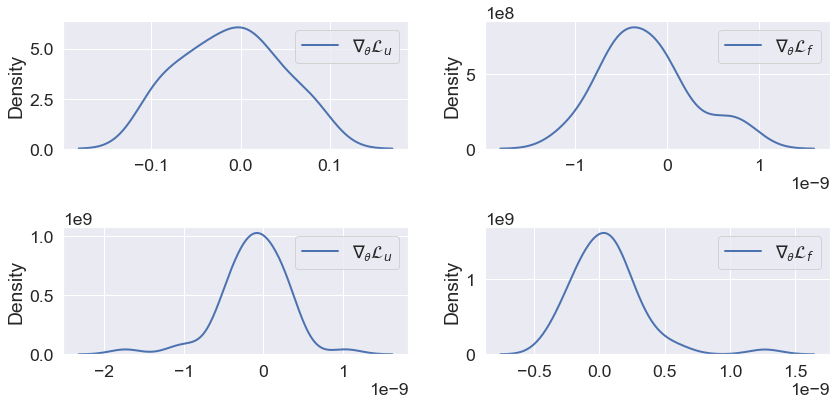

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

sns.kdeplot(PINN_solver.gradients_log[0][1][0].numpy().flatten(), linewidth =2, ax = axs[0][0], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_u$')
axs[0][0].legend()


sns.kdeplot(PINN_solver.gradients_log[0][2][0].numpy().flatten(), linewidth =2, ax = axs[0][1], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_f$')
axs[0][1].legend()


sns.kdeplot(PINN_solver.gradients_log[2][1][0].numpy().flatten(), linewidth =2, ax = axs[1][0], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_u$')
axs[1][0].legend()


sns.kdeplot(PINN_solver.gradients_log[2][2][0].numpy().flatten(), linewidth =2, ax = axs[1][1], 
            label = r'$\nabla_\mathcal{\theta}\mathcal{L}_f$')
axs[1][1].legend()

plt.tight_layout()
plt.legend()

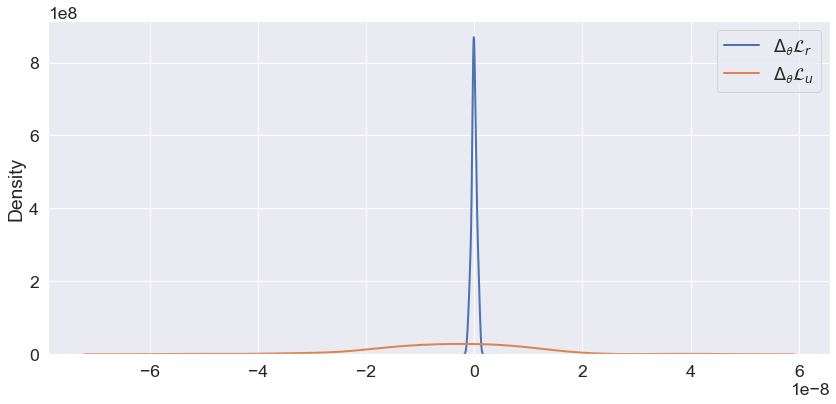

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

sns.kdeplot(PINN_solver.gradients_log[1][2][0].numpy().flatten(), ax = axs, linewidth =2,
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_r$')

sns.kdeplot(PINN_solver.gradients_log[1][1][0].numpy().flatten(), linewidth =2, ax = axs, 
            label = r'$\Delta_\mathcal{\theta}\mathcal{L}_u$')

plt.tight_layout()
plt.legend()

### Visualize loss function

In [15]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

#### Loss convergence comparison

In [16]:
iterations_range = np.array(range(len(pinn_pcgrad_loss_log[50000:52000, 1]))) + 50000

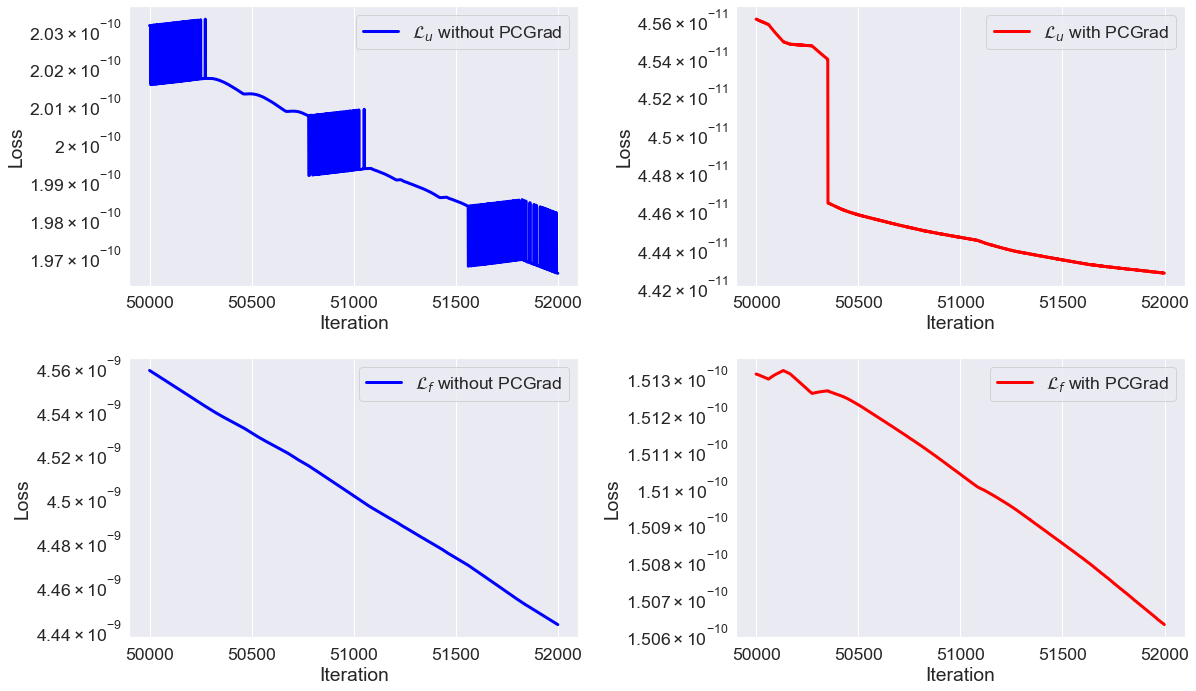

In [17]:
f, ax = plt.subplots(2, 2, figsize=(17, 10))

sns.lineplot(x = iterations_range, y = pinn_loss_log[50000:52000, 0], linewidth = 3, color='blue',
             label=r'$\mathcal{L}_u$ without PCGrad', ax = ax[0][0])

ax[0][0].set(yscale="log")
ax[0][0].set_xlabel("Iteration")
ax[0][0].set_ylabel("Loss")


sns.lineplot(x = iterations_range, y = pinn_pcgrad_loss_log[50000:52000, 0], linewidth = 3, color='red', 
             label=r'$\mathcal{L}_u$ with PCGrad', ax = ax[0][1])

ax[0][1].set(yscale="log")
ax[0][1].set_xlabel("Iteration")
ax[0][1].set_ylabel("Loss")


sns.lineplot(x = iterations_range, y = pinn_loss_log[50000:52000, 1], linewidth = 3, color='blue',
             label=r'$\mathcal{L}_f$ without PCGrad', ax = ax[1][0])

ax[1][0].set(yscale="log")
ax[1][0].set_xlabel("Iteration")
ax[1][0].set_ylabel("Loss")


sns.lineplot(x = iterations_range, y = pinn_pcgrad_loss_log[50000:52000, 1], linewidth = 3, color='red', 
             label=r'$\mathcal{L}_f$ with PCGrad', ax = ax[1][1])

ax[1][1].set(yscale="log")
ax[1][1].set_xlabel("Iteration")
ax[1][1].set_ylabel("Loss")


plt.tight_layout()
plt.savefig('loss_convergence.pdf')

#### Comparison of loss 

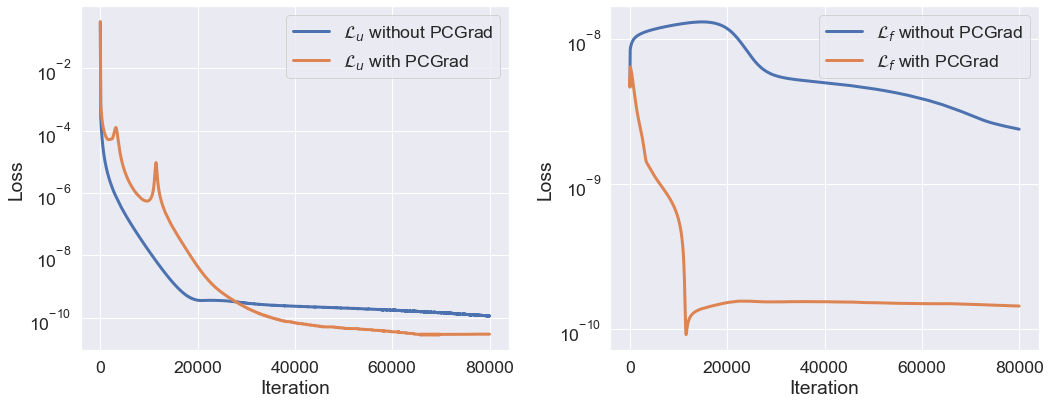

In [18]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ with PCGrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = pinn_loss_log[:, 1],  linewidth = 3, 
             label = "$\mathcal{L}_f$ without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = pinn_pcgrad_loss_log[:, 1],  linewidth = 3, 
             label = "$\mathcal{L}_f$ with PCGrad", ax = axes[1])
axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.savefig("performance_comparison.pdf")

#### Solution quality comparison

In [19]:
matlab_solver_solution_df = pd.read_csv('homo_80000.csv')
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [20]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [21]:
matlab_solver_solution_df

,state_0,state_1,state_2
0,0.997940,0.000894,0.001161
1,0.995890,0.001785,0.002321
2,0.993850,0.002673,0.003480
3,0.991800,0.003557,0.004639
4,0.989770,0.004439,0.005796
...,...,...,...
4995,0.000034,0.000575,0.999390
4996,0.000034,0.000574,0.999390
4997,0.000034,0.000573,0.999390
4998,0.000034,0.000572,0.999390


In [22]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

ub = 80000
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
x_star_normalized = (x_star-mu)/sigma

In [23]:
y_pred = PINN_solver.model(x_star_normalized)
y_pred_pcgrad = PINN_solver_pcgrad.model(x_star_normalized)

In [24]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = ['state_0', 'state_1', 'state_2'])
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = ['state_0', 'state_1', 'state_2'])

In [25]:
sns.set_style("white")

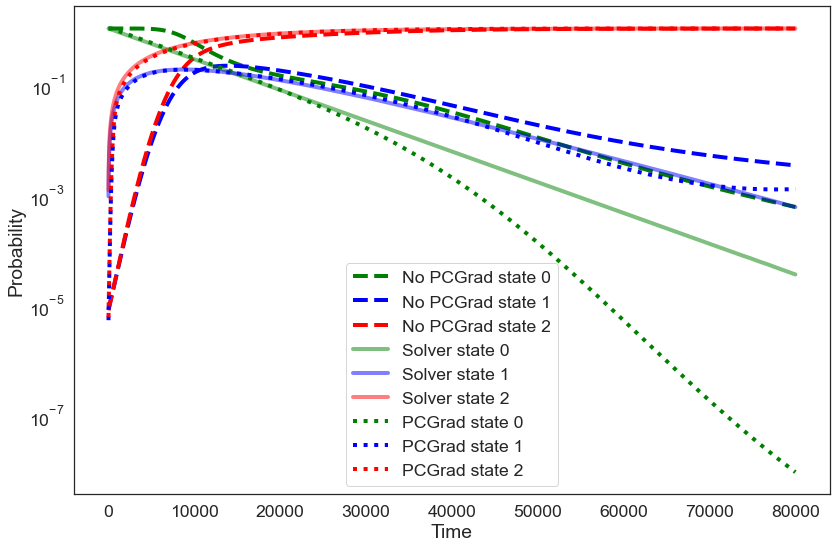

In [26]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'No PCGrad state 0', linewidth = 4, color = 'green', 
             linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'No PCGrad state 1', linewidth = 4, color = 'blue', 
             linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'No PCGrad state 2', linewidth = 4, color = 'red', 
             linestyle='--', ax=ax)

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], label = 'Solver state 0', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], label = 'Solver state 1', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], label = 'Solver state 2', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)

sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'PCGrad state 0', color = 'green', linestyle='dotted',
             linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'PCGrad state 1', color = 'blue', linestyle='dotted',
             linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'PCGrad state 2', color = 'red', linestyle='dotted',
             linewidth = 4, ax=ax)


ax.set_yscale("log")
ax.set_xlabel("Time")
ax.set_ylabel("Probability")

plt.tight_layout()
plt.savefig("comparison.pdf")

In [27]:
y_pred_df.tail()

,state_0,state_1,state_2
4995,0.000576,0.003273,0.996152
4996,0.000575,0.003271,0.996154
4997,0.000574,0.003269,0.996157
4998,0.000574,0.003267,0.996159
4999,0.000573,0.003265,0.996162


In [28]:
y_pred_pcgrad_df.tail()

,state_0,state_1,state_2
4995,8.955214e-09,0.001210,0.998790
4996,8.916524e-09,0.001210,0.998790
4997,8.878033e-09,0.001210,0.998790
4998,8.839742e-09,0.001210,0.998790
4999,8.801599e-09,0.001211,0.998789


In [29]:
y_pred_pcgrad_df.loc[:3749]

,state_0,state_1,state_2
0,0.999989,0.000005,0.000006
1,0.999985,0.000007,0.000008
2,0.999979,0.000010,0.000012
3,0.999970,0.000014,0.000016
4,0.999958,0.000019,0.000023
...,...,...,...
3745,0.000005,0.002922,0.997073
3746,0.000005,0.002917,0.997077
3747,0.000005,0.002913,0.997082
3748,0.000005,0.002909,0.997086


In [30]:
y_diff = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad = matlab_solver_solution_df - y_pred_pcgrad_df

In [31]:
y_diff

,state_0,state_1,state_2
0,-0.002045,0.000886,0.001153
1,-0.004094,0.001777,0.002313
2,-0.006134,0.002665,0.003472
3,-0.008183,0.003549,0.004630
4,-0.010213,0.004430,0.005788
...,...,...,...
4995,-0.000541,-0.002697,0.003238
4996,-0.000541,-0.002696,0.003236
4997,-0.000540,-0.002696,0.003233
4998,-0.000539,-0.002695,0.003231


In [32]:
y_diff['mse'] = y_diff.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff['rmse'] = y_diff['mse'].apply(np.sqrt)

y_diff_pcgrad['mse'] = y_diff_pcgrad.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_pcgrad['rmse'] = y_diff_pcgrad['mse'].apply(np.sqrt)

In [33]:
y_diff.head()

,state_0,state_1,state_2,mse,rmse
0,-0.002045,0.000886,0.001153,0.000006,0.002509
1,-0.004094,0.001777,0.002313,0.000025,0.005027
2,-0.006134,0.002665,0.003472,0.000057,0.007535
3,-0.008183,0.003549,0.004630,0.000101,0.010050
4,-0.010213,0.004430,0.005788,0.000157,0.012547


In [34]:
y_diff_pcgrad.head()

,state_0,state_1,state_2,mse,rmse
0,-0.002049,0.000889,0.001155,0.000006,0.002515
1,-0.004095,0.001778,0.002313,0.000025,0.005028
2,-0.006129,0.002663,0.003469,0.000057,0.007529
3,-0.008170,0.003544,0.004623,0.000101,0.010034
4,-0.010188,0.004420,0.005773,0.000157,0.012517


In [35]:
print ('RMSE of PINN without PCGrad is', np.mean(y_diff['rmse']))
print ('RMSE of PINN with PCGrad is', np.mean(y_diff_pcgrad['rmse']))

RMSE of PINN without PCGrad is 0.11113926525797774
RMSE of PINN with PCGrad is 0.008277526607726451


In [36]:
print ('RMSE of PINN without PCGrad before 60,000 is', np.mean(y_diff['rmse'][:3749]))
print ('RMSE of PINN with PCGrad before 60,000 is', np.mean(y_diff_pcgrad['rmse'][:3749]))

print ('RMSE of PINN without PCGrad after 60,000 is', np.mean(y_diff['rmse'][3749:]))
print ('RMSE of PINN with PCGrad after 60,000 is', np.mean(y_diff_pcgrad['rmse'][3749:]))

RMSE of PINN without PCGrad before 60,000 is 0.14614631730910296
RMSE of PINN with PCGrad before 60,000 is 0.010807554478231961
RMSE of PINN without PCGrad after 60,000 is 0.0062300421247489576
RMSE of PINN with PCGrad after 60,000 is 0.0006955326137016304
